In [2]:
import pandas as pd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from glob import glob
import numpy as np
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import cartopy.crs as ccrs
from geodatasets import get_path
import pyreadr
from matplotlib.patches import Rectangle
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import date
import scipy
from itertools import product
from typing import Callable, Union, Tuple
import matplotlib.patches as mpatches
from utils import *

# Make figures the main text and supplementary information

## Load data

### Estimates

In [3]:
# load estimates starting from 1992
obs_periods = pd.read_csv('../results/06_make_estimates/obs_periods.csv', index_col=[0,1,2,3])['0']
DGVMs_periods = pd.read_csv('../results/06_make_estimates/DGVMs_periods.csv', index_col=[0,1,2,3])['0']
obs_annual_cum = pd.read_csv('../results/06_make_estimates/obs_annual_cum.csv', index_col=[0,1,2])['0']
DGVMs_annual_cum = pd.read_csv('../results/06_make_estimates/DGVMs_annual_cum.csv', index_col=[0,1,2])['0']
single_DGVM_data = pd.read_csv('../results/06_make_estimates/single_DGVM_data.csv', index_col=[0,1,2])

# load estimates from 1992 but with correlated uncertainties
obs_periods_cor = pd.read_csv('../results/06_make_estimates/obs_periods_cor.csv', index_col=[0,1,2,3])['0']

# load raw biomass data
biomass_data_obs = pd.read_csv('../results/04_temporal_harmonization/harmonized_biomass_data.csv',index_col=[0,1,2,3])
biomass_data_obs.columns = biomass_data_obs.columns.astype(int)

# biomass trends at different starting years
biomass_different_starts = pd.read_csv('../results/06_make_estimates/delta_B_obs_different_starts.csv',index_col=[0])/1e15
delta_C_different_starts = pd.read_csv('../results/06_make_estimates/delta_C_obs_different_starts.csv',index_col=[0])/1e15

# load data starting from 1995
obs_periods_1995 = pd.read_csv('../results/06_make_estimates/obs_periods_1995.csv', index_col=[0,1,2,3])['0']
DGVMs_periods_1995 = pd.read_csv('../results/06_make_estimates/DGVMs_periods_1995.csv', index_col=[0,1,2,3])['0']
obs_annual_cum_1995 = pd.read_csv('../results/06_make_estimates/obs_annual_cum_1995.csv', index_col=[0,1,2])['0']
DGVMs_annual_cum_1995 = pd.read_csv('../results/06_make_estimates/DGVMs_annual_cum_1995.csv', index_col=[0,1,2])['0']
single_DGVM_data_1995 = pd.read_csv('../results/06_make_estimates/single_DGVM_data_1995.csv', index_col=[0,1,2])

# load the bottom-up estimates for the nonliving carbon pools
nonliving_BU_data = pd.read_csv('../results/07_nonliving_OC/nonliving_OC_budget.csv',index_col=0)

### Regions

In [4]:
# load country data
countries_data = gpd.read_file('../data/country_data/country_data_w_RECCAP_Pan_FAO.shp')
countries_data['id'] = countries_data.index

# create reccap_regions
reccap_regions = countries_data.dissolve(by='RECCAP reg')

# create pan_regions
pan_regions = countries_data.dissolve(by='Pan region')
pan_regions['name'] = pan_regions.index

In [4]:
# load GFED regions
GFED_regions = rio.open_rasterio('../data/regions_data/GFED/GFED5_Beta_monthly_2002.nc',variable='basisregions').sel(band=1)['basisregions']
GFED_regions.rio.write_crs(4326,inplace=True);

# replace 0 values with NaN
GFED_regions = GFED_regions.where(GFED_regions!=0)

# set the nodata value to NaN
GFED_regions.rio.write_nodata(np.nan,inplace=True);

# load the names of each region
GFED_region_names = pd.read_excel('../data/biomass/besnard_et_al_2021/data.xlsx',sheet_name='region_names')

## Figure 1

In [5]:
# unpack the mean and std for the different pools from observations and the models
obs_annual_cum_mean = obs_annual_cum.loc[pd.IndexSlice['mean', :, :, ]].unstack('pool')/1e15
obs_annual_cum_std = obs_annual_cum.loc[pd.IndexSlice['std', :, :, ]].unstack('pool')/1e15
DGVMs_annual_cum_mean = DGVMs_annual_cum.loc[pd.IndexSlice['mean', :, :, ]].unstack('pool')/1e15
DGVMs_annual_cum_std = DGVMs_annual_cum.loc[pd.IndexSlice['std', :, :, ]].unstack('pool')/1e15

In [6]:

def generate_fig1(obs_annual_cum_mean:pd.DataFrame, obs_annual_cum_std:pd.DataFrame, DGVMs_annual_cum_mean:pd.DataFrame, DGVMs_annual_cum_std:pd.DataFrame) -> plt.Figure:
    """
    Generate figure 1 of the manuscript

    Parameters:
    obs_annual_cum_mean:pd.DataFrame
        The mean of the cumulative change in carbon stocks and living biomass from the observations
    obs_annual_cum_std:pd.DataFrame
        The standard deviation of the cumulative change in carbon stocks and living biomass from the observations
    DGVMs_annual_cum_mean:pd.DataFrame
        The mean of the cumulative change in carbon stocks and living biomass from the DGVMs
    DGVMs_annual_cum_std:pd.DataFrame
        The standard deviation of the cumulative change in carbon stocks and living biomass from the DGVMs

    Returns:
    fig:plt.Figure
        The figure object
    """
    
    # set font size
    font = {'size'   : 7}
    matplotlib.rc('font', **font)

    # define colors for analysis
    colors_obs = ['forestgreen','k']
    colors_DGVM = ['#A2B409','#817667']

    # create a figure with two panels
    fig,axs =plt.subplots(1,2,dpi=300,figsize=[17.8/2.54,6/2.54],constrained_layout=True)

    # Panel A
    ax = axs[0]
    # plot the cumulative change in carbon stocks and living biomass
    obs_annual_cum_mean.plot(color=colors_obs,ax=ax,legend=False)

    # plot the uncertainty
    for col,c in zip(obs_annual_cum_mean.columns,colors_obs):
        ax.fill_between(obs_annual_cum_mean.index,obs_annual_cum_mean[col]-obs_annual_cum_std[col],obs_annual_cum_mean[col]+obs_annual_cum_std[col],alpha=0.2,color=c,lw=0)

    # add a horizontal line at 0
    ax.axhline(0,c='grey',zorder=0,ls='--')

    # set the labels
    ax.set(ylabel='cumulative change in carbon stocks (GtC)',ylim=[-12,55],xlabel='')
    ax.set_title('this study',fontdict={'size':10})

    # add text to the plot
    ax.text(2013,45,'change in land\ncarbon stocks',ha='center')
    ax.text(2016,9.,'change in\nbiomass stocks',ha='center',color='forestgreen')
    ax.annotate('start of\nstudy period',xy =[1992,0], xytext= [1992,20],arrowprops=dict(facecolor="0.5",arrowstyle='->',connectionstyle='arc3,rad=0.3',shrinkB=2),ha='left')#,ls='--',lw=1,color='k')
    ax.text(-0.05,1.1,'A',transform=ax.transAxes,fontsize=12)

    # hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)


    # Panel B
    ax = axs[1]

    # plot the cumulative change in carbon stocks and living biomass
    DGVMs_annual_cum_mean.plot(color=colors_DGVM,ax=ax,legend=False)

    # plot the uncertainty
    for col,c in zip(DGVMs_annual_cum_mean.columns,colors_DGVM):
        ax.fill_between(DGVMs_annual_cum_mean.index,DGVMs_annual_cum_mean[col]-DGVMs_annual_cum_std[col],DGVMs_annual_cum_mean[col]+DGVMs_annual_cum_std[col],alpha=0.2,color=c,lw=0)

    # add a horizontal line at 0
    ax.axhline(0,c='grey',zorder=0,ls='--')

    # set the labels
    ax.set(ylabel='cumulative change in carbon stocks (GtC)',ylim=[-12,55],xlabel='')
    ax.set_title('global vegetation models',fontdict={'size':10});

    # add text to the plot
    ax.text(2010,40,'change in land\ncarbon stocks',ha='center',color=colors_DGVM[1])
    ax.text(2019,1.2,'change in\nbiomass stocks',ha='center',color=colors_DGVM[0])
    ax.text(-0.05,1.1,'B',transform=ax.transAxes,fontsize=12)
    ax.annotate('start of\nstudy period',xy =[1992,0], xytext= [1992,20],arrowprops=dict(facecolor="0.5",arrowstyle='->',connectionstyle='arc3,rad=0.3',shrinkB=2),ha='left')#,ls='--',lw=1,color='k')

    # hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    return fig

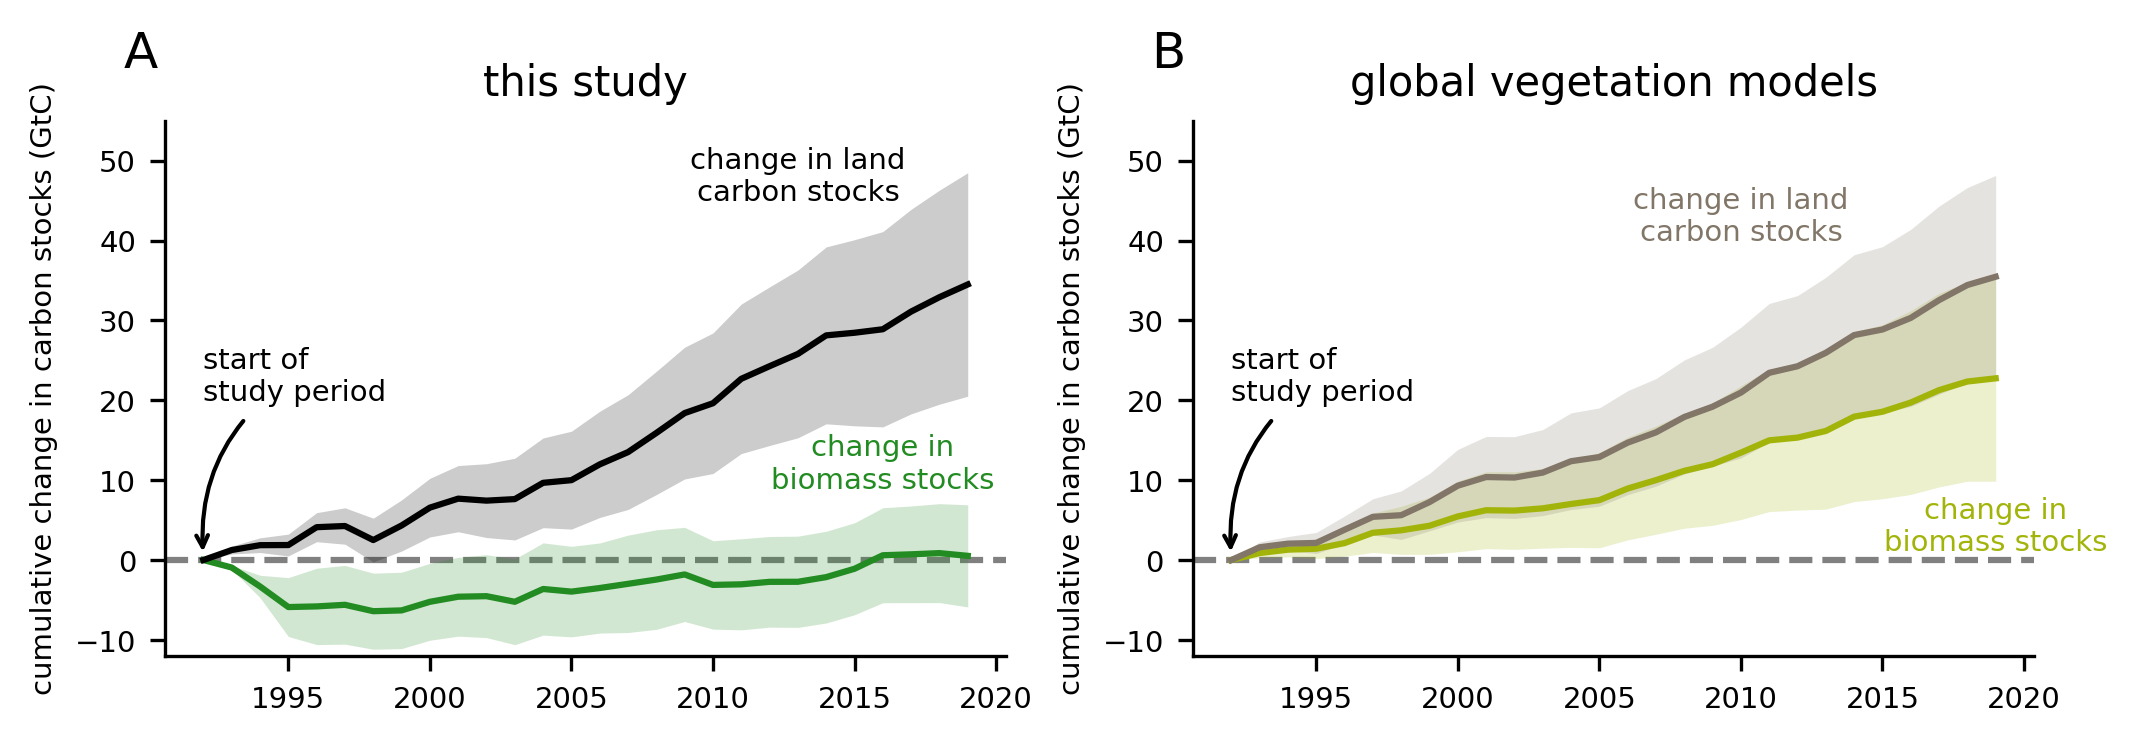

In [7]:
# generate figure
fig = generate_fig1(obs_annual_cum_mean,obs_annual_cum_std,DGVMs_annual_cum_mean,DGVMs_annual_cum_std)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig1_{d}.png',dpi=300)
plt.savefig(f'../figures/fig1_{d}.svg',dpi=300)
plt.savefig(f'../figures/fig1_{d}.pdf',dpi=300)

## Table 1

In [8]:
def generate_table1(obs_periods:pd.DataFrame, DGVMs_periods:pd.DataFrame,start_year=1992) -> pd.DataFrame:
    """
    Generate table 1 of the manuscript

    Parameters:
    obs_periods:pd.DataFrame
        The mean and standard deviation of the cumulative change in carbon stocks and living biomass from the observations
    DGVMs_periods:pd.DataFrame
        The mean and standard deviation of the cumulative change in carbon stocks and living biomass from the DGVMs
    start_year:int
        The starting year of the analysis

    Returns:
    table1:pd.DataFrame
        The table object
    """
    
    # take the global estimate for living biomass and total carbon stocks from observations 
    table1_data_obs = obs_periods.loc[pd.IndexSlice[:,['delta_B','delta_C'],'Global']].unstack()/1e15
    table1_data_obs.index = table1_data_obs.index.droplevel('time')

    # convert the data to strings
    table1_data_obs = table1_data_obs.map(lambda x: f'{x:.1g}' if x<=1.05 else f'{x:.1f}')
    table1_data_obs = table1_data_obs.T.apply(lambda x: x.loc['mean'].round(1).astype(str)+' ± '+x.loc['std'].round(1).astype(str),axis=1).T

    # take the global estimate for living biomass and total carbon stocks from observations 
    table1_data_DGVMs = DGVMs_periods.loc[pd.IndexSlice[:,['delta_B','delta_C'],'Global']].unstack()/1e15
    table1_data_DGVMs.index = table1_data_DGVMs.index.droplevel('time')

    # convert the data to strings
    table1_data_DGVMs = table1_data_DGVMs.map(lambda x: f'{x:.1g}' if x<=1.05 else f'{x:.1f}')
    table1_data_DGVMs = table1_data_DGVMs.T.apply(lambda x: x.loc['mean'].round(1).astype(str)+' ± '+x.loc['std'].round(1).astype(str),axis=1).T

    # concatenate the observations and model estimates
    table1 = pd.concat([table1_data_obs,table1_data_DGVMs],axis=0,keys=['observation-based','global vegetation models'])
    table1.index.names = ['source','pool']
    table1 = table1.reset_index().set_index(['pool','source']).sort_index(ascending=False)

    # order the columns
    table1 = table1[[f'{start_year+1}-2000','2001-2010','2011-2019',f'{start_year+1}-2019']]

    return table1



In [9]:
# generate the table
table1 = generate_table1(obs_periods,DGVMs_periods)

# save the table
d=pd.to_datetime(date.today()).strftime("%y%m%d")
table1.to_csv(f'../figures/table1_{d}.csv')
table1

period                             1993-2000  2001-2010  2011-2019   1993-2019
pool    source                                                                
delta_C observation-based          0.8 ± 0.5  1.3 ± 0.5  1.7 ± 0.6   1.3 ± 0.5
        global vegetation models   1.2 ± 0.6  1.2 ± 0.4  1.6 ± 0.6   1.3 ± 0.5
delta_B observation-based         -0.7 ± 0.7  0.2 ± 0.3  0.4 ± 0.4  0.02 ± 0.3
        global vegetation models   0.7 ± 0.6  0.8 ± 0.5    1 ± 0.6   0.8 ± 0.5

## Figure 2

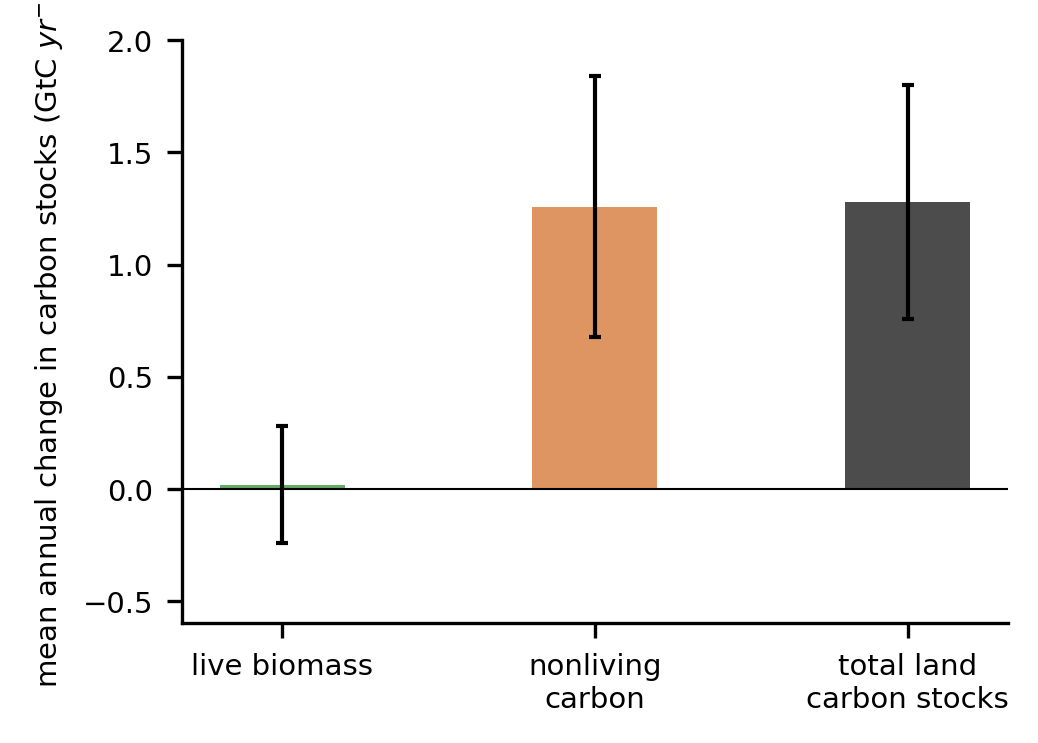

In [10]:
# take the global data for the entire study period
fig2_data = obs_periods.loc[pd.IndexSlice[:,:,'Global','1993-2019']].unstack()[['delta_B','delta_OC','delta_C']]/1e15

# set up the figure, fonts, and colors
font = {'size'   : 7}
colors= ['forestgreen','chocolate','k']
matplotlib.rc('font', **font)
fig,ax =plt.subplots(dpi=300,figsize=[8.5/2.54,6/2.54],constrained_layout=True)

# plot the bar plot
ax.bar(x = range(fig2_data.shape[1]),width = 0.4,  height = fig2_data.loc['mean'],color = colors,alpha=0.7,error_kw ={'elinewidth':1},yerr=fig2_data.loc['std'],capsize=1.5,edgecolor='grey',lw=0)

# set axes labels and lims
ax.set(xticks=range(3),xticklabels=['live biomass','nonliving\ncarbon','total land\ncarbon stocks'],ylabel='mean annual change in carbon stocks (GtC $yr^{-1}$)',ylim=[-0.6,2])

# add a horizontal line at 0
ax.axhline(0,c='k',lw=0.5,ls='-')

# hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig2_{d}.png',dpi=300)
plt.savefig(f'../figures/fig2_{d}.svg',dpi=300)
plt.savefig(f'../figures/fig2_{d}.pdf',dpi=300)

## Figure 3

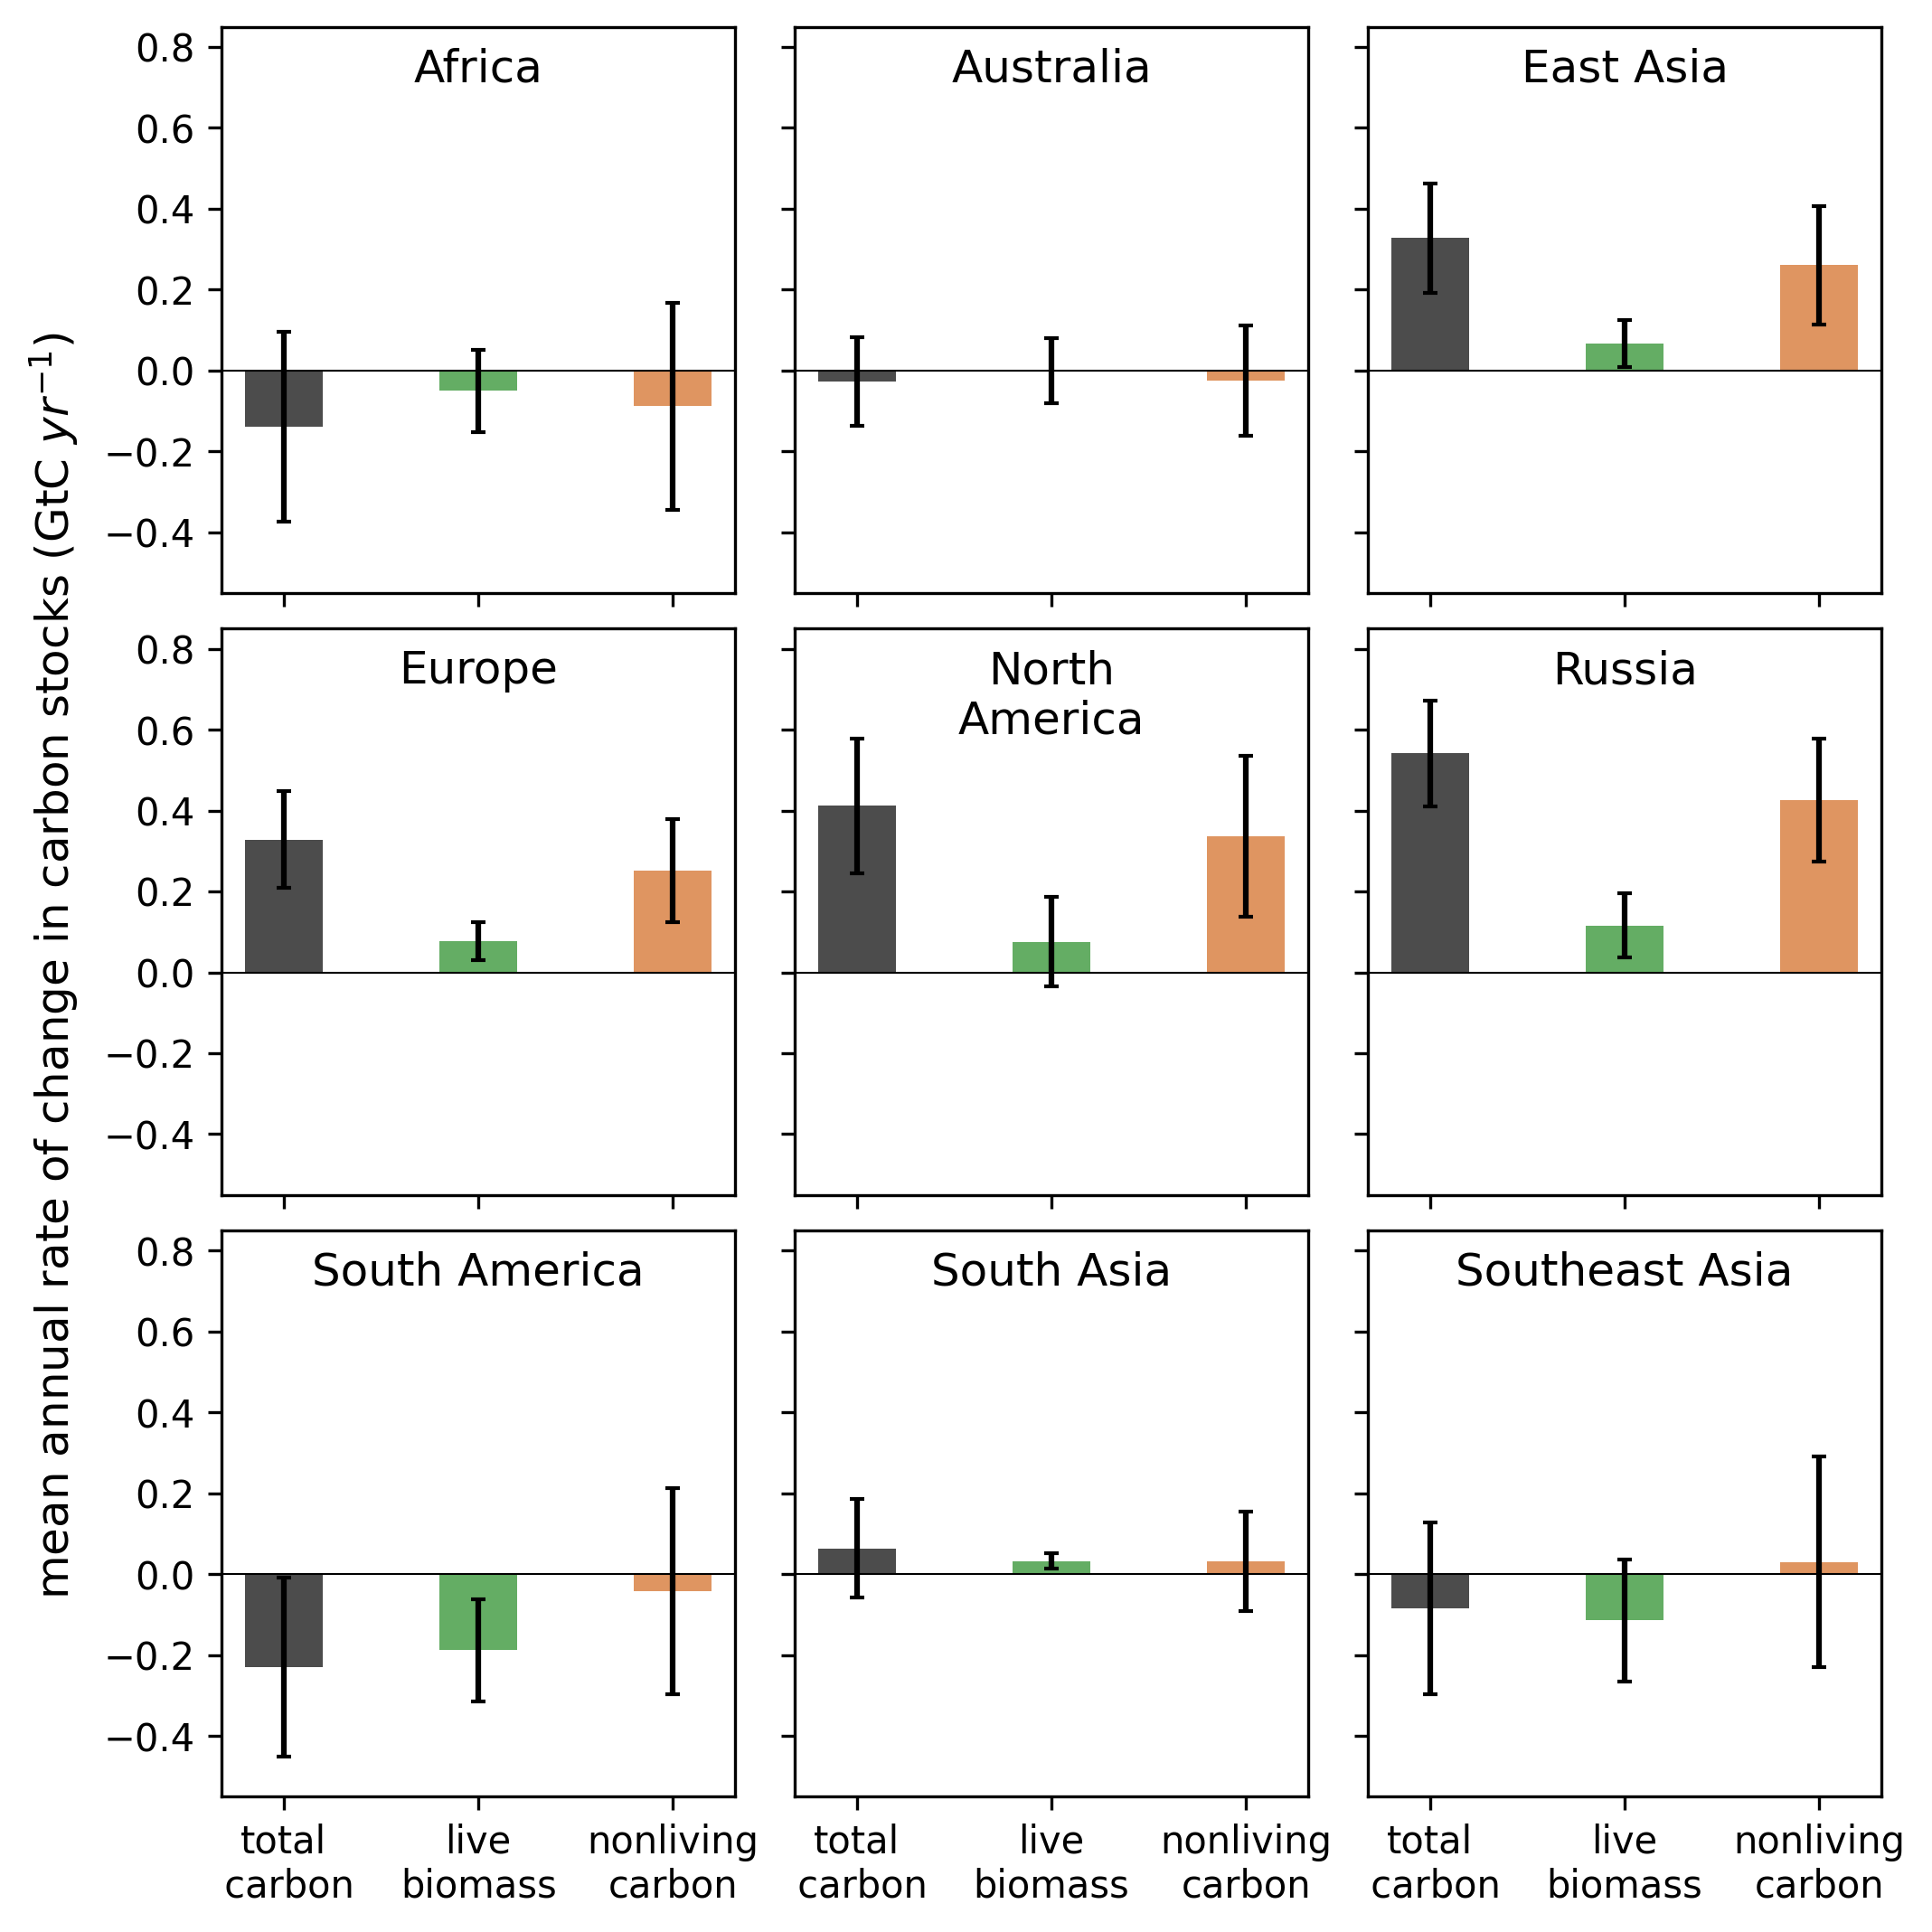

In [11]:
# extract the mean and std for the different pools in the different regions
fig3_data = obs_periods.loc[pd.IndexSlice[:,:,:,'1993-2019']].unstack('pool')[['delta_C','delta_B','delta_OC']]/1e15

# remove the Global estimate and the estimate for the "Other" region
fig3_data = fig3_data[~fig3_data.index.get_level_values(level=1).isin(['Global','Other'])]

# modify labels such that "North America" will be two lines
fig3_data.index = fig3_data.index.set_levels(fig3_data.index.levels[1].str.replace('North ','North\n'),level='time')


# set up the figure, fonts, and colors
font = {'size'   : 10}
colors= ['k','forestgreen','chocolate']
matplotlib.rc('font', **font)
fig,axs =plt.subplots(3,3,dpi=300,figsize=[17.8/2.54,17.8/2.54],constrained_layout=True,sharex=True,sharey=True)

# for each region
for (name,df),(name,df_std), (i,ax) in zip(fig3_data.loc['mean'].iterrows(),fig3_data.loc['std'].iterrows(),enumerate(axs.flatten())):
        
        # plot the bar plot
        ax.bar(x = range(3),width = 0.4, height = list(df.values),bottom=0,yerr=df_std.values,color = colors,alpha=0.7,edgecolor='grey',lw=0,capsize=2)

        # set axes labels and lims
        ax.set(xticks=range(3),xticklabels=['total\n carbon','live\nbiomass','nonliving\ncarbon'],ylim=[-0.55,0.85])
        
        # add a horizontal line at 0
        ax.axhline(0,c='k',lw=0.5,ls='-')

        # add the region name
        ax.text(1,0.8,name,ha='center',va='top',fontdict={'size':12})
        
# set the figure-level y axis label
fig.supylabel('mean annual rate of change in carbon stocks (GtC $yr^{-1}$)')

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig3_{d}.png',dpi=300)
plt.savefig(f'../figures/fig3_{d}.svg',dpi=300)
plt.savefig(f'../figures/fig3_{d}.pdf',dpi=300)

## Figure 4

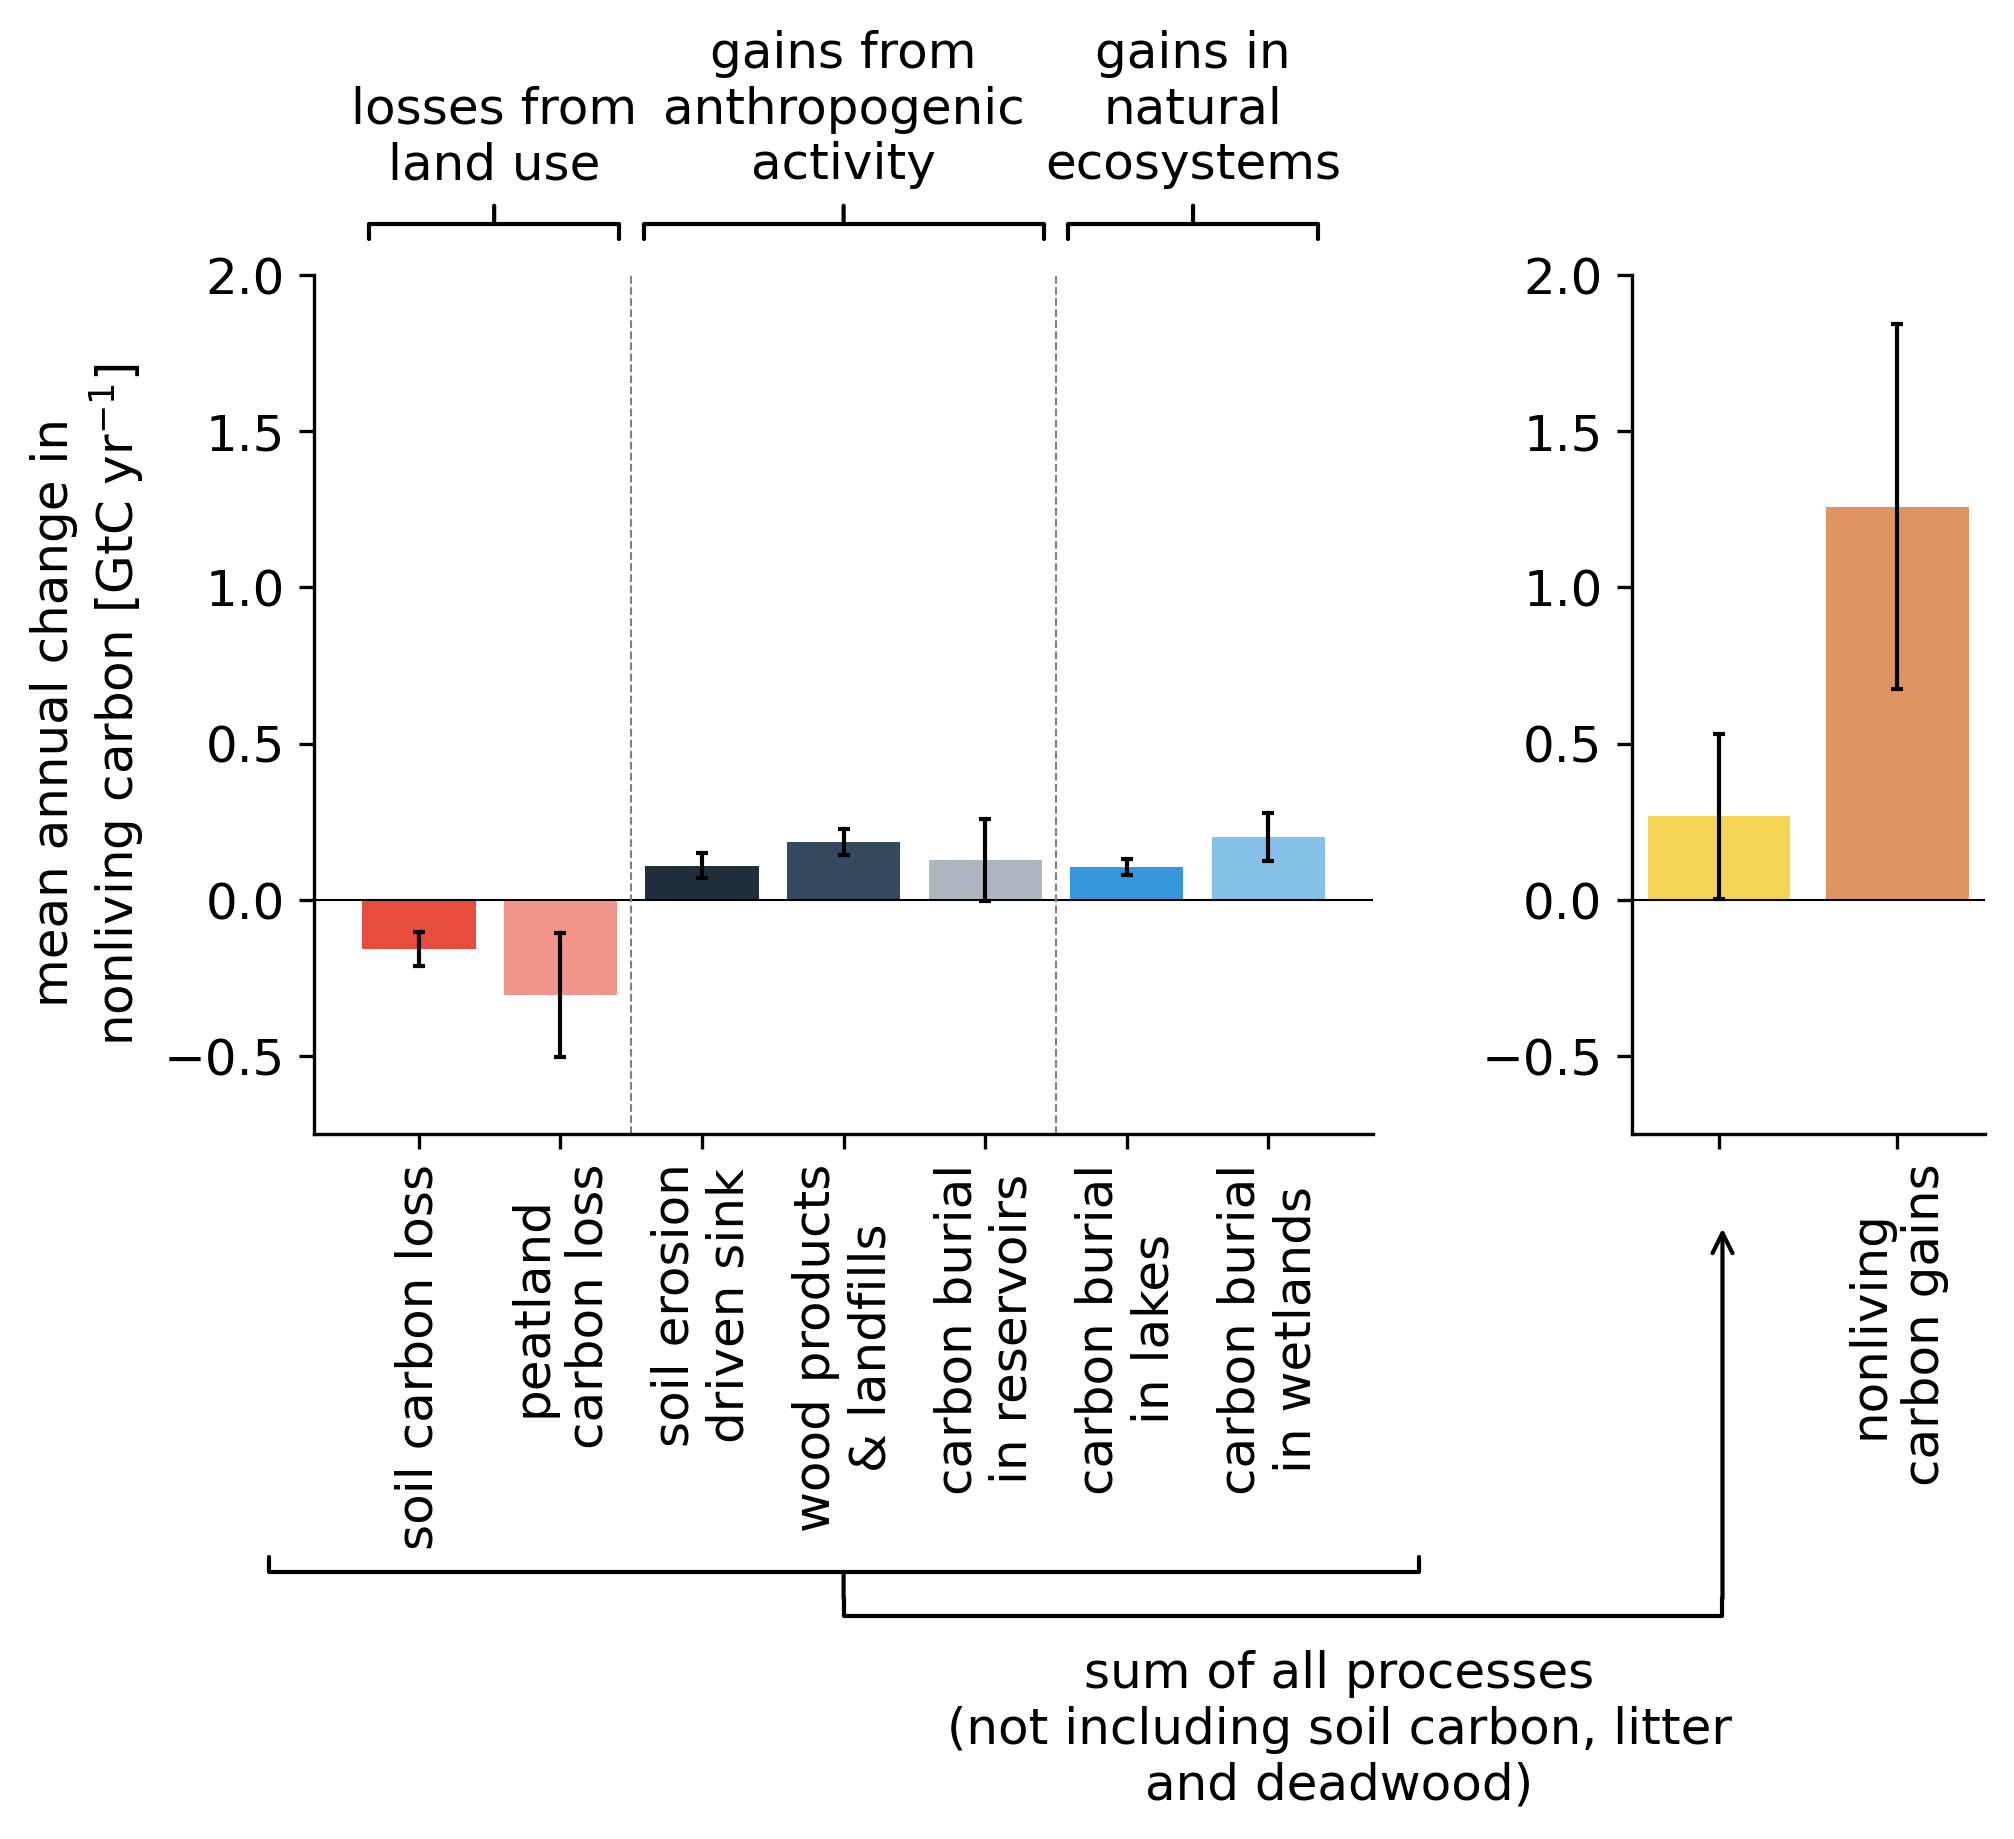

In [12]:
# extract the total nonliving carbon stock changes for the entire study period
total_nonliving_acc = obs_periods.loc[pd.IndexSlice[:,'delta_OC','Global','1993-2019']]

# for panel A, take the mean and std for the different pools except the total estimate
fig_data_a = nonliving_BU_data.drop(index='total estimate')

# for panel B, take the total mean and std estimate for all nonliving pools
fig_data_b = nonliving_BU_data.loc[['total estimate']]

# set the names of the different pools
fig_data_a.index = ['soil carbon loss',
                    'peatland\ncarbon loss',
                    'soil erosion\ndriven sink',
                    'wood products\n& landfills',
                    'carbon burial\nin reservoirs',
                    'carbon burial\nin lakes',
                    'carbon burial\nin wetlands']

# set up the figure, fonts, and colors
font = {'size'   : 12}
matplotlib.rc('font', **font)
cs = np.array(['#E74C3C','#F1948A','#212F3D','#34495E','#AEB6BF','#3498DB','#85C1E9','#F1C40F','chocolate'])
fig,axs =plt.subplots(1,2,dpi=300,figsize=[17.8/2.54,17.8/1.5/2.54],gridspec_kw={'width_ratios': [3, 1]},sharey=False)

# panel A
ax = axs[0]

# plot the bar plot
a = ax.bar(x = range(fig_data_a['mean'].shape[0]),  height = fig_data_a['mean'],error_kw ={'elinewidth':1},yerr=fig_data_a['std'],capsize=1.5,edgecolor='grey',lw=0,color=cs)

# draw the vertical and horizontal lines
ax.axhline(0,lw=0.5,c='k')
ax.axvline(1.5,lw=0.5,c='grey',ls='--')
ax.axvline(4.5,lw=0.5,c='grey',ls='--')

# set axes labels and lims
ax.set(xticks=range(7),xticklabels=list([i.replace("\\n","\n") for i in fig_data_a.index.values]),ylabel='mean annual change in \nnonliving carbon [GtC yr$^{-1}$]',ylim=[-0.75,2])
ax.tick_params('x',rotation=90)

# hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# make the space between panels tight
fig.tight_layout(w_pad=3)

# draw arrows with their labels
ax.annotate('losses from\nland use', xy=(0.17, 1.05), xytext=(0.17, 1.1), xycoords='axes fraction', 
             ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.3', lw=1.0, color='k'))

ax.annotate('gains from\nanthropogenic\nactivity', xy=(0.5, 1.05), xytext=(0.5, 1.1), xycoords='axes fraction', 
             ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=4., lengthB=.3', lw=1.0, color='k'))

ax.annotate('gains in\nnatural\necosystems', xy=(0.83, 1.05), xytext=(0.83, 1.1), xycoords='axes fraction', 
             ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.3', lw=1.0, color='k'))

ax.annotate('', xy=(0.5, -0.5), xytext=(0.5, -.55), xycoords='axes fraction', 
             ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=11.5, lengthB=0.3', lw=1.0, color='k'))

ax.annotate('', xy=(1.33, -0.53), xycoords='axes fraction',
            xytext=(0.5, -.53), 
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar,fraction=0.03",
                            ec="k"
                            ))

ax.annotate('', xy=(1.33, -0.55), xycoords='axes fraction',
            xytext=(1.33, -.1), 
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3,rad=0",
                            ec="k"
                            ))

ax.text(6.5,-2.4,"sum of all processes\n(not including soil carbon, litter\nand deadwood)",ha='center',va='top')

# panel B
ax = axs[1]

# hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# concatenate the sum of the bottom-up nonliving carbon estimates and the top-down residual estimate
ys = list(fig_data_b['mean'])+[total_nonliving_acc.loc['mean']/1e15]
yerr = list(fig_data_b['std']) +[total_nonliving_acc.loc['std']/1e15]

# plot the bar plot
ax.bar(x = range(len(ys)),  height = ys,error_kw ={'elinewidth':1},yerr=yerr,capsize=1.5,edgecolor='grey',lw=0,color=cs[-2:],alpha=0.7)

# set axes labels and lims
ax.set(xticks= [0,1],xticklabels=['','nonliving\ncarbon gains'],ylim=[-0.75,2])
ax.tick_params('x',rotation=90)

# add a horizontal line at 0
ax.axhline(0,lw=0.5,c='k')

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig4_{d}.png',dpi=300, bbox_inches="tight")
plt.savefig(f'../figures/fig4_{d}.svg',dpi=300, bbox_inches="tight")
plt.savefig(f'../figures/fig4_{d}.pdf',dpi=300, bbox_inches="tight")


## Figure S1

In [13]:
def parse_year_pan(df:pd.DataFrame,i:int,year:int) -> pd.DataFrame:
    """
    Parse the data for a given year from the Pan et al. data.

    Args:
    df (pd.DataFrame): data
    i (int): index of the year
    year (int): year

    Returns:
    pd.DataFrame: parsed data
    """
    
    # select the data for the year
    df = df.iloc[:36,i*9:i*9+7]

    # remove title rows and subtotal rows
    df = df[df.sum(axis=1) > 0].drop(index='Subtotal').stack()
    
    # give names for the index levels
    df.index.names = ['region','pool']

    # reset the index and give a name for the value column
    df = df.reset_index(name='value')

    # add the year column
    df['year'] = year

    return df

In [14]:

# load the data from Extended Data Table 2 from Pan et al. (2024)
pan_data = pd.read_excel('../data/biomass/pan_et_al_2024/RDS-2023-0051/Data/Pan_etal_2024/Summary_Tables_Global_Forest_Inventory_1990-2020.xlsx', sheet_name='Table 2 Stock', skiprows=3,index_col=0)

# parse the data for each year and concatenate them
pan_data_parsed = pd.concat([parse_year_pan(pan_data,i,y) for i,y in enumerate([1990,2000,2010,2020])])    

# replace left and right parentheses with empty string and remove any digits at the end of the string
pan_data_parsed['region'] = pan_data_parsed['region'].str.replace(r'\(','').str.replace(r'\d+$', '', regex=True)

# take the biomass pool and pivot the table to have each row as a region and each column as a year
pan_data_biomass = pan_data_parsed[pan_data_parsed['pool'].str.contains('biomass')].pivot_table(index='region',columns='year',values='value',aggfunc='sum')

# calculate the average rate of change per year
pan_data_biomass = pan_data_biomass.diff(axis=1).mean(axis=1)/10
pan_data_biomass.name = 'value'

# define Asian and European Russia
ne_scale_rank = gpd.read_file('../data/country_data/10m_cultural/ne_10m_admin_0_scale_rank.shp')
RUS = ne_scale_rank[ne_scale_rank.sr_su_a3.isin(['RUE','RUA'])].dissolve(by='sr_su_a3')
RUS.index = ['Asian Russia','European Russia']

# define Alaska and CONUS
alaska = ne_scale_rank[ne_scale_rank.sr_subunit.str.contains('Alaska')==1].dissolve(by='sr_subunit')
CONUS = ne_scale_rank[(ne_scale_rank.sr_subunit.str.contains('Alaska|Hawaii')==0) & (ne_scale_rank.sr_adm0_a3=='USA')].dissolve(by='sr_adm0_a3')
CONUS.index = ['United States']

# add the regions to the Pan region gdf
pan_regions_extended = pd.concat([pan_regions[['geometry']],RUS[['geometry']],alaska[['geometry']],CONUS[['geometry']]])

# merge the data with the regions
plot_gpd = pan_regions_extended.merge(pan_data_biomass,left_index=True,right_index=True)


/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:216: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/geopandas/plotting.py:967: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.draw()
/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/geopandas/plotting.py:967: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.draw()
/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/geopandas/plotti

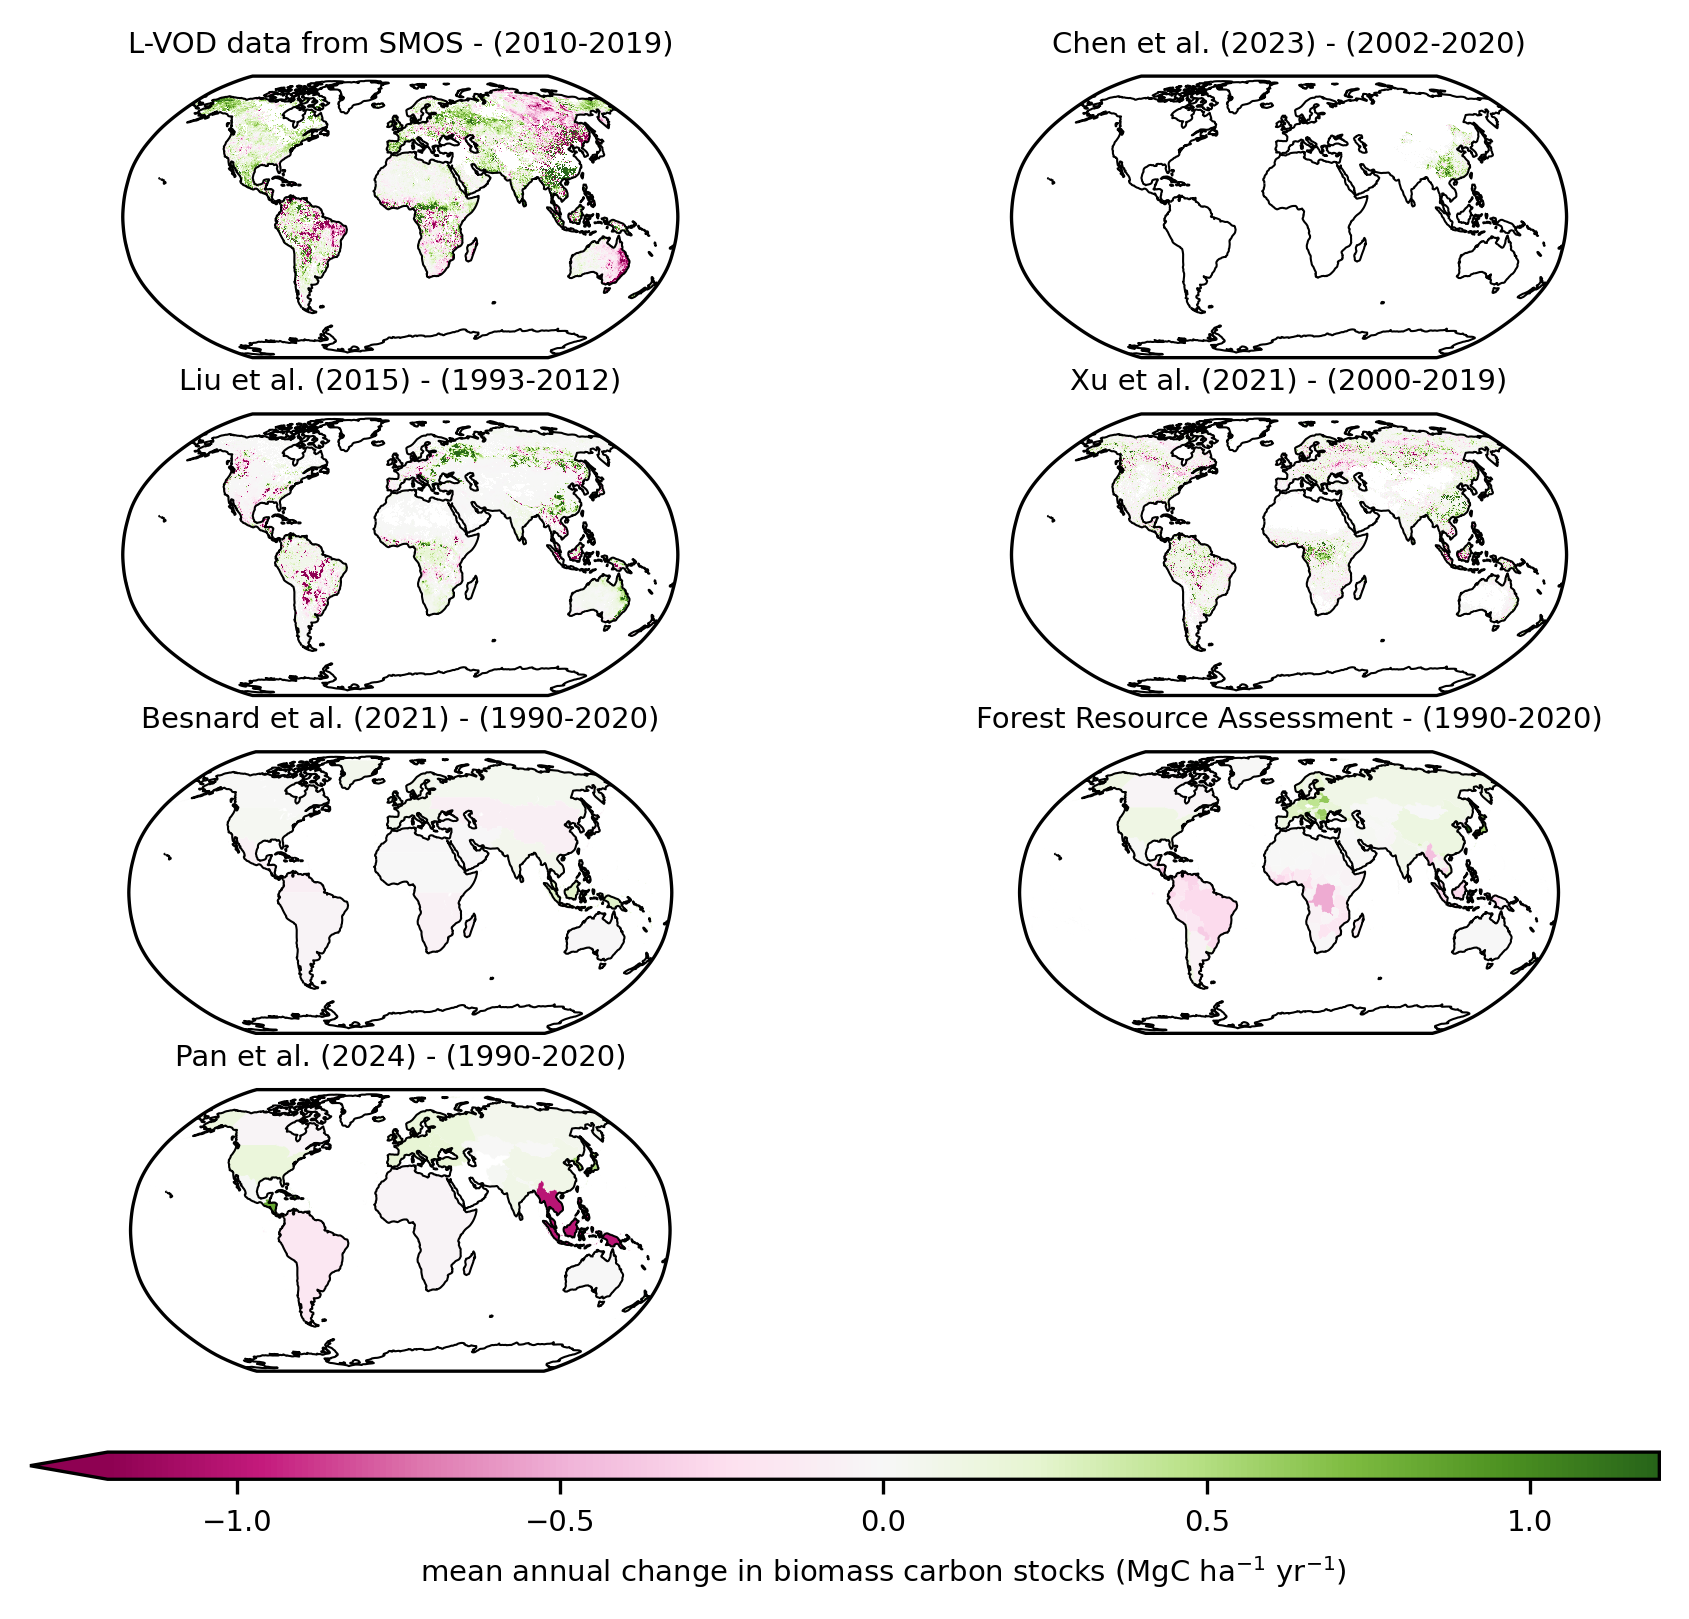

In [15]:
# load the world shapefile
path = get_path("naturalearth.land")
world_df = gpd.read_file(path)


# set up font sizes
font = {
        'size'   : 7}
matplotlib.rc('font', **font)

# set up the names of the data sources
source_names = {'xu': 'Xu et al. (2021)',
                'liu': 'Liu et al. (2015)',
                'LVOD': 'L-VOD data from SMOS',
                'chen': 'Chen et al. (2023)',
                'FRA': 'Forest Resource Assessment',
                'pan': 'Pan et al. (2024)',
                'besnard': 'Besnard et al. (2021)'
                }


# gridded data sources
files =  glob('../results/02_convert_AGB_TB/*.nc')
gridded_sources = np.unique([i.split('/')[-1].split('_')[0] for i in files])
regional_sources = ['besnard','FRA','pan']
# merge the LVOD datasets
gridded_sources = [i for i in gridded_sources if ('LVODmax' not in i) & ('LVODmin' not in i)]

# set up the figure and the gridspec
fig = plt.figure(figsize=[17.8/2.54,17.8/2.54],dpi=300,constrained_layout=True)
gs = gridspec.GridSpec(4,2)
axs = np.empty([4,2],dtype=object)

# run over gridded data sources
for i,source in enumerate(gridded_sources):
    # define the position of the panel in the figure
    j = i % 2
    k = i // 2
    # add the panel to the figure
    axs[k,j]= plt.subplot(gs[k,j],projection=ccrs.Robinson())
    
    # open all of the file associated with the source
    files =  glob(f'../results/02_convert_AGB_TB/{source}*.nc')
    # concatenate all data into a single xarray dataset
    da = xr.concat([xr.open_dataarray(f) for f in files],dim='variant',coords='minimal',compat='override')
    
    # take only non zero data
    da = da.where(da!=0)
    
    # calculate the mean rate of change across years and across variants
    da_mean = da.sum(dim='landcover').diff(dim='time').mean(dim='time').mean(dim='variant').rio.clip(world_df.geometry.values, world_df.crs).drop_vars(['spatial_ref'])

    # of the dataset is LVOD, divide by 9 to get the mean annual change
    if 'LVOD' in source:
        da_mean = da_mean/9
    
    # remove all variables that are not x and y
    for c in list(da_mean.coords.keys()):
        if c not in ['x','y']:
            da_mean = da_mean.drop_vars(c)    
    
    # set crs
    da_mean = da_mean.rio.write_crs('EPSG:4326')

    # plot the data    
    f = da_mean.where(da_mean!=0).drop_vars('spatial_ref').plot(ax=axs[k,j],transform=ccrs.PlateCarree(),vmin=-1.2,vmax=1.2,cmap='PiYG',rasterized=True,add_colorbar=False)
    
    # set the extent of the figure
    axs[k,j].set_global()
    
    # add coastlines
    axs[k,j].coastlines(lw=0.5)

    # set the title of the panel
    axs[k,j].set_title(f'{source_names[source]} - ({da.time.values[0]}-{da.time.values[-1]})',fontsize=7)

# remember the number of the last gridded figure
last_gridded_figure = i

# add regional sources
for i,source in enumerate(regional_sources):
    # define the position of the panel in the figure - start from the last gridded figure
    j = (last_gridded_figure+i+1) % 2
    k = (last_gridded_figure+i+1) // 2
    # add the panel to the figure
    axs[k,j]= plt.subplot(gs[k,j],projection=ccrs.Robinson())

    if source == 'FRA':
        
        # Load data
        FRA_data = pd.read_csv('../data/biomass/tubiello_et_al_2021/GF_GHG_ForestLand_Total_2020_ZENODO.csv', encoding='latin-1')

        # Fix the name for Sudan to match the FAO names
        FRA_data['AreaName'] = FRA_data['AreaName'].str.replace(' (former)', '', regex=False)

        # Take the stocks data and convert to a DataFrame with the region names as the index and years as columns
        FRA_data = FRA_data[FRA_data['ElementName'] == 'Carbon Stock (million tonnes)']
        FRA_data = FRA_data[['AreaName','Year','Value']].groupby(['AreaName','Year']).mean()['Value'].unstack()

        # convert units from MtC to GtC
        FRA_data = FRA_data/1e3

        #  calculate the mean rate of change across years
        FRA_data = pd.DataFrame(FRA_data.diff(axis=1).mean(axis=1),columns=['value'])
        
        # merge the FRA data with the country data to get the geometries
        plot_gpd = gpd.GeoDataFrame(FRA_data.merge(countries_data[['FAO_name','RECCAP reg','geometry']],left_index=True,right_on='FAO_name',how='left'))

        # set the panel title
        axs[k,j].set_title(f'{source_names[source]} - (1990-2020)',fontsize=7)
        
    elif source == 'pan':

        # load the data from Extended Data Table 2 from Pan et al. (2024)
        pan_data = pd.read_excel('../data/biomass/pan_et_al_2024/RDS-2023-0051/Data/Pan_etal_2024/Summary_Tables_Global_Forest_Inventory_1990-2020.xlsx', sheet_name='Table 2 Stock', skiprows=3,index_col=0)

        # parse the data for each year and concatenate them
        pan_data_parsed = pd.concat([parse_year_pan(pan_data,i,y) for i,y in enumerate([1990,2000,2010,2020])])    

        # replace left and right parentheses with empty string and remove any digits at the end of the string
        pan_data_parsed['region'] = pan_data_parsed['region'].str.replace(r'\(','').str.replace(r'\d+$', '', regex=True)

        # take the biomass pool and pivot the table to have each row as a region and each column as a year
        pan_data_biomass = pan_data_parsed[pan_data_parsed['pool'].str.contains('biomass')].pivot_table(index='region',columns='year',values='value',aggfunc='sum')

        # calculate the average rate of change per year
        pan_data_biomass = pan_data_biomass.diff(axis=1).mean(axis=1)/10
        pan_data_biomass.name = 'value'

        # define Asian and European Russia
        ne_scale_rank = gpd.read_file('../data/country_data/10m_cultural/ne_10m_admin_0_scale_rank.shp')
        RUS = ne_scale_rank[ne_scale_rank.sr_su_a3.isin(['RUE','RUA'])].dissolve(by='sr_su_a3')
        RUS.index = ['Asian Russia','European Russia']

        # define Alaska and CONUS
        alaska = ne_scale_rank[ne_scale_rank.sr_subunit.str.contains('Alaska')==1].dissolve(by='sr_subunit')
        CONUS = ne_scale_rank[(ne_scale_rank.sr_subunit.str.contains('Alaska|Hawaii')==0) & (ne_scale_rank.sr_adm0_a3=='USA')].dissolve(by='sr_adm0_a3')
        CONUS.index = ['United States']

        # add the regions to the Pan region gdf
        pan_regions_extended = pd.concat([pan_regions[['geometry']],RUS[['geometry']],alaska[['geometry']],CONUS[['geometry']]])

        # merge the data with the regions
        plot_gpd = pan_regions_extended.merge(pan_data_biomass,left_index=True,right_index=True)

        # set the panel title
        axs[k,j].set_title(f'{source_names[source]} - (1990-2020)',fontsize=7)
    else:
        # load the data 
        besnard_data = pd.concat([pd.read_csv(f) for f in glob('../results/02_convert_AGB_TB/*.csv')],keys=glob('../results/02_convert_AGB_TB/*.csv'))
        besnard_data.index.names = ['file','id']
        besnard_data = besnard_data.reset_index().set_index(['file','region']).drop(columns=['id','landcover'])

        # calculate the mean rate of change across years
        besnard_data = pd.DataFrame(besnard_data.groupby(['file','region']).sum().mean(axis=1).groupby('region').mean()/1e15,columns=['value'])
        
        # merge the data with the GFED regions data to get the geometries
        plot_gpd = gpd.GeoDataFrame(besnard_data.merge(GFED_region_names,left_index=True,right_on='name',how='left').merge(polygonize(GFED_regions),on='id'))
        
        # set the panel title
        axs[k,j].set_title(f'{source_names[source]} - (1990-2020)',fontsize=7)
        
    # calculate the rate of change per unit area in units of MgC ha^-1 yr^-1
    plot_gpd['mean_rate'] = (plot_gpd['value']*1e15/100/plot_gpd.to_crs(6933).area).astype(float)

    # plot the regional data
    plot_gpd.plot(ax=axs[k,j],transform=ccrs.PlateCarree(),cmap='PiYG',rasterized=True,column='mean_rate',vmin=-1.2,vmax=1.2)
    
    # set the extent
    axs[k,j].set_global()

    # add coastlines
    axs[k,j].coastlines(lw=0.5)

# add colorbar and set its label
cbar = fig.colorbar(f, ax=list(axs.flatten())[0:7], orientation='horizontal', pad=0.05, aspect=60,extend='min')
cbar.set_label('mean annual change in biomass carbon stocks (MgC ha$^{-1}$ yr$^{-1}$)',fontsize=7)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s1_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s1_{d}.svg',dpi=300)

## Figure S2

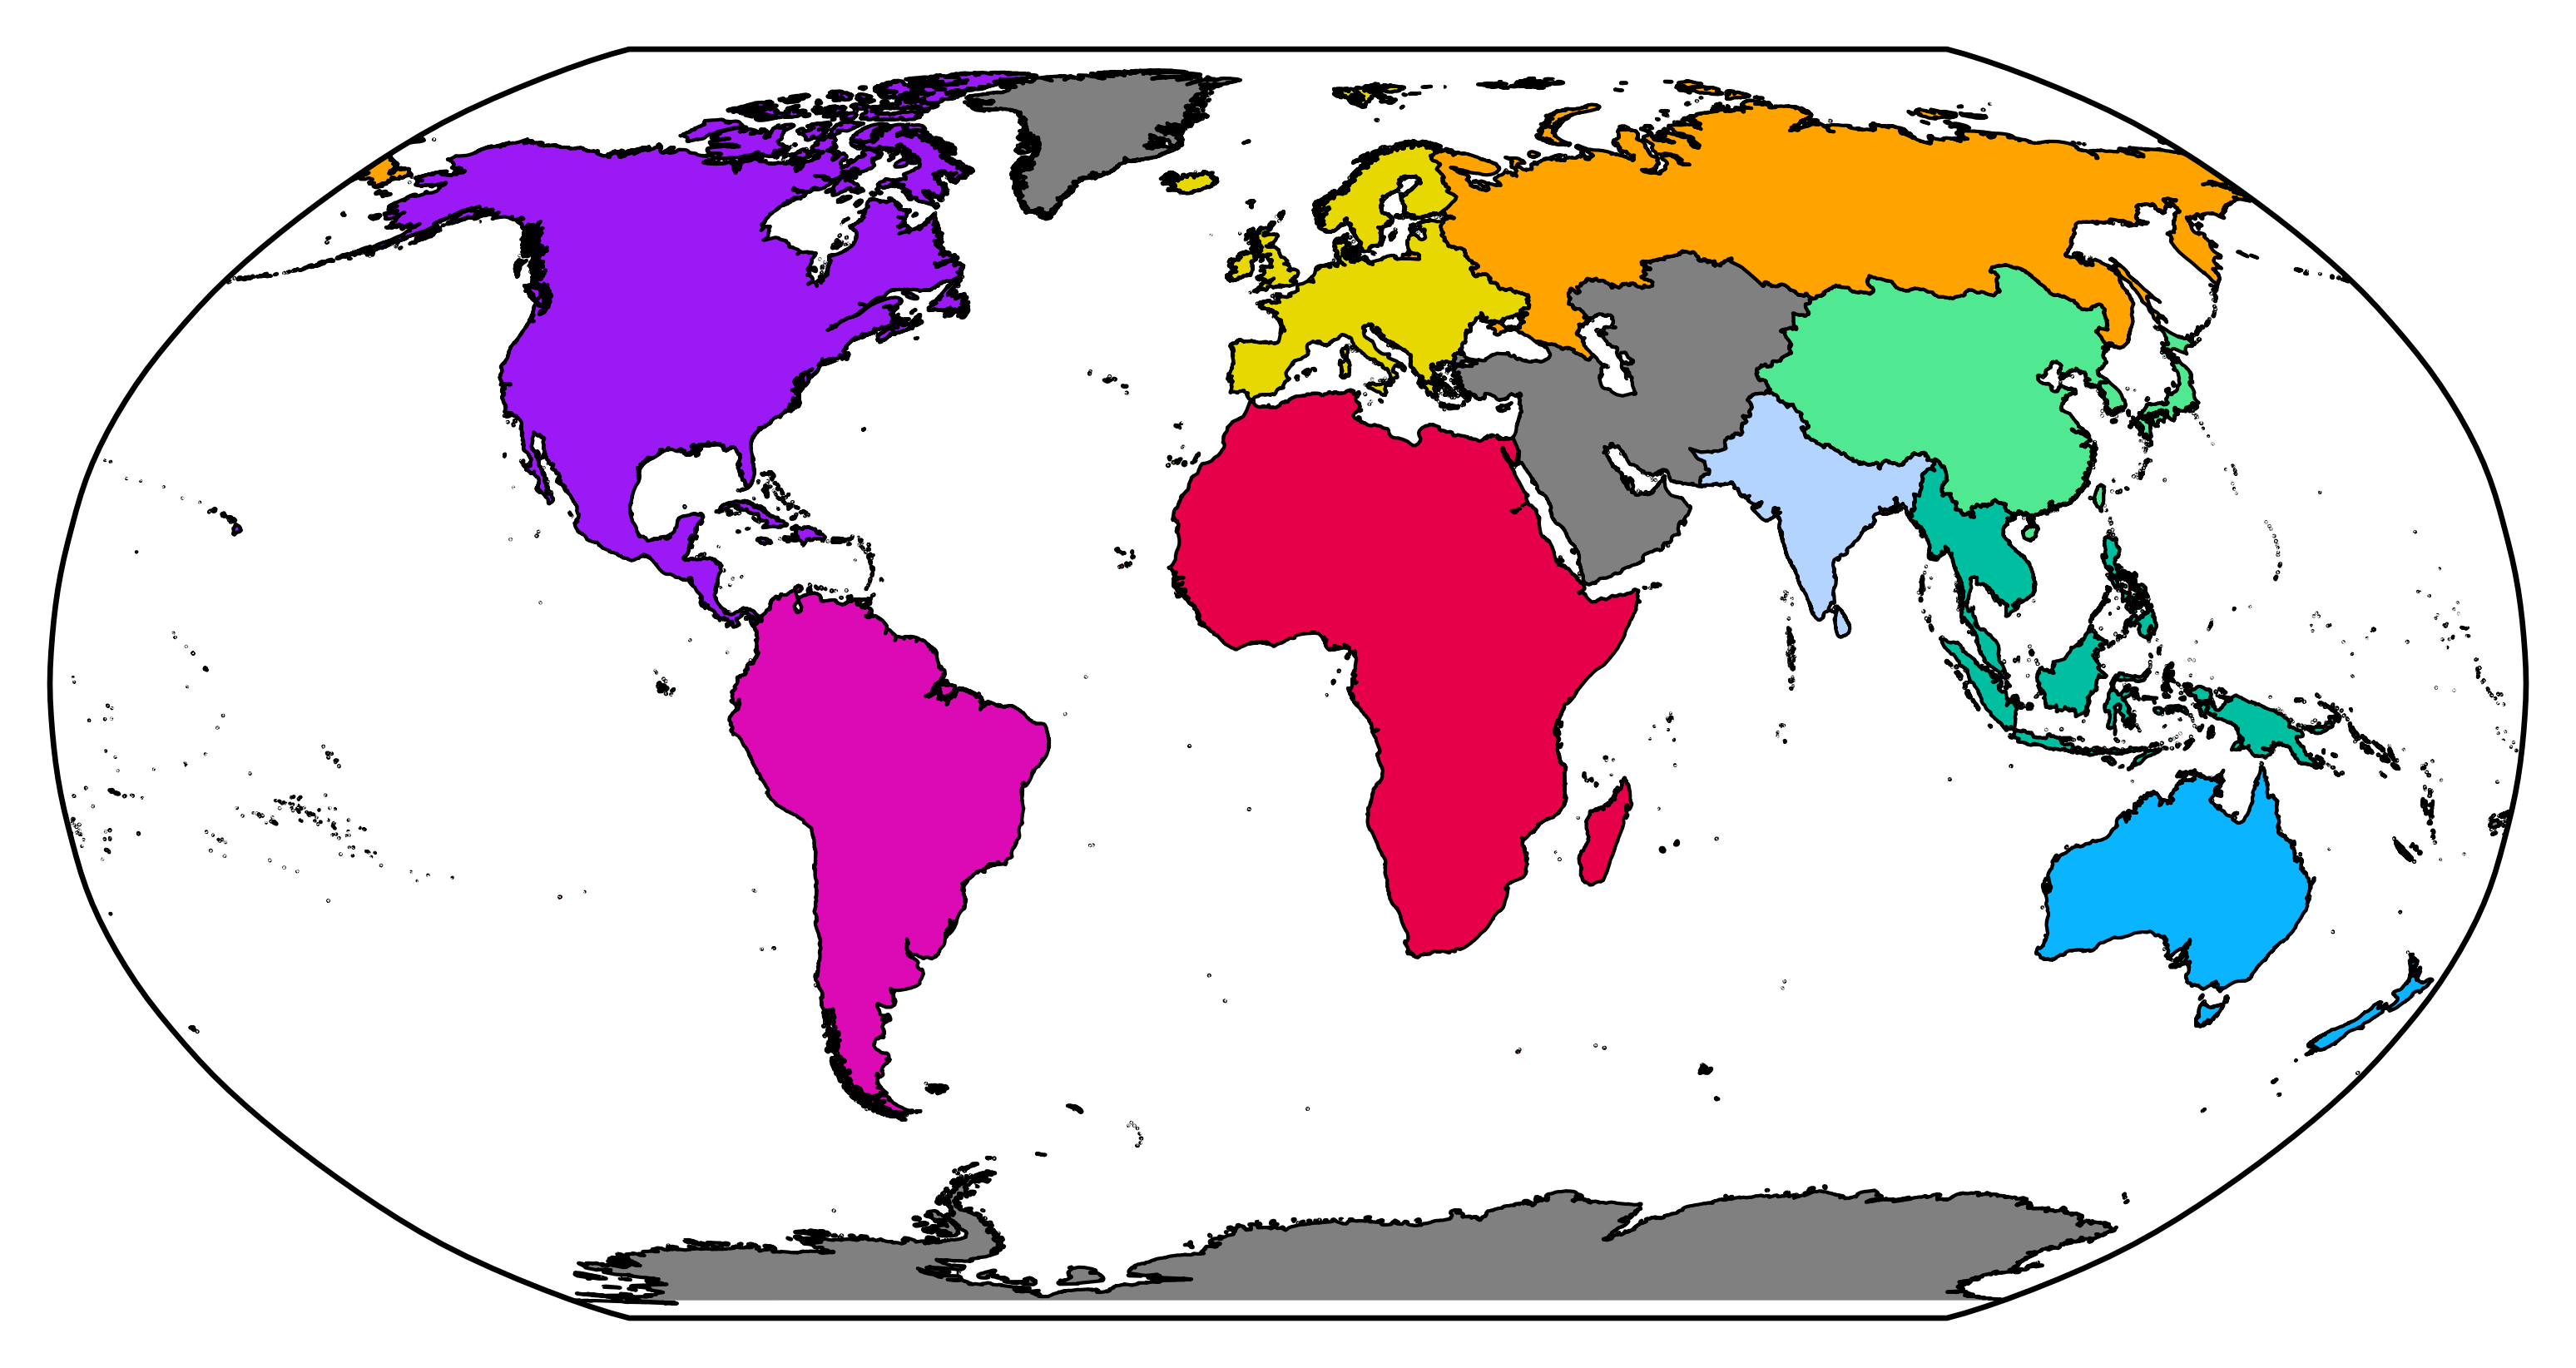

In [16]:
# set up the figure, and colors
fig = plt.figure(dpi=600)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
cs = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5",'grey', "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

# plot the regions
for i,c in enumerate(cs):
        reccap_regions.iloc[i:i+1].plot(facecolor=c,edgecolor='k',lw=0.5,ax=ax,transform=ccrs.PlateCarree())

## Figure S4

### Generate the distributions

In [17]:
# set the start year
start_year =1992

# define time bins
time_bins = pd.DataFrame(pd.Series([np.arange(start_year+1,2001),np.arange(2001,2011),np.arange(2011,2020)]),columns=['year'])

# create time bin names
time_bin_names = time_bins.apply(lambda x: '-'.join([str(x.iloc[0].min()),str(x.iloc[0].max())]),axis=1)

# set the index to be the names
time_bins.index = time_bin_names

# calculate the frequency of each time bin
year_bin_freq = (time_bins.apply(lambda x: len(x['year']),axis=1)/time_bins.apply(lambda x: len(x['year']),axis=1).sum())

In [18]:
def create_dist(df:pd.DataFrame,time_bin:np.array,bin_vars:list,n_samples=1000) -> list:
    """
    Create random samples from the data for each time bin. For each sample, we choose randomly one method from each source and then one source.
    If the original sample has missing values, we fill them with the values from the second sample. 

    Parameters:
    df: pd.DataFrame
        The data frame with the data
    time_bin: np.array
        The time bin to sample from
    bin_vars: list
        The variables to use as columns
    n_samples: int
        The number of samples to create

    Returns:
    list
        A list with the samples
    """

    # select the data that for the years in time_bin, drop missing values and calculate make the bin_vars as columns
    df_tb = df.loc[:,df.columns.isin(time_bin)].mean(axis=1).dropna().unstack(bin_vars)
   
    # define the result list
    res = []

    # for each sample
    for i in range(n_samples):
        
        # sample one method from each source, then sample one source and take the values
        sample = df_tb.groupby('source').sample(1).sample(1).T.iloc[:,0]

        # while the sample doesn't cover all regions and lancovers (has nan values)
        while sample.isna().any():
            # sample again
            sample2 = df_tb.groupby('source').sample(1).sample(1).T.iloc[:,0]
            
            # merge the two samples
            merged_samples = pd.concat([sample,sample2],axis=1,keys=['first_sample','second_sample'])

            # fill the missing values in the original sample with the values from the second sample
            sample = merged_samples['first_sample'].fillna(merged_samples['second_sample'])
                
        # add the sample to the result list
        res.append(sample)

    return res


def sort_df(df:pd.DataFrame)->pd.DataFrame:
    """
    Sort the columns of a data frame based on the sum of the values in the columns

    Parameters:
    df: pd.DataFrame
        The data frame to sort

    Returns:
    pd.DataFrame
        The sorted data frame
    """
    
    # sort the columns based on the sum of the values
    sorted_df = df.loc[:,df.sum().sort_values(ascending=False).index]
    
    # rename columns
    sorted_df.columns = range(df.shape[1])
    return sorted_df


In [19]:
# the basic variables that each sample should have are region and landcover
bin_vars=['region','landcover']

# define the number of samples to take
n = 10_000

# generate for each time period N random samples of the data
trajectories = time_bins.apply(lambda x: create_dist(biomass_data_obs,x['year'],bin_vars=bin_vars,n_samples=n),axis=1)

# convert the result into a dataframe
trajectories = pd.concat([pd.concat(i,axis=1,keys=range(n)) for i in trajectories.values],keys=time_bins.index)

# set the index names
trajectories.index.names=['time_bin'] + bin_vars

### Plot the distribution for the 90s in South America

[Text(0.5, 0, 'change in carbon stocks (GtC yr$^{-1}$)'),
 Text(0, 0.5, 'density')]

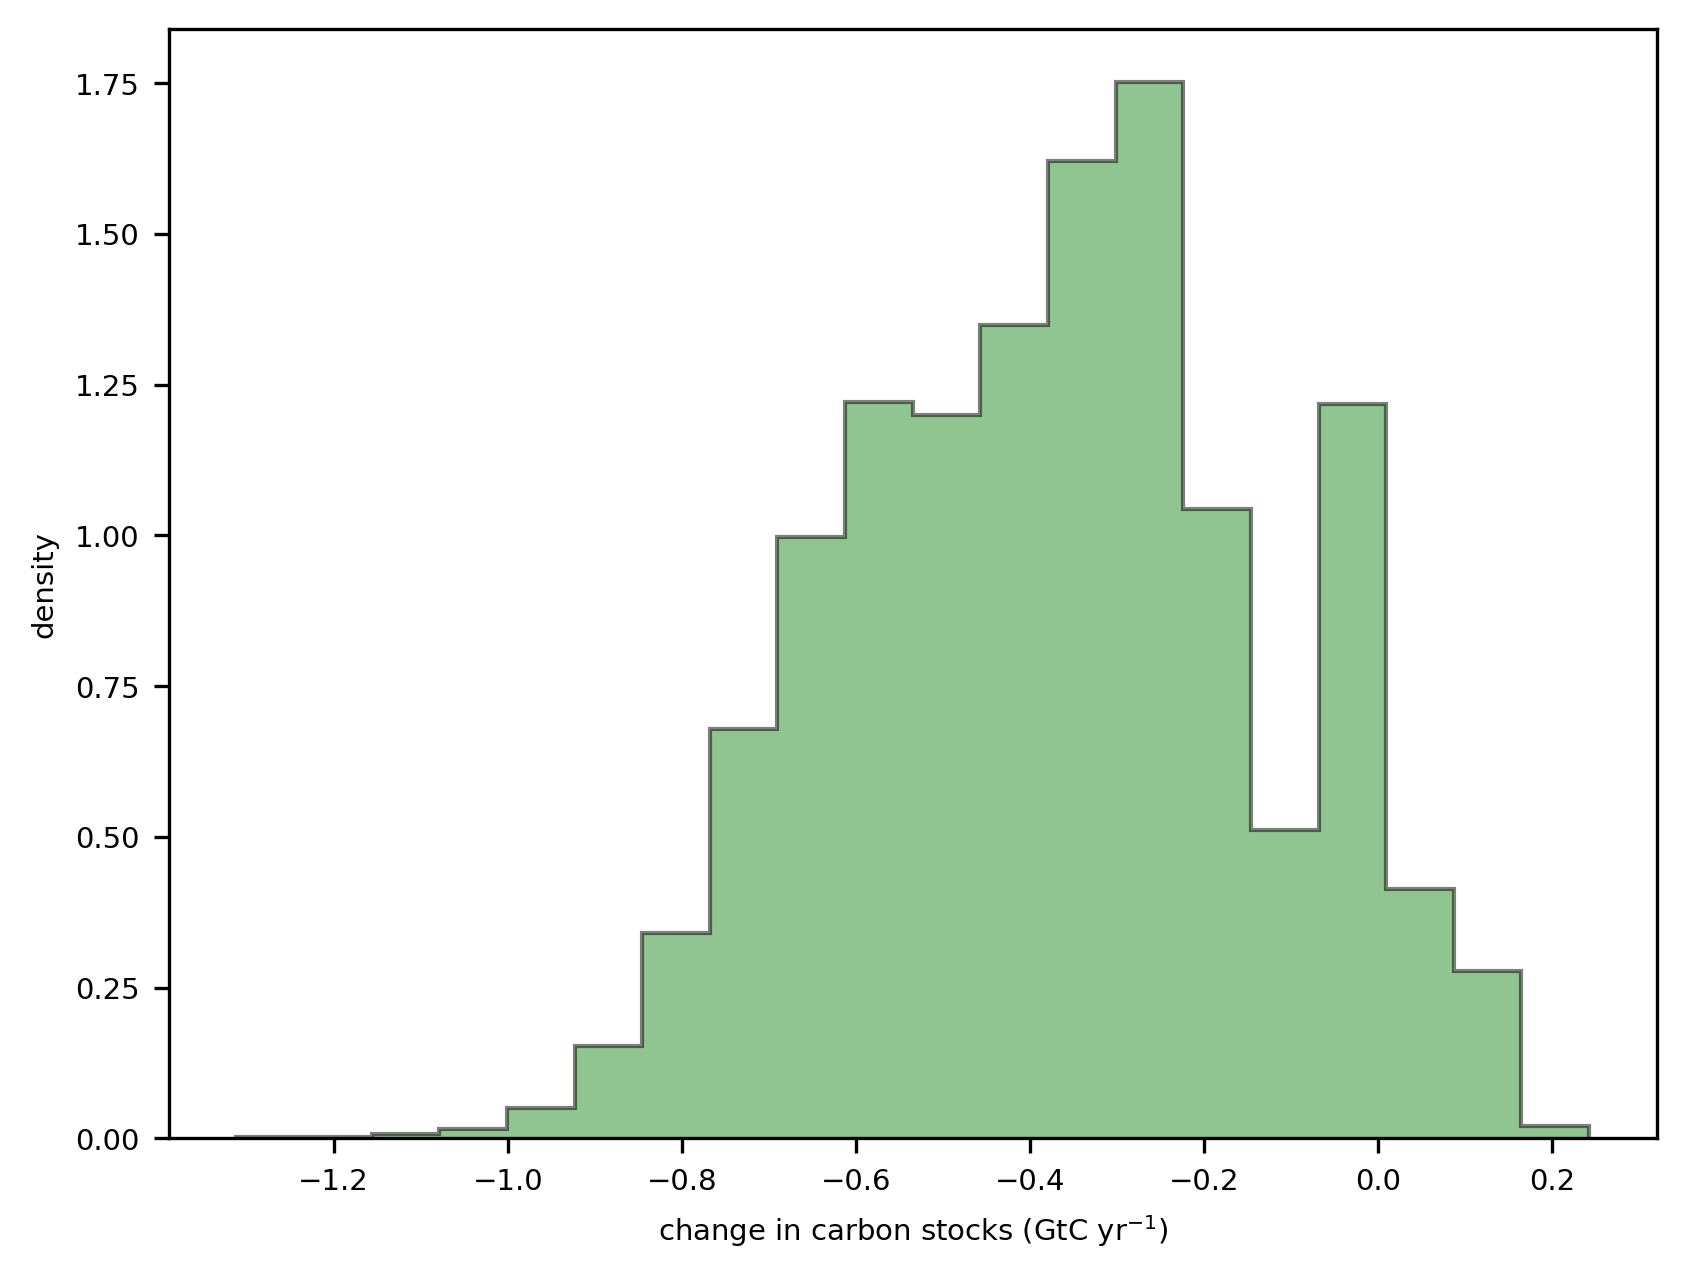

In [20]:
# bin the trajectories based on time period and region
trajectories_regional = trajectories.groupby(['time_bin','region']).sum()/1e15

# add 30% random uncertainty to each estimate
regional_dists = trajectories_regional + np.random.normal(0,0.3*trajectories_regional.abs())

# set the figure
fig, ax = plt.subplots(dpi=300)

# plot the histrograms
regional_dists.loc[('1993-2000','South America')].plot.hist(density=True,bins=20,ax=ax,color='k',alpha=0.5,histtype='step')
regional_dists.loc[('1993-2000','South America')].plot.hist(density=True,bins=20,ax=ax,color='forestgreen',alpha=0.5)
ax.set(xlabel='change in carbon stocks (GtC yr$^{-1}$)',ylabel='density')

## Figure S5

In [21]:
# define the time period edges and their names
year_bins = [1992,2000,2010,2019]
period_names = ['-'.join([str(j+1),str(year_bins[i+1])]) for i,j in enumerate(year_bins[:-1])]

# group the biomass data by data source and method of analysis and sum across regions and lancover types
source_method_sums  = biomass_data_obs.groupby(['source','method']).sum()

# replace zeros with nans
source_method_sums[source_method_sums==0] = np.nan

# cut the columns (years) into the different time periods
source_method_sums.columns = pd.cut(source_method_sums.columns,bins=year_bins,labels=period_names)
source_method_sums.columns.name = 'period'

# calculate the mean and count of the values for each source and method
source_method_periods = source_method_sums.stack().groupby(['source','method','period'],observed=False).agg(['mean','count'])

# take only the sources and methods that have at least 3 values
source_method_periods = (source_method_periods[source_method_periods['count']>=3]['mean']/1e15).reset_index()


## add 30% uncertainty to each method mean estimate

# define the number of samples, CV of the estimate (30%) and the result container
cv =0.3
n=1000
res =[]

# for each combination of source and method
for i,r in source_method_periods.iterrows():

    # create a new data frame with the mean value repeated n times
    new_df = pd.concat([r]*n,axis=1).T

    # add random noise to the mean value
    new_df['mean'] = new_df['mean'] + np.random.normal(0,np.abs(r['mean'])*cv,n) 

    # add the new data frame to the result list
    res.append(new_df)

# concatenate the results
source_method_periods_with_error = pd.concat(res)

# add a column to designate if the estimate is global or not (FRA, Pan et al. and Chen et al. are not)
source_method_periods_with_error['global'] = 'global'
source_method_periods_with_error.loc[source_method_periods_with_error['source'].isin(['FRA','pan','chen']), 'global'] = 'partial'

# get the mean estimate for each period for changes in living biomass 
mean_period_estimate = obs_periods.loc[pd.IndexSlice[:,'delta_B','Global',:]].unstack().drop(columns='1993-2019')/1e15

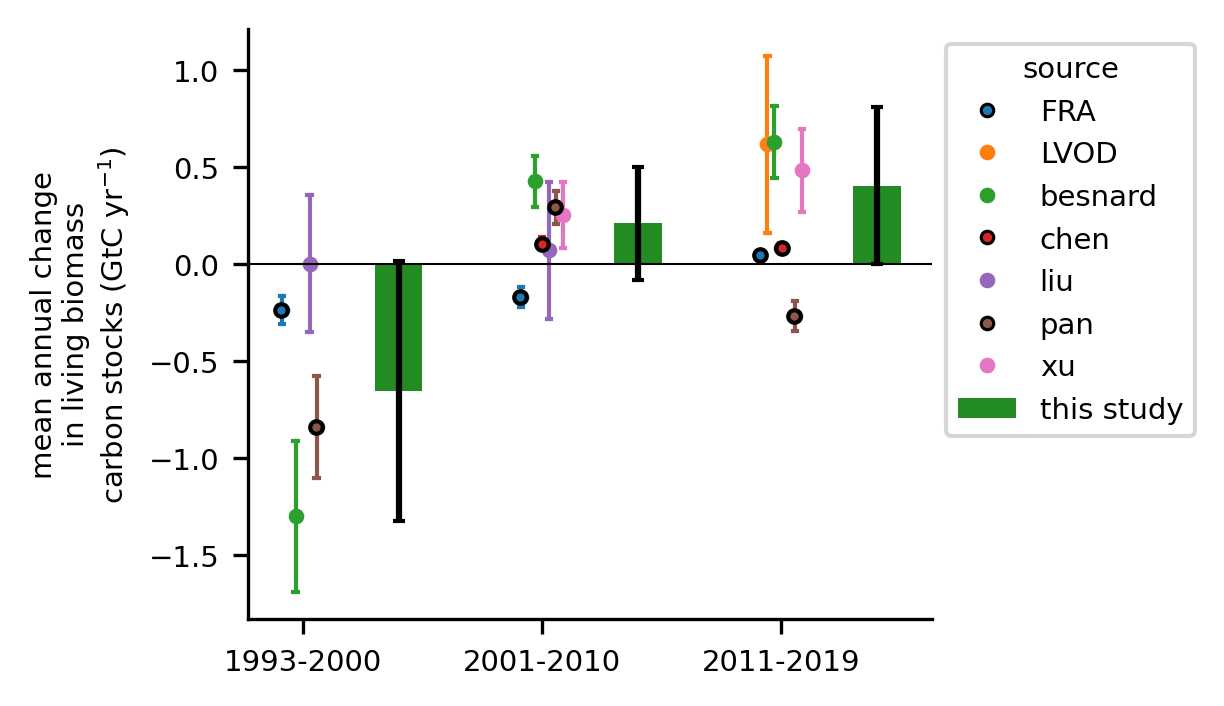

In [22]:
# set up the fonts and figure
font = {'size'   : 7}
matplotlib.rc('font', **font)
fig,ax =plt.subplots(dpi=300,figsize=[4.76/1.2,2.24],constrained_layout=True)

# plot the estimates from each data source
sns.pointplot(data=source_method_periods_with_error,dodge=True,x='period',y='mean',hue='source',ls='none',ax=ax,errorbar='sd',capsize=0.02,markersize=3,linewidth=1)

# plot the mean estimate as a bar plot
ax.bar(np.arange(0.4,3.4),mean_period_estimate.loc['mean'],width=0.2,yerr=mean_period_estimate.loc['std'],color='forestgreen',capsize=1.5)
ax.axhline(0,c='k',lw=0.5,ls='-')


# make the partial estimates lower in the legend and add the total estimate to the legend
handles, labels = ax.get_legend_handles_labels()

handles = handles + [Rectangle((0,0),1,1,fc="forestgreen", fill=True, edgecolor='none', linewidth=0)]
for i,label in enumerate(labels):
    if label in ['FRA','pan','chen']:
        handles[i].set_markeredgecolor('k')
labels = labels + ['this study']
ax.legend(handles, labels, bbox_to_anchor=(1, 1), title='source')

# remove top and right spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# set the axes labels
ax.set(xlabel='',ylabel='mean annual change\nin living biomass\ncarbon stocks (GtC yr$^{-1}$)',xticks=[0,1,2],xticklabels=['1993-2000','2001-2010','2011-2019'])

# draw on the same figure the partial estimates with a black outline
mapping = {'1993-2000':0,'2001-2010':1,'2011-2019':2}
offsets = {'1993-2000':{'FRA':-0.09,'pan':0.055},'2001-2010':{'FRA':-0.09,'chen':0.002,'pan':0.055},'2011-2019':{'FRA':-0.09,'chen':0.002,'pan':0.055}}
cols = {'FRA':'C00','pan':'C05','chen':'C03'}
for partial_source in source_method_periods_with_error[source_method_periods_with_error['global']=='partial']['source'].unique():
    subset = source_method_periods_with_error[source_method_periods_with_error['source']==partial_source]
    means = subset.groupby('period')['mean'].mean()

    xs = [mapping[x] + offsets[x][partial_source]  for x in means.index]
    ax.scatter(x = xs,y=means.values,s=9,edgecolor='k',zorder=11,color=cols[partial_source])

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s5_{d}.svg',dpi=300)
plt.savefig(f'../figures/fig_s5_{d}.png',dpi=300)

## Figure S6

In [23]:
def get_mask_method(info:pd.Index,filter) -> pd.Index:
    """
    Generate a mask for the data based on the method name

    Parameters:
    info: pd.Index
        The series with the method names
    filter: 
        The method name to filter by

    Returns:
    pd.Index
        The mask for the data
    """

    # get the forest splitting method and the RMF method from the inputs
    forest_method,RMF_method = filter

    # define masks for the forest and RMF method
    forest_split_mask = info.str.contains(forest_method+'|regional') # for forest, include also regional splits
    RMF_mask = info.str.contains(RMF_method)

    # define masks for the data with no forest and RMF methods
    no_RMF = (~info.str.contains('|'.join(BGB)))
    no_forest = (~info.str.contains('|'.join(forest)))

    # take only data with the exact same forest and RMF method, or data with no RMF method but the same forest method, or data with no forest and no RMF method
    mask = (forest_split_mask & RMF_mask) | (no_RMF & forest_split_mask) | (no_RMF & no_forest)

    return mask

def get_name_method(filter:list) -> list:
    """
    Generate the name for the method based on the method combination

    Parameters:
    filter: list
        The method combination

    Returns:
    list
        The name for the method combination
    """

    return [' + '.join(i).replace('_','') for i in filter]

def run_annual_cum_sens(biomass_data_obs:pd.DataFrame,info:Union[pd.Index,tuple],get_mask:Callable,sens_comb:list,get_name:Callable) -> pd.DataFrame:
    """
    Calculate the annual cumulative change in biomass carbon stocks for different forest splitting and RMF methods

    Parameters:
    biomass_data_obs: pd.DataFrame
        The data frame with the biomass data
    info: pd.Index
        The series with the method names
    get_mask: function
        The function that generates the mask for the data
    sens_comb: list
        The list with the different combinations of filters to disect the data by
    get_name: function
        The function that generates the name for the method

    Returns:
    pd.DataFrame
        The annual cumulative change in biomass carbon stocks for different forest splitting and RMF methods
    """

    # define the container for the results
    sens = []

    # for each sensitivity variant
    for filters in sens_comb:

        # get the mask using the function
        mask = get_mask(info,filters)

        # take only the data that matches the mask
        data = biomass_data_obs[mask]

        # calculate the average annual rate of change in biomass stocks
        result = data.groupby(['source','region','landcover']).mean()\
                                                .groupby(['region','landcover']).mean()\
                                                .groupby(['region']).sum()\
                                                .loc[:,1993:2019].sum()
        # append the results to the container
        sens.append(result)

    # concatenate the results and divide by 1e15 to get GtC and set the label of the columns
    sens = pd.concat(sens,axis=1,keys=get_name(sens_comb))/1e15

    # add the year 1992, sort by year and calculate the cumulative sum
    sens.loc[1992] = 0
    sens = sens.sort_index()
    sens = sens.cumsum()

    return sens

In [24]:
def plot_annual_cum_sensitivity(obs_annual_cum_mean:pd.DataFrame, sens:pd.DataFrame) -> plt.Figure:
    '''
    Plot the annual cumulative change in carbon stocks for the different sensitivity analysis

    Parameters:
    obs_annual_cum_mean: pd.DataFrame
        The mean annual cumulative change in carbon stocks with all estimates
    sens: pd.DataFrame
        The mean annual cumulative change in carbon stocks for the different sensitivity analysis

    Returns:
    plt.Figure
        The figure with the plot
    '''

    # set the figure fonts and colors
    font = {'size'   : 7}
    colors = ['forestgreen','k']
    matplotlib.rc('font', **font)
    fig,ax =plt.subplots(dpi=300,figsize=[8.5/2.54,6/2.54],constrained_layout=True)

    # plot the data with all estimates
    for col,c in zip(obs_annual_cum_mean.columns,colors):
        if col == 'delta_C':
            # only plot the mean estimate of the delta_C
            obs_annual_cum_mean[col].plot(color=c,ax=ax,legend=False,label='_Hidden')

        # plot uncertainty ranges
        ax.fill_between(obs_annual_cum_mean.index,obs_annual_cum_mean[col]-obs_annual_cum_std[col],obs_annual_cum_mean[col]+obs_annual_cum_std[col],alpha=0.2,color=c,lw=0,label='_Hidden')

    # draw a horizontal line at 0
    ax.axhline(0,c='grey',zorder=0,ls='--')

    # set the axes labels and limits
    ax.set(ylabel='cumulative change in carbon pool (GtC)',ylim=[-12,55],xlabel='')

    # add text labels
    ax.text(2013,45,'change in land\ncarbon stocks',ha='center')
    ax.text(2014,7.5,'change in\nbiomass stocks',ha='center',color='forestgreen')
    ax.annotate('start of\nstudy period',xy =[1992,0], xytext= [1992,15],arrowprops=dict(facecolor="0.5",arrowstyle='->',connectionstyle='arc3,rad=0.3',shrinkB=2),ha='left')#,ls='--',lw=1,color='k')

    # plot the estimate for delta_B with all estimates with a dashed line
    ax.plot(obs_annual_cum_mean['delta_B'],label='all sources',color='forestgreen',zorder=10,ls='--')

    # plot the different sensitivity analysis data
    ax.plot(sens,label=[i for i in sens.columns])

    # add legend
    ax.legend(fontsize=6,loc='upper left')

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

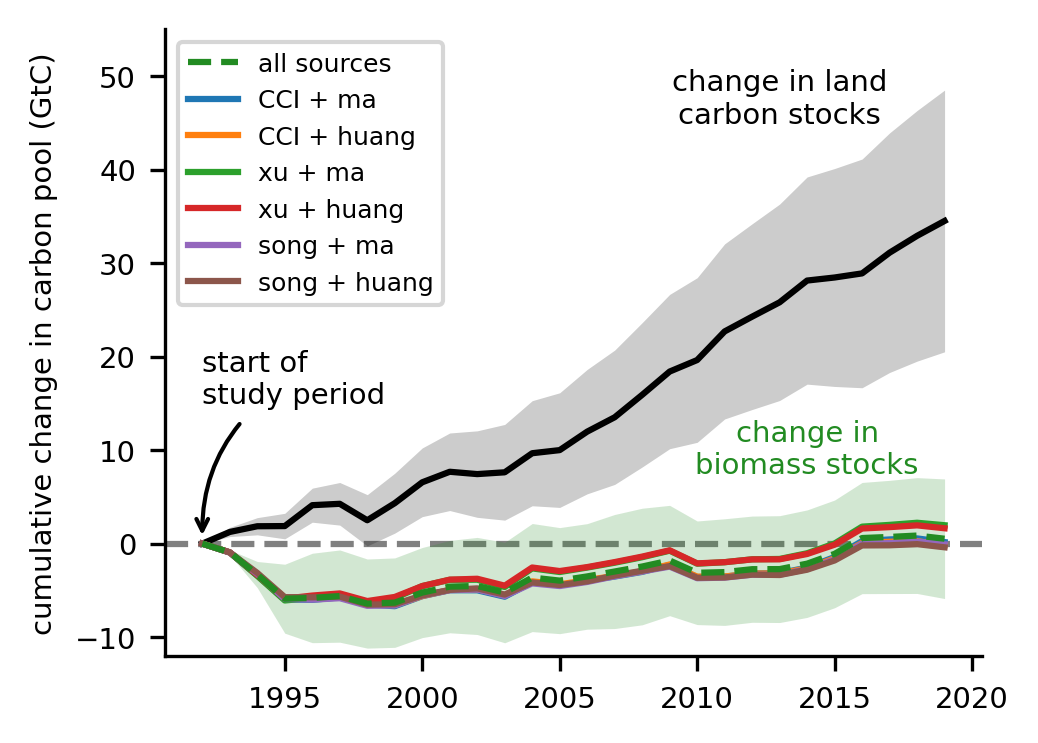

In [25]:

# define the different forest splitting and RMF methods and their combinations
forest = ['CCI','xu','song']
BGB = ['_ma_','_huang_']
comb = list(product(forest,BGB))

# extract from the data the part of the method name that contains that methods
method_data = biomass_data_obs.index.get_level_values('method').str.split('_').str[1:].str.join('_')

# run the sensitivity analysis
method_sens = run_annual_cum_sens(biomass_data_obs,method_data,get_mask_method,comb,get_name_method)

# plot the sensitivity analysis
fig_s6 = plot_annual_cum_sensitivity(obs_annual_cum_mean,method_sens)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s6_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s6_{d}.svg',dpi=300)

## Figure S7

In [26]:
def get_mask_source(info:pd.Index,filter) -> pd.Index:
    """
    Generate a mask for the data based on the source name

    Parameters:
    info: pd.Index
        The series with the method names
    filter: 
        The method name to filter by

    Returns:
    pd.Index
        The mask for the data
    """

    # get the forest splitting method and the RMF method from the inputs
    mask = (~info.str.contains(filter))

    return mask

def get_name_source(filter:list) -> list:
    """
    Generate the name for the source sensitivity analysus

    Parameters:
    filter: list
        The source list

    Returns:
    list
        The name for the sources
    """

    return ['w/o '+ i for i in filter]

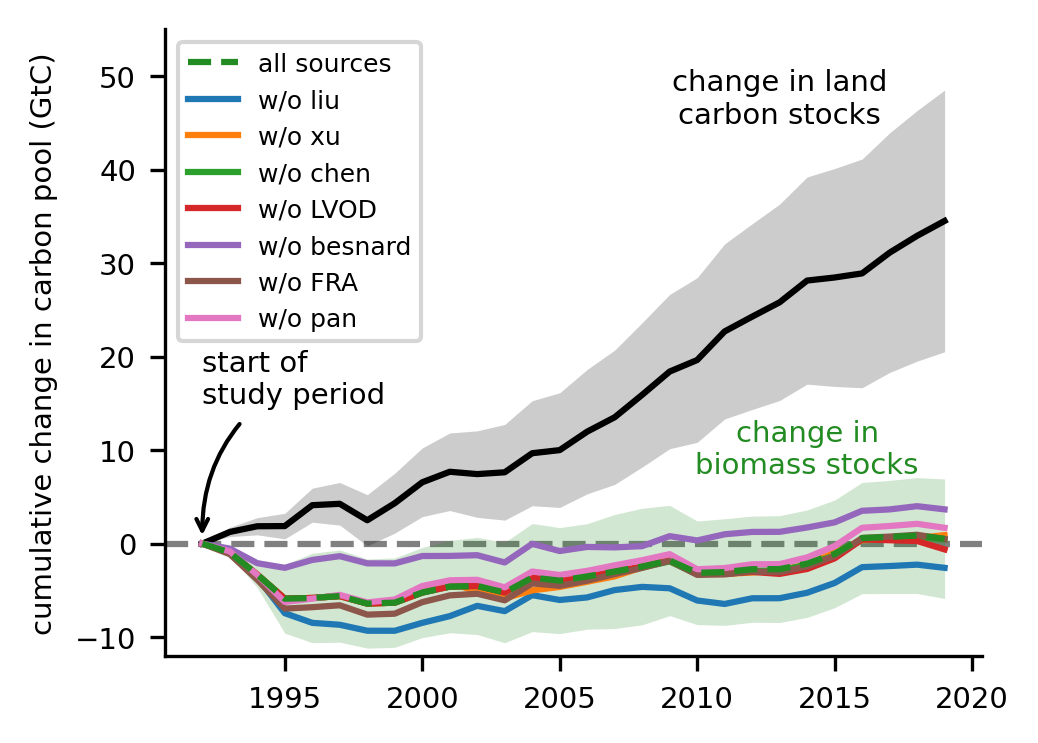

In [27]:

# define the different forest splitting and RMF methods and their combinations
sources = list(biomass_data_obs.index.get_level_values('source').unique())

# extract from the data the part of the method name that contains that methods
source_data = biomass_data_obs.index.get_level_values('source')

# run the sensitivity analysis
source_sens = run_annual_cum_sens(biomass_data_obs,source_data,get_mask_source,sources,get_name_source)

# plot the sensitivity analysis
fig_s7 = plot_annual_cum_sensitivity(obs_annual_cum_mean,source_sens)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s7_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s7_{d}.svg',dpi=300)

## Figure S8

In [28]:
# unpack the mean and std for the different pools from observations and the models
obs_annual_cum_mean_1995 = obs_annual_cum_1995.loc[pd.IndexSlice['mean', :, :, ]].unstack('pool')/1e15
obs_annual_cum_std_1995 = obs_annual_cum_1995.loc[pd.IndexSlice['std', :, :, ]].unstack('pool').fillna(0)/1e15
DGVMs_annual_cum_mean_1995 = DGVMs_annual_cum_1995.loc[pd.IndexSlice['mean', :, :, ]].unstack('pool')/1e15
DGVMs_annual_cum_std_1995 = DGVMs_annual_cum_1995.loc[pd.IndexSlice['std', :, :, ]].unstack('pool')/1e15

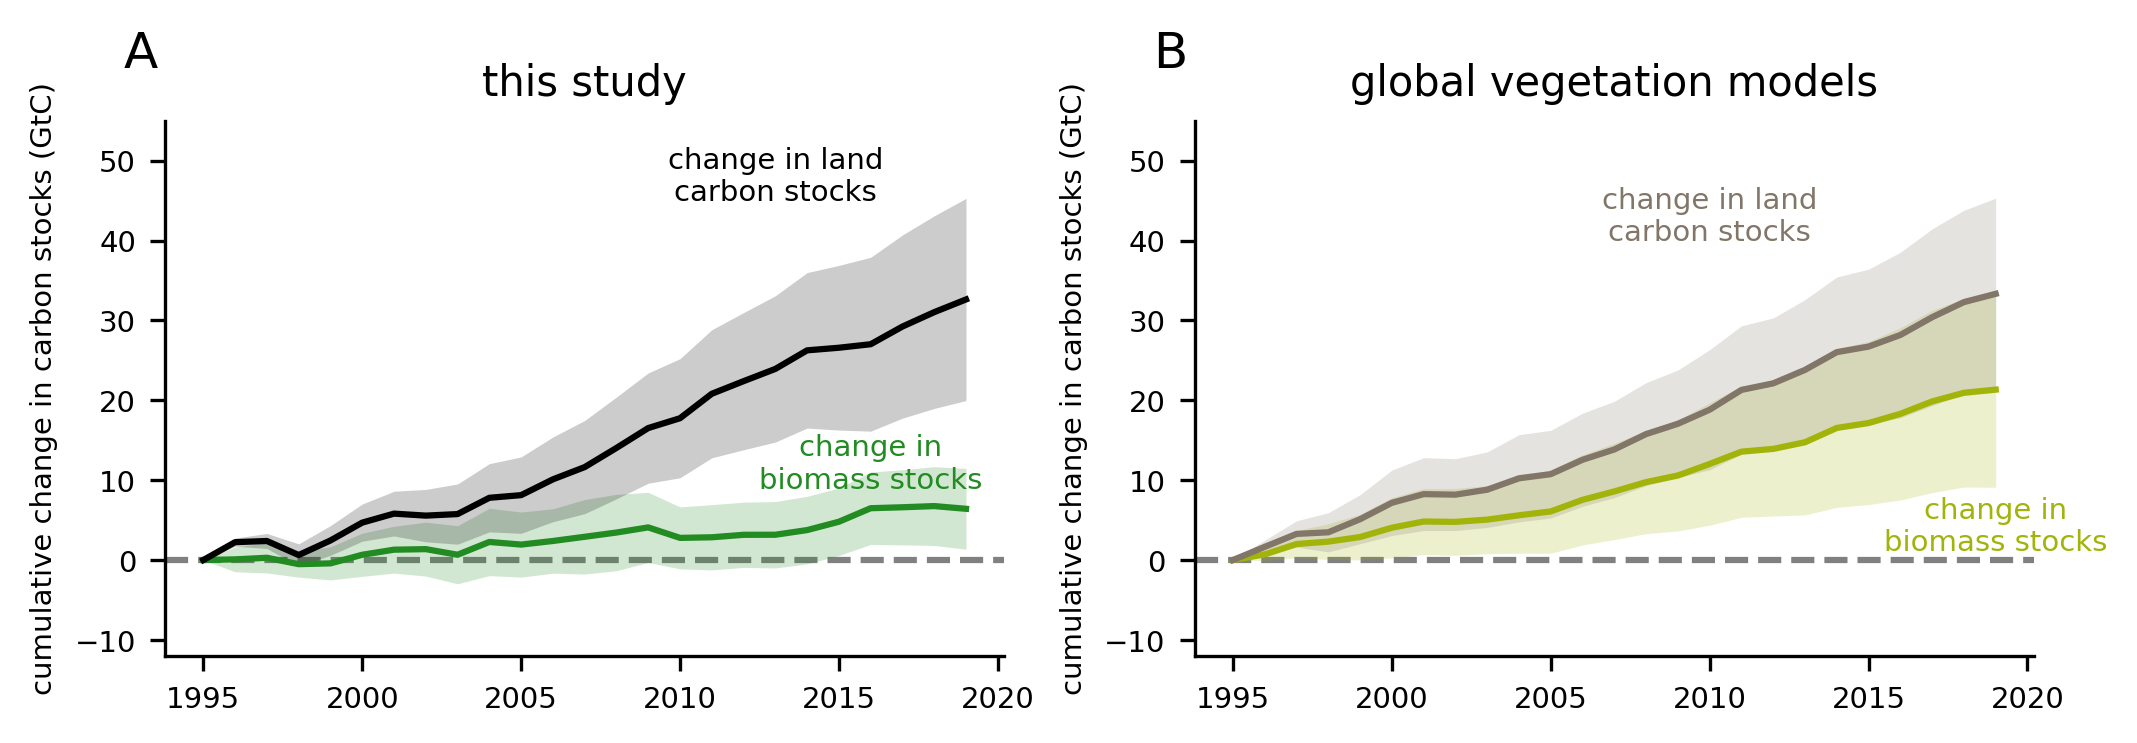

In [29]:
# generate figure
fig = generate_fig1(obs_annual_cum_mean_1995,obs_annual_cum_std_1995,DGVMs_annual_cum_mean_1995,DGVMs_annual_cum_std_1995)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s8_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s8_{d}.svg',dpi=300)

## Figure S9

In [30]:
def get_ratios(DGVM:pd.DataFrame, obs:pd.DataFrame) -> Tuple[pd.DataFrame,pd.Series,pd.Series]:
    """
    Calculate the ratios of the mean annual rate of change in biomass carbon stocks and total carbon stocks for DGVMs and observations

    Parameters:
    DGVM: pd.DataFrame
        The data frame with the DGVM data
    obs: pd.DataFrame
        The data frame with the observational data

    Returns:
    pd.DataFrame
        The ratios of rate of change in living biomass and total carbon stocks in the DGVMs
    pd.Series
        The mean ratios of rate of change in living biomass and total carbon stocks in the observations
    pd.Series
        The standard deviation of the ratios of rate of change in living biomass and total carbon stocks in the observations
    """

    # calculate the ratio for each model for each period
    DGVM_ratios = (DGVM.loc['delta_B']/DGVM.loc['delta_C'])['mean'].reset_index(name='ratio')

    # extract the global data for observations
    global_obs = obs.loc[pd.IndexSlice[:,['delta_B','delta_C'],'Global',:]]
    global_obs.index = global_obs.index.droplevel('time')

    # calculate the mean rations
    ratios = global_obs.loc[('mean','delta_B')]/global_obs.loc[('mean','delta_C')]

    # calculate the CVs of the observations
    CVs = global_obs.loc['std']/global_obs.loc['mean']

    # propagate the uncerainties of CVs of delta_B and delta_C to the CV of the ratio
    ratio_CV = np.sqrt((CVs.unstack()**2).sum())

    # calculate the uncertainty of the ratio using the CV
    ratio_std = ratios.abs()*ratio_CV

    return DGVM_ratios,ratios,ratio_std

In [67]:
# Assuming trendy_global_cVeg, trendy_global_nbp, and obs_periods are defined
# Similar to your existing setup

def generate_fig_s9_s10(DGVM_ratios:pd.DataFrame,ratios:pd.Series,ratio_std:pd.Series) -> plt.Figure:
    '''
    Generate the figure for the ratios of the mean annual rate of change in biomass carbon stocks and total carbon stocks for DGVMs and observations

    Parameters:
    DGVM_ratios: pd.DataFrame
        The ratios of rate of change in living biomass and total carbon stocks in the DGVMs
    ratios: pd.Series
        The mean ratios of rate of change in living biomass and total carbon stocks in the observations
    ratio_std: pd.Series
        The standard deviation of the ratios of rate of change in living biomass and total carbon stocks in the observations

    Returns:
    plt.Figure
        The figure with the plot
    '''

    # set the figure fonts and colors
    font = {'size'   : 7}
    matplotlib.rc('font', **font)
    
    # create figure and subplots with shared x-axis in order to make the y axis scale break
    fig, (ax_up, ax) = plt.subplots(2, 1, sharex=True, figsize=[12.1/2.54, 6/2.54], dpi=300, gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.05})

    # plot the DGVM data on both axes
    for a in [ax_up, ax]:
        sns.pointplot(data=DGVM_ratios, x='period', y='ratio', ax=a, hue='model', dodge=0.1, palette='tab20', ls='none',markersize=1)
    

    # plot the errorbar of observations
    ax.errorbar(x=np.arange(0.2,4.2), y=ratios, yerr=ratio_std, fmt='o', color='k', label='our study', zorder=10, capsize=1.5)

    # Set the y-axis limits to create the break effect
    ax.set_ylim(-1, 1.5)  
    ax_up.set_ylim(1.6, 15)

    # hide the spines between ax and ax_up
    ax_up.spines['bottom'].set_visible(False)
    ax_up.xaxis.tick_top()
    ax_up.tick_params(labeltop=False)  # Don't show tick labels on the upper plot

    # draw diagonal lines to indicate the break
    d = .015  # Size of the diagonal lines
    kwargs = dict(transform=ax_up.transAxes, color='k', clip_on=False)
    kwargs.update(transform=ax.transAxes)  # Switch to the bottom axes
    ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
    ax.plot((-d, +d), (1.03 - d, 1.03 + d), **kwargs)  # Bottom-left diagonal

    # adjust legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles=handles,labels=labels,bbox_to_anchor=(1., 0.),ncol=5)
    ax_up.set_ylabel('')  # Clear the y-label on the upper plot if desired
    
    # set the yscale of the upper axis to log
    ax_up.set_yscale('log')

    # set the axes labels and ticks
    yticks = [-1,-0.5,0,0.5,1]
    ax.set(xlabel='',ylabel='ratio between change in\nliving biomass stocks and\ntotal carbon stocks (-)',yticks=yticks,yticklabels=yticks)
    ax_up.set(yticks = [2,5,10],yticklabels=[2,5,10])

    # draw a horizontal line at 0
    ax.axhline(0, c='k', lw=0.5, ls='-')
    
    # remove legends from ax and ax_up
    ax_up.get_legend().remove()
    ax.get_legend().remove()
    
    # remove subticks from ax
    ax_up.yaxis.set_tick_params(which='minor', left=False)
    ax_up.xaxis.set_tick_params(which='major', top=False)
    
    # remove minor yticklabels from ax
    ax_up.yaxis.set_ticklabels([], minor=True)

    # remove top and right spines from ax
    ax_up.spines['top'].set_visible(False)
    ax_up.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig

/tmp/ipykernel_41945/4026072074.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  ratios = global_obs.loc[('mean','delta_B')]/global_obs.loc[('mean','delta_C')]


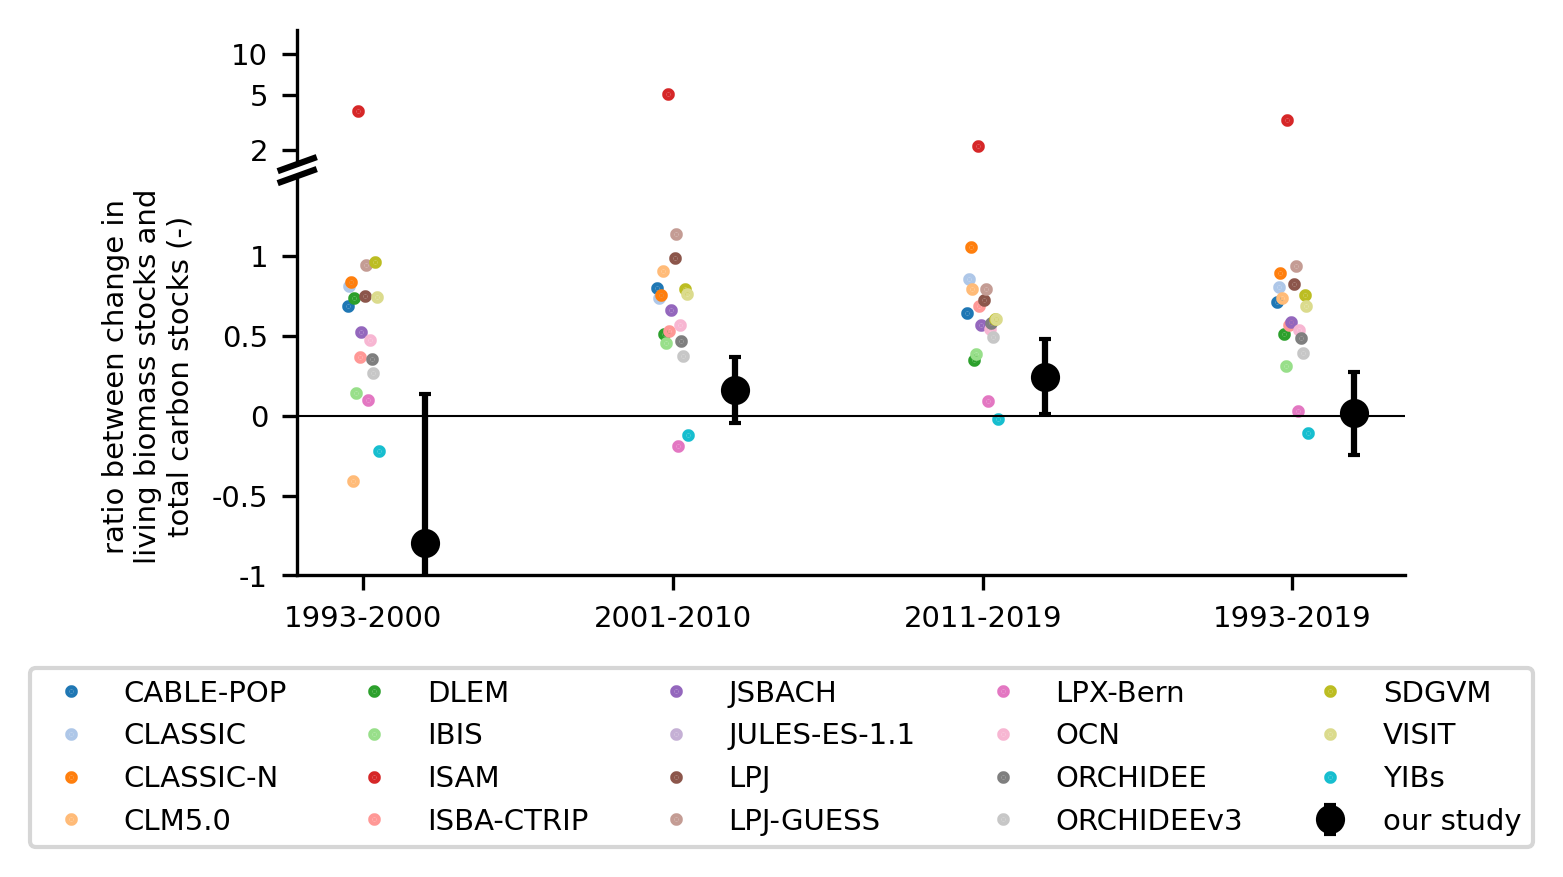

In [68]:
# calculate the ratios and their standard deviation
DGVM_ratios,ratios,ratio_std = get_ratios(single_DGVM_data,obs_periods)

# plot the data
fig = generate_fig_s9_s10(DGVM_ratios,ratios,ratio_std)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")

plt.savefig(f'../figures/fig_s9_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s9_{d}.svg',dpi=300)

## Figure S10

/tmp/ipykernel_41945/4026072074.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  ratios = global_obs.loc[('mean','delta_B')]/global_obs.loc[('mean','delta_C')]


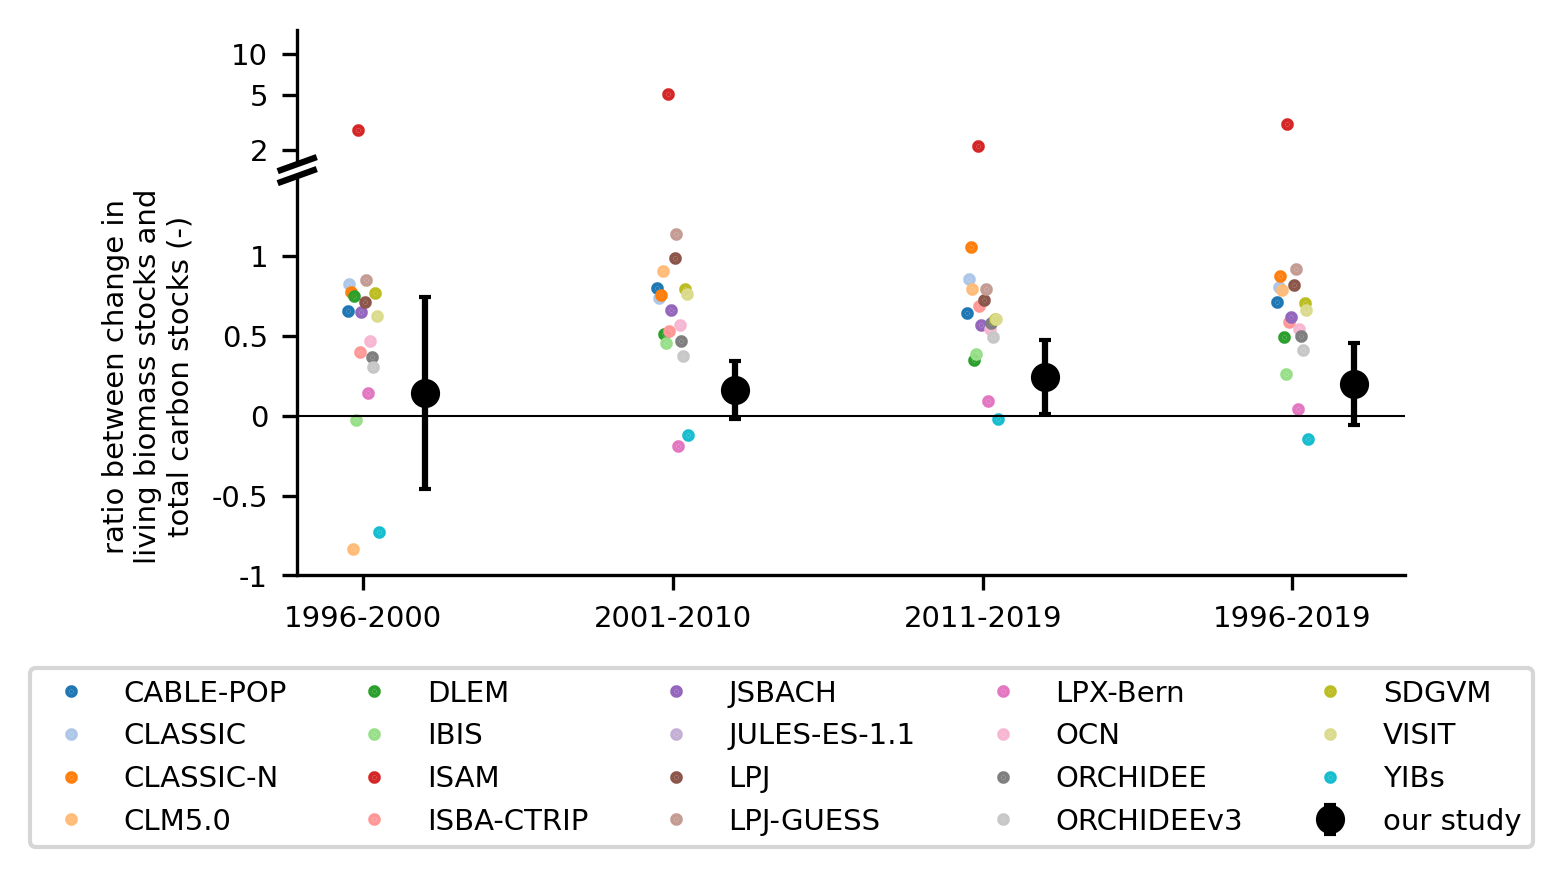

In [33]:
# calculate the ratios and their standard deviation
DGVM_ratios,ratios,ratio_std = get_ratios(single_DGVM_data_1995,obs_periods_1995)

# plot the data
fig = generate_fig_s9_s10(DGVM_ratios,ratios,ratio_std)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s10_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s10_{d}.svg',dpi=300)

## Figure S11

In [34]:
# extract the data from the observational data for different periods and regions
figs11_data = (obs_periods/1e15).reset_index(name='estimate').sort_values('time')
figs11_data.columns = ['measure','pool','region','time','estimate']

# drop the "Other" and "Global" regions and the "1993-2019" time period
figs11_data = figs11_data[(~figs11_data['region'].isin(['Other','Global'])) & (figs11_data['time']!='1993-2019')]

# reorganize data to have index of region,time, and measure and columns of pool
figs11_data = figs11_data.set_index(['region','time','measure','pool'])['estimate'].unstack()[['delta_C','delta_B','delta_OC']]

# modify labels such that "North America" will be in two lines
figs11_data.index = figs11_data.index.set_levels(figs11_data.index.levels[0].str.replace('North ','North\n'),level='region')

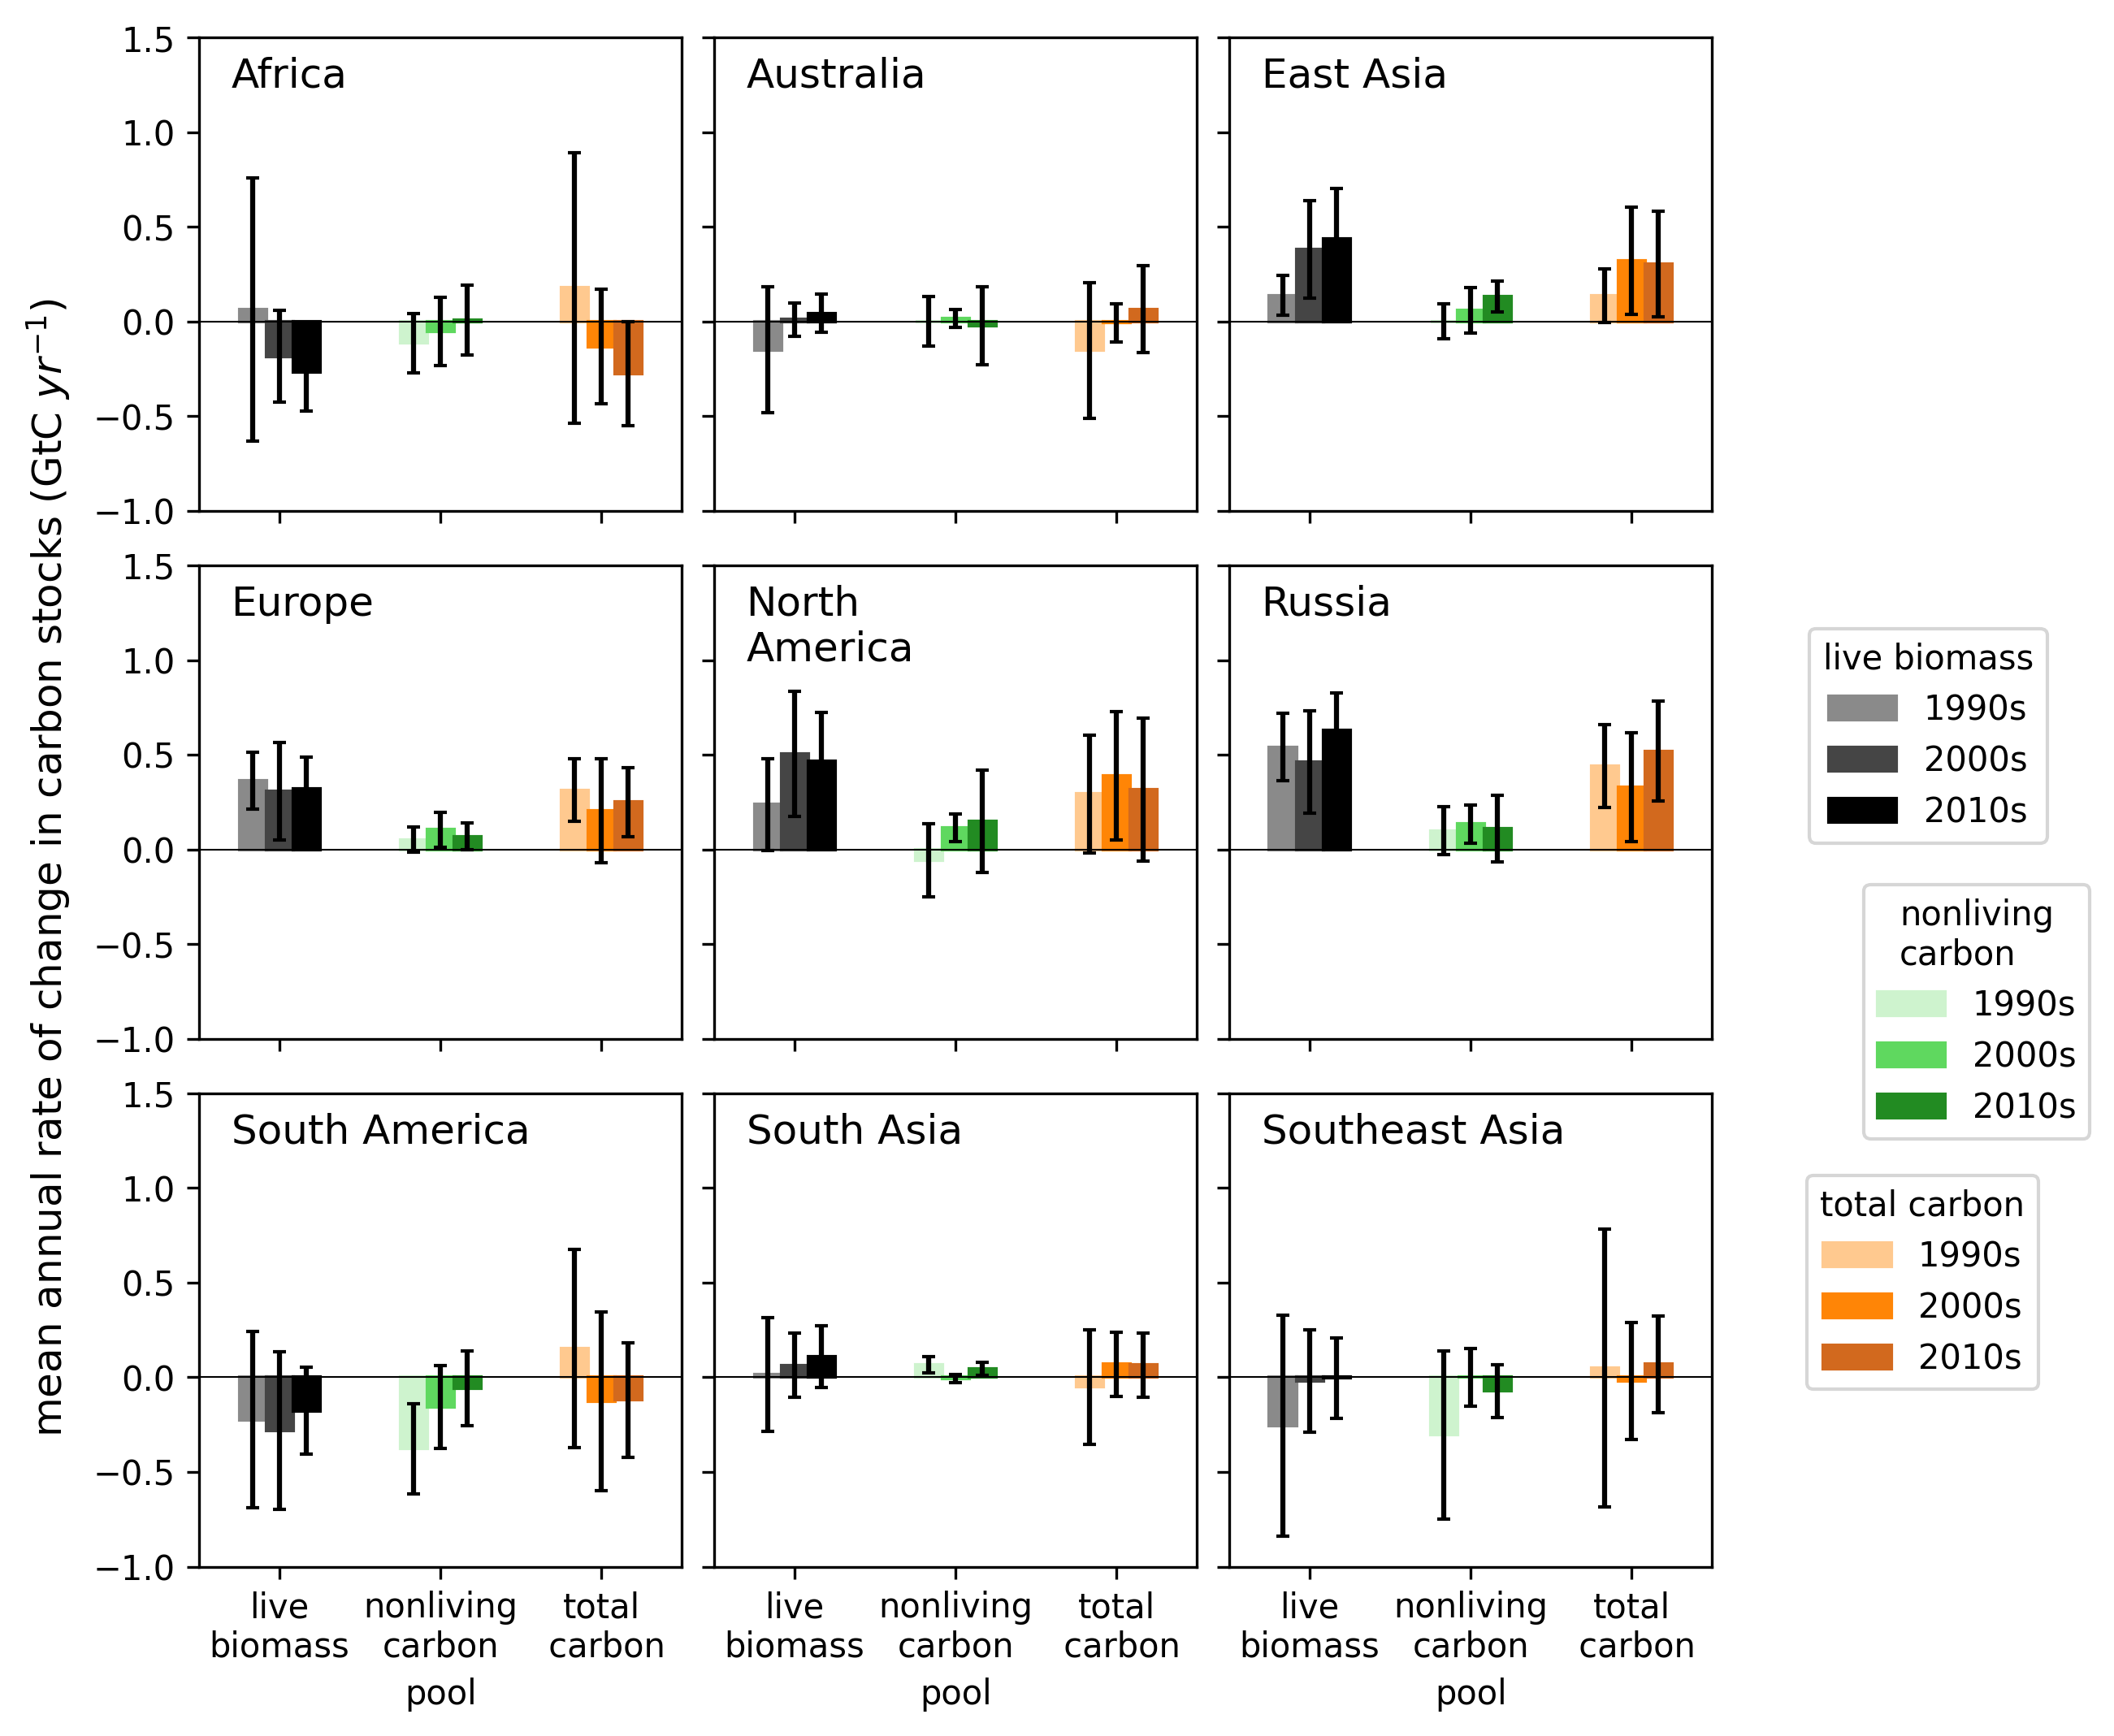

In [35]:
# set the figure, fonts and colors
colors =['#8A8A8A','#CEF3CE','#FFC98F','#454545','#5FD85F','#FF8506','k','forestgreen','chocolate']
font = {'size'   : 10}
matplotlib.rc('font', **font)
fig,axs =plt.subplots(3,3,dpi=300,figsize=[17.8/2.54,17.8/2.54],constrained_layout=True,sharex=True,sharey=True)

# for each region
for name, (i,ax) in zip(figs11_data.index.get_level_values('region').unique(),enumerate(axs.flatten())):
    
    # get the mean estimate 
    mean = figs11_data.loc[pd.IndexSlice[name,:,'mean'],:]
    mean.index = mean.index.droplevel(['region','measure'])
    
    # get the std
    std = figs11_data.loc[pd.IndexSlice[name,:,'std'],:]
    std.index = std.index.droplevel(['region','measure'])
    
    # plot the bar plot
    barlist = mean.T.plot.bar(ax=ax,legend=False,yerr=std.T,capsize=2)
    
    # set the color of each barplot according to the color list
    for b,c in zip([i  for i in barlist.get_children() if type(i)== Rectangle],colors):
        b.set_color(c)

    # set the axes labels and limits
    ax.set(xticks=range(3),xticklabels=['live\nbiomass','nonliving\ncarbon','total\n carbon'],ylim=[-1,1.5])
    ax.tick_params(rotation=0)

    # draw a horizontal line at 0
    ax.axhline(0,c='k',lw=0.5,ls='-')
    
    # set the title of the region
    ax.text(-.3,1.4,name,ha='left',va='top',fontdict={'size':12})
    
# the figure-level y axis label
fig.supylabel('mean annual rate of change in carbon stocks (GtC $yr^{-1}$)')

# draw legend
bpatch = [mpatches.Patch(color=i, label=j) for i,j in zip(np.array(colors)[::3],['1990s','2000s','2010s'])]
ocpatch = [mpatches.Patch(color=i, label=j) for i,j in zip(np.array(colors)[1::3],['1990s','2000s','2010s'])]
cpatch = [mpatches.Patch(color=i, label=j) for i,j in zip(np.array(colors)[2::3],['1990s','2000s','2010s'])]
fig.legend(handles=bpatch,bbox_to_anchor=[1.2,.65],title='live biomass')
fig.legend(handles=ocpatch,bbox_to_anchor=[1.225,.5],title='nonliving\ncarbon')
fig.legend(handles=cpatch,bbox_to_anchor=[1.195,.33],title='total carbon')

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s11_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s11_{d}.svg',dpi=300)

## Figure S12

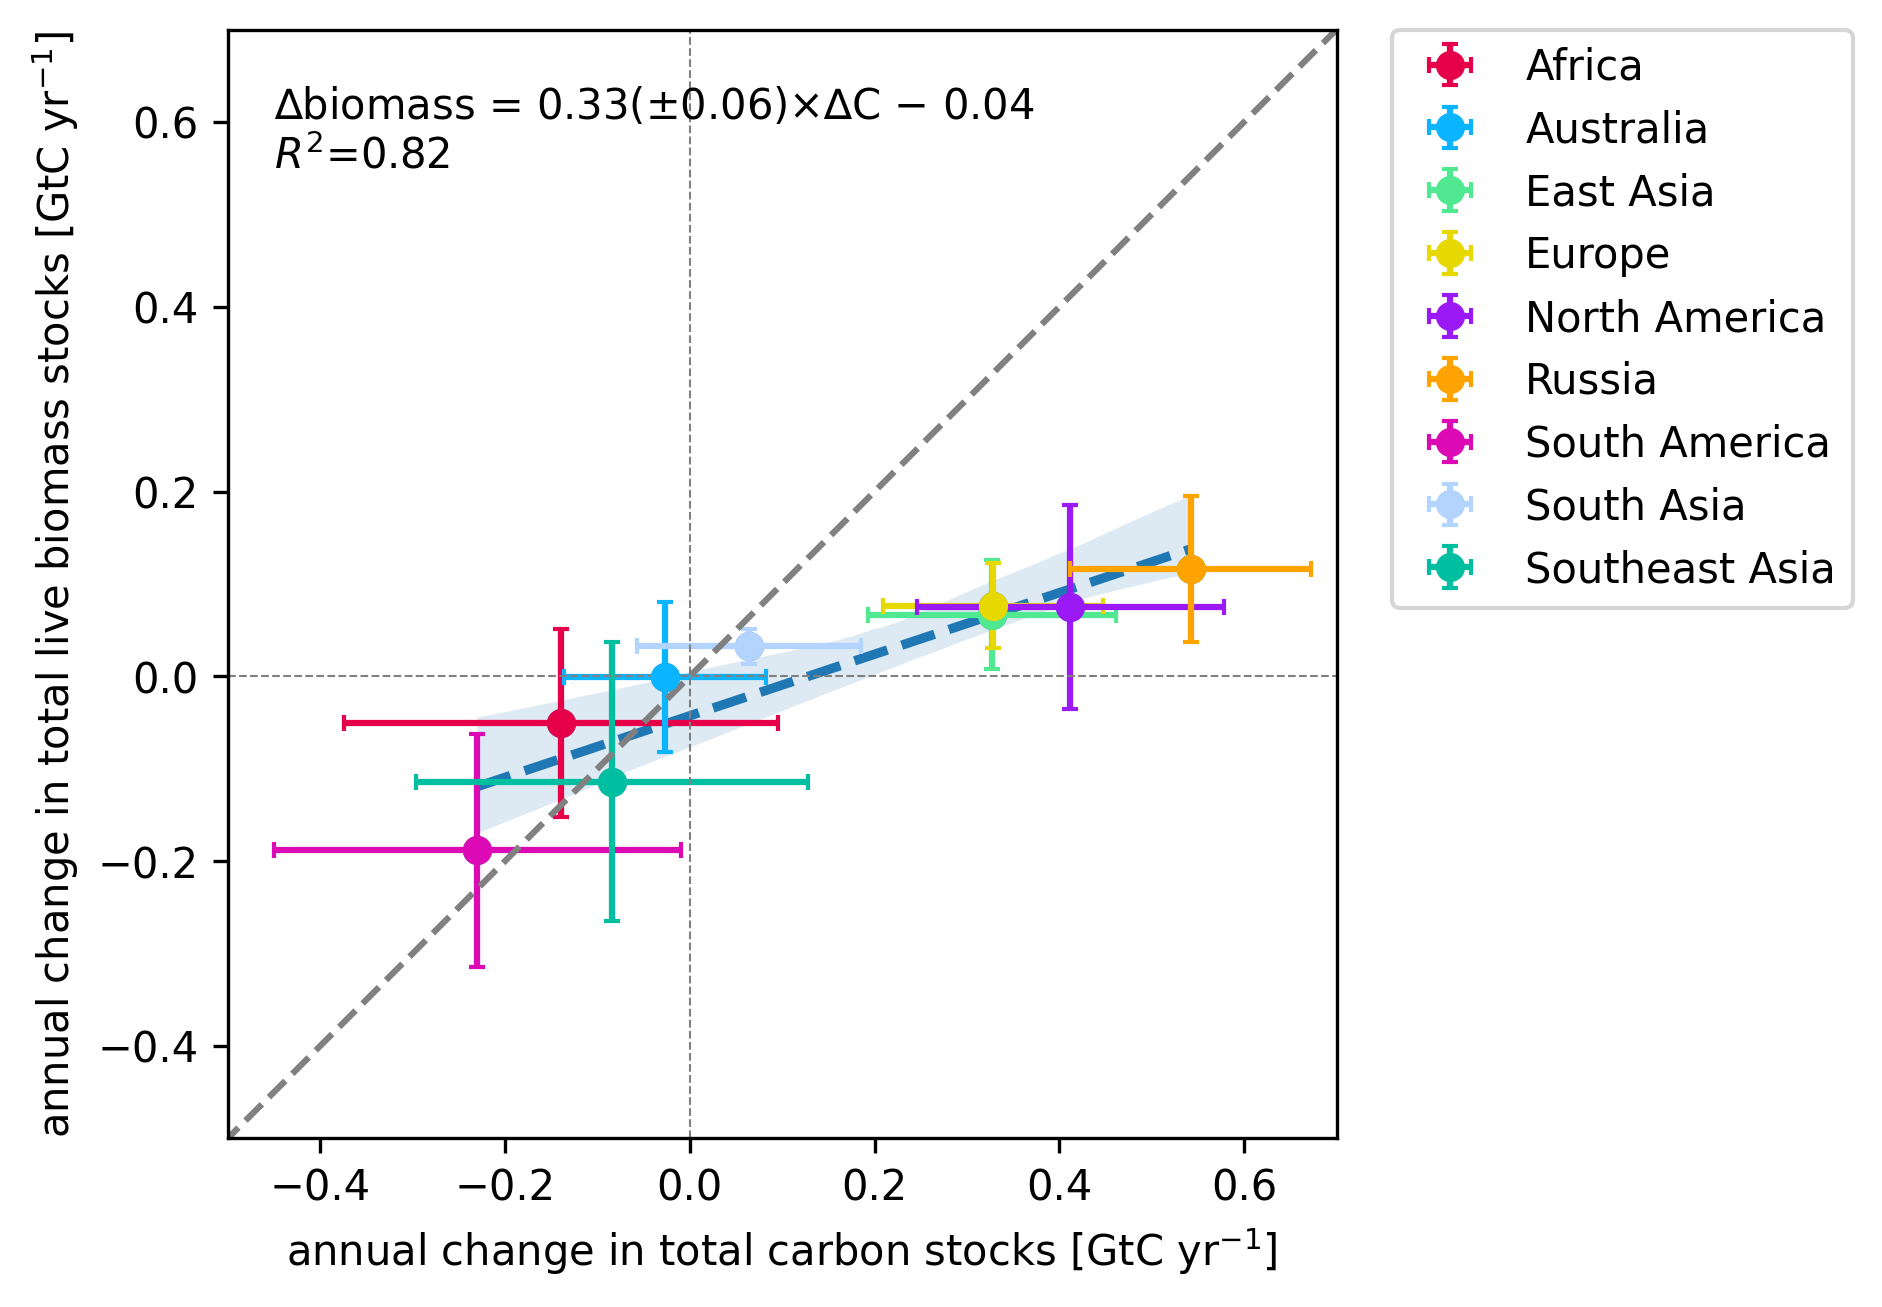

In [36]:
# extract the long term mean change in living biomass and total carbon stocks for each region
fig_s12_data = obs_periods.loc[pd.IndexSlice[:,:,:,'1993-2019']].unstack('pool')[['delta_C','delta_B']]/1e15

# remove the global data and the "Other" region
fig_s12_data = fig_s12_data[~fig_s12_data.index.get_level_values(level=1).isin(['Global','Other'])]


# set the figure fonts and colors
font = {'size'   : 10}
matplotlib.rc('font', **font)
fig, ax =plt.subplots(dpi=300)
cs = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

# plot the regplot between delta_B and delta_C
sns.regplot(fig_s12_data.loc['mean'],x='delta_C',y='delta_B',line_kws={'ls':'--'})

# for each region plot an error bar in both x and y
for (i,r),(i2,s),c in zip(fig_s12_data.loc['mean'].iterrows(),fig_s12_data.loc['std'].iterrows(),cs):
    ax.errorbar(r['delta_C'],r['delta_B'],xerr=s['delta_C'],yerr=s['delta_B'],ls='',marker='o',capsize=2,c=c,label=i)

#calculate slope and intercept of regression equation
slope, intercept, r2, p, sterr = scipy.stats.linregress(x=fig_s12_data.loc['mean','delta_C'],
                                                       y=fig_s12_data.loc['mean','delta_B'])
# add the regression equation to the plot
ax.text(-0.45,0.55 , '∆biomass = ' + str(round(slope,2)) + '(±' + str(round(sterr,2))+')$\\times$∆C'+ (' $-$ ' if (intercept<0) else ' $+$ ') + str(abs(round(intercept,2))) + '\n$R^2$='+str(round(r2**2,2)))

# plot a 1:1 line and zero x and y lines
ax.plot([-0.8,0.8],[-0.8,0.8],c='grey',ls='--')
ax.axhline(0,c='grey',lw=0.5,ls='--')
ax.axvline(0,c='grey',lw=0.5,ls='--')

# set the axes labels and limits
ax.set(xlim=[-0.5,.7],ylim=[-0.5,.7],xlabel='annual change in total carbon stocks [GtC yr$^{-1}$]',ylabel='annual change in total live biomass stocks [GtC yr$^{-1}$]')

# set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s12_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s12_{d}.svg',dpi=300)

## Figure S13

In [37]:
# extract the data from the observational data for different regions for the entire study period
figs1314_data_obs = obs_periods.loc[pd.IndexSlice[:,:,:,'1993-2019']].unstack('pool')[['delta_C','delta_B']]/1e15
figs1314_data_obs = figs1314_data_obs[~figs1314_data_obs.index.get_level_values(level=1).isin(['Global','Other'])]

figs1314_data_DGVMs = DGVMs_periods.loc[pd.IndexSlice[:,:,:,'1993-2019']].unstack('pool')[['delta_C','delta_B']]/1e15
figs1314_data_DGVMs = figs1314_data_DGVMs[~figs1314_data_DGVMs.index.get_level_values(level=1).isin(['Global','Other'])]

In [38]:
def generate_fig_s13_s14(figs1314_data_obs:pd.DataFrame, figs1314_data_DGVMs:pd.DataFrame, colors:list, pool:str) -> plt.Figure:
        '''
        Generate the figure for the mean annual rate of change in carbon stocks for the different regions for the entire study period

        Parameters:
        figs1314_data_obs: pd.DataFrame
                The data frame with the observational data
        figs1314_data_DGVMs: pd.DataFrame
                The data frame with the DGVM data
        colors: list
                The list with the colors for the bar plots
        pool: str
                The pool to plot

        Returns:
        plt.Figure
                The figure with the plot
        '''
        
        # set the figure and fonts 
        font = {'size'   : 10}
        matplotlib.rc('font', **font)
        fig,axs =plt.subplots(3,3,dpi=300,figsize=[17.8/2.54,17.8/2.54],constrained_layout=True,sharex=True,sharey=True)

        # for each region
        for (name,df_obs),(name2,df_obs_std),(name3,df),(name4,df_std), (i,ax) in zip(figs1314_data_obs.loc['mean'].iterrows(),figs1314_data_obs.loc['std'].iterrows(),figs1314_data_DGVMs.loc['mean'].iterrows(),figs1314_data_DGVMs.loc['std'].iterrows(),enumerate(axs.flatten())):

                # plot the bar plot
                ax.bar(x = range(2),width = 0.4, height = [df['delta_C'],df_obs['delta_C']],bottom=0,yerr=[df_std['delta_C'],df_obs_std['delta_C']],color = colors,alpha=0.7,edgecolor='grey',lw=0,capsize=2)
                
                # set the axes labels and limits
                ylab = 'mean flux (GtC $yr^{-1}$)' if i % 3 == 0 else ''
                ax.set(xticks=range(2),xticklabels=['DGVMs','observation\nbased estimate'],ylabel=ylab,ylim=[-0.75,1])
                
                # draw a horizontal line at 0
                ax.axhline(0,c='k',lw=0.5,ls='-')

                # set the title of the region
                ax.text(-.2,0.9,name,ha='left',va='top',fontdict={'size':12})
        
        return fig

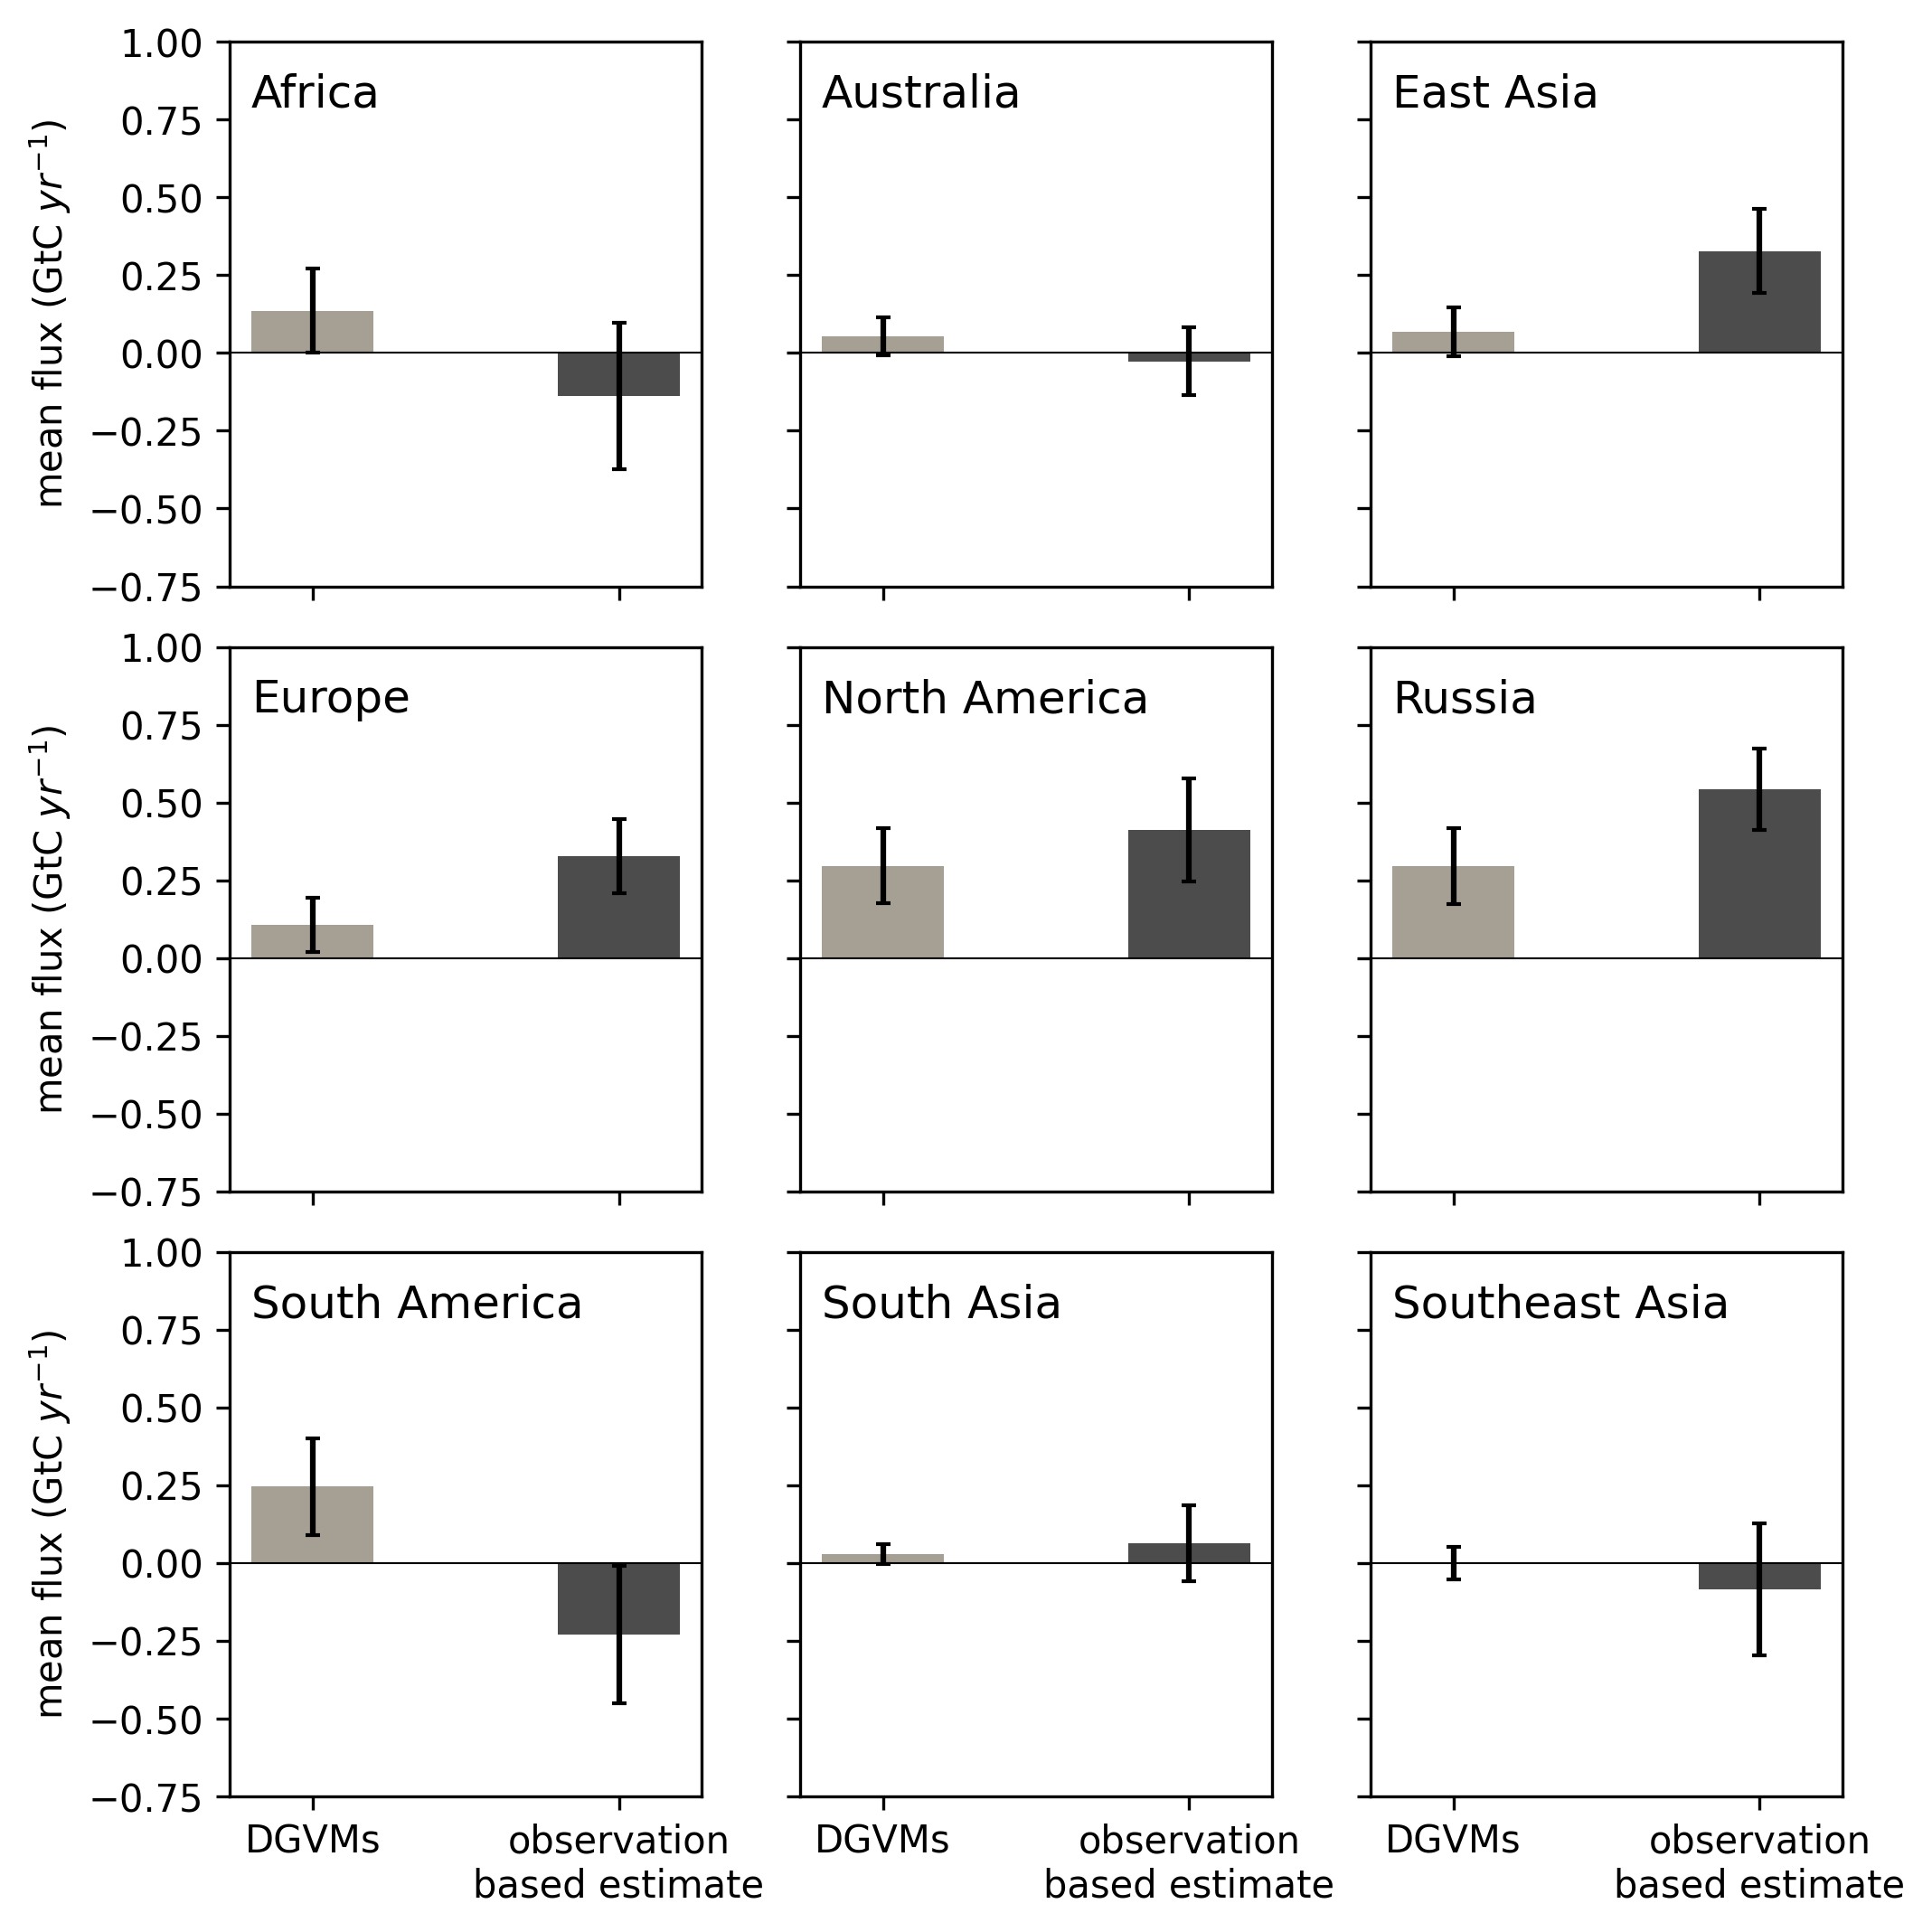

In [39]:
# define colors
colors = ['#817667','k']

# generate the figure
fig = generate_fig_s13_s14(figs1314_data_obs,figs1314_data_DGVMs,colors,'delta_C')

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s13_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s13_{d}.svg',dpi=300)

## Figure S14

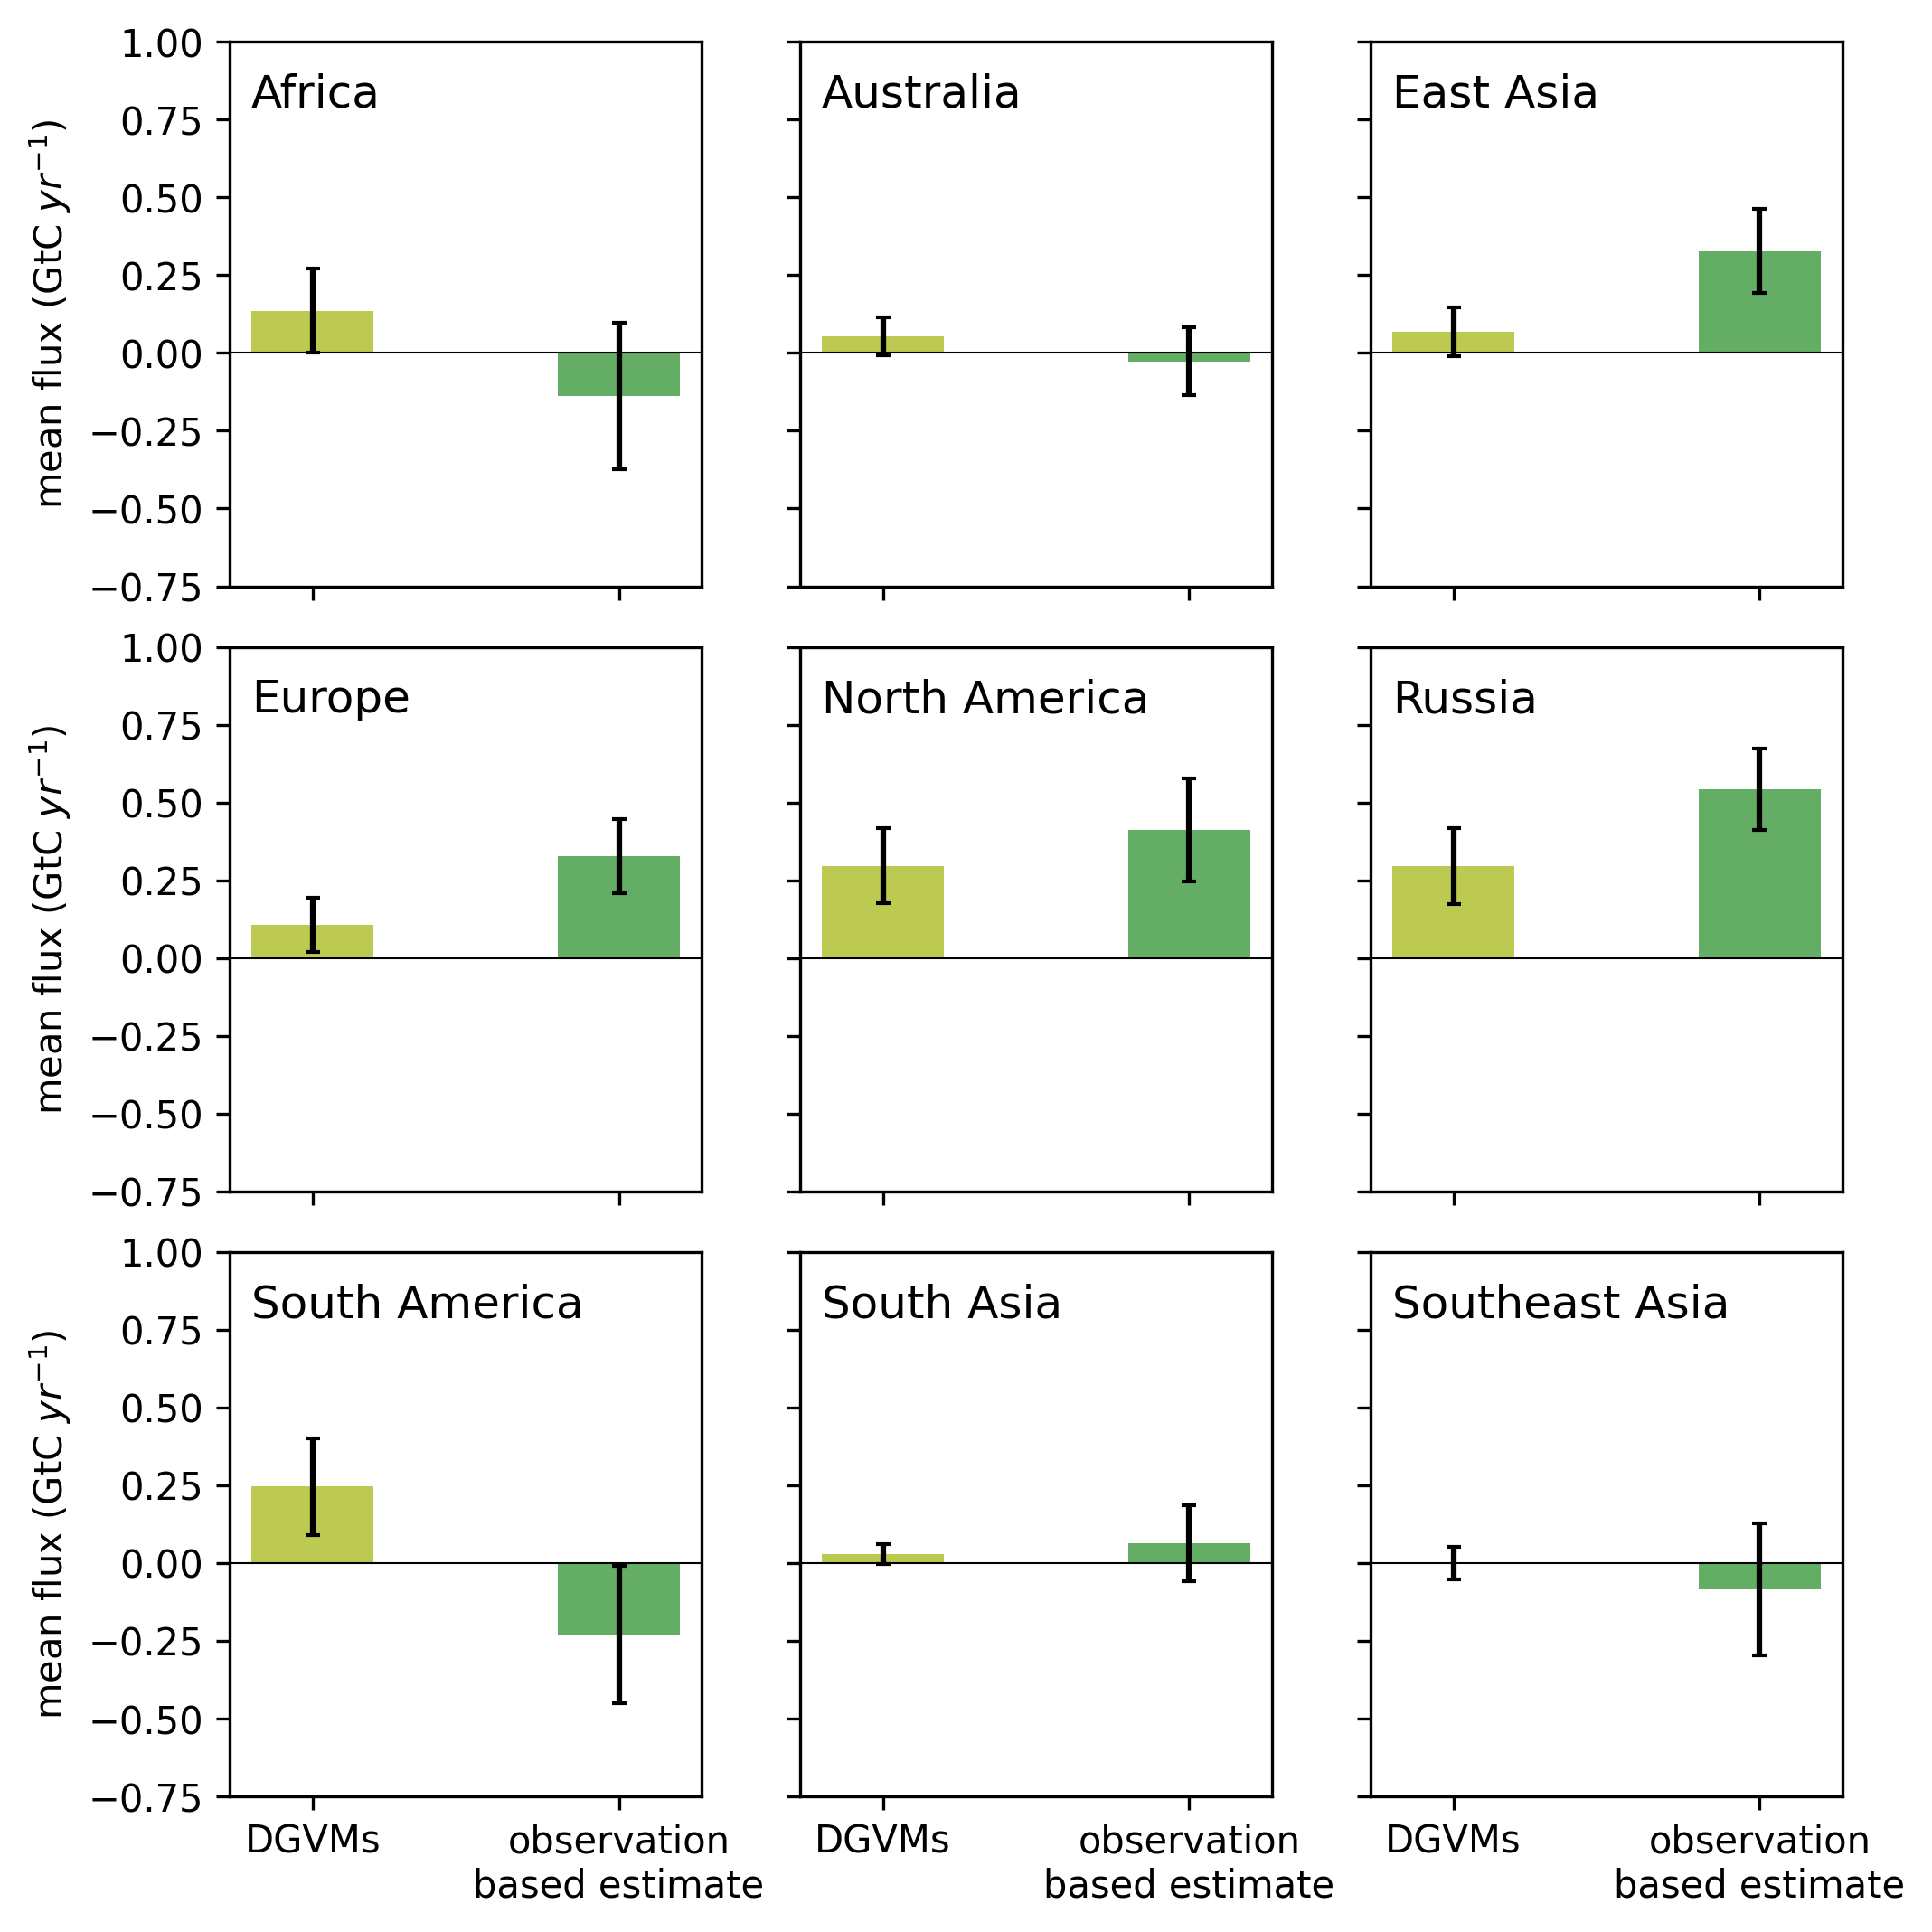

In [40]:
# define colors
colors = ['#A2B409','forestgreen']

# generate the figure
fig = generate_fig_s13_s14(figs1314_data_obs,figs1314_data_DGVMs,colors,'delta_B')

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s14_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s14_{d}.svg',dpi=300)

## Figure S15

In [41]:
def get_mask_intact(info:pd.Index,filter) -> pd.Index:
    """
    Generate a mask for the data based on intact forest cutoof

    Parameters:
    info: pd.Index
        The series with the method names
    filter: 
        The method name to filter by

    Returns:
    pd.Index
        The mask for the data
    """

    # get the method data and source
    sources_with_sens = info[info.get_level_values('method').str.contains('100')].get_level_values('source').unique()

    # take only data sources with no sensitivity or those with sensitvity that end with the filter
    mask = (~info.get_level_values('source').isin(sources_with_sens)) | (info.get_level_values('source').isin(sources_with_sens) & info.get_level_values('method').str.endswith(filter+'_regions'))

    return mask

def get_name_intact(filter:list) -> list:
    """
    Generate the name for the different forest cutoffs

    Parameters:
    filter: list
        The list of sensitivity analyses

    Returns:
    list
        The name for the method combination
    """

    return ['no correction','correction for >100 MgC ha$^{-1}$','correction for >200 MgC ha$^{-1}$']

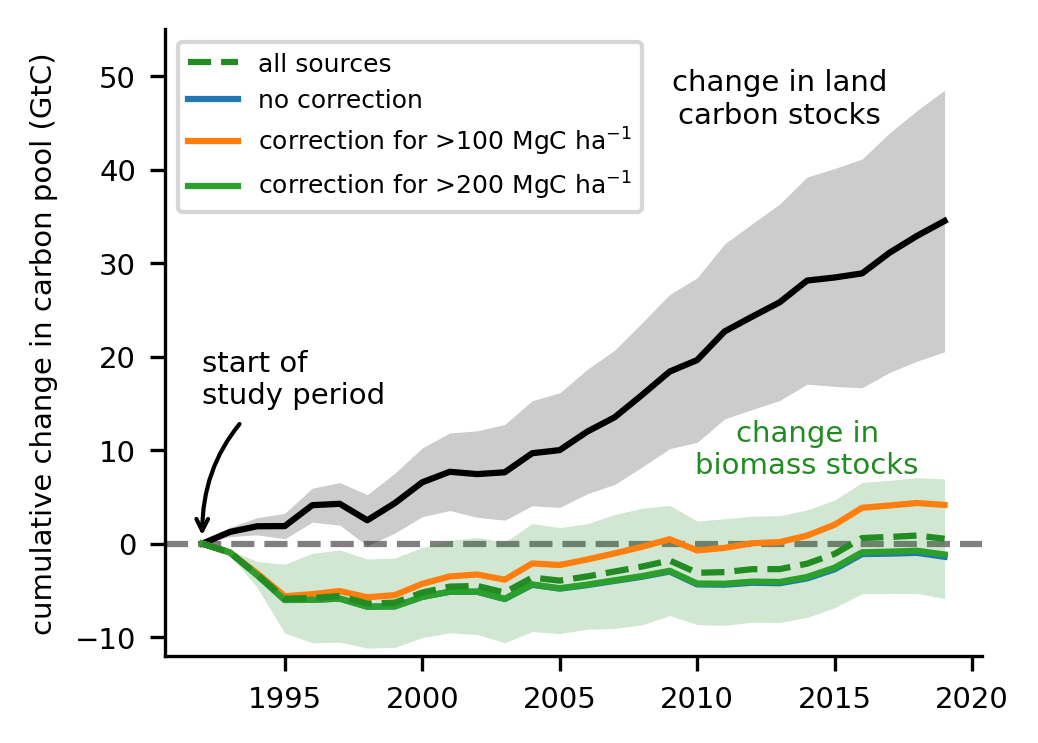

In [42]:
# set up the cutoffs
sens_levels = ['TB','100','200']

# run the sensitivity analysis
source_sens = run_annual_cum_sens(biomass_data_obs,biomass_data_obs.index,get_mask_intact,sens_levels,get_name_intact)

# plot the sensitivity analysis
fig_s15 = plot_annual_cum_sensitivity(obs_annual_cum_mean,source_sens)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s15_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s15_{d}.svg',dpi=300)

## Figure S16

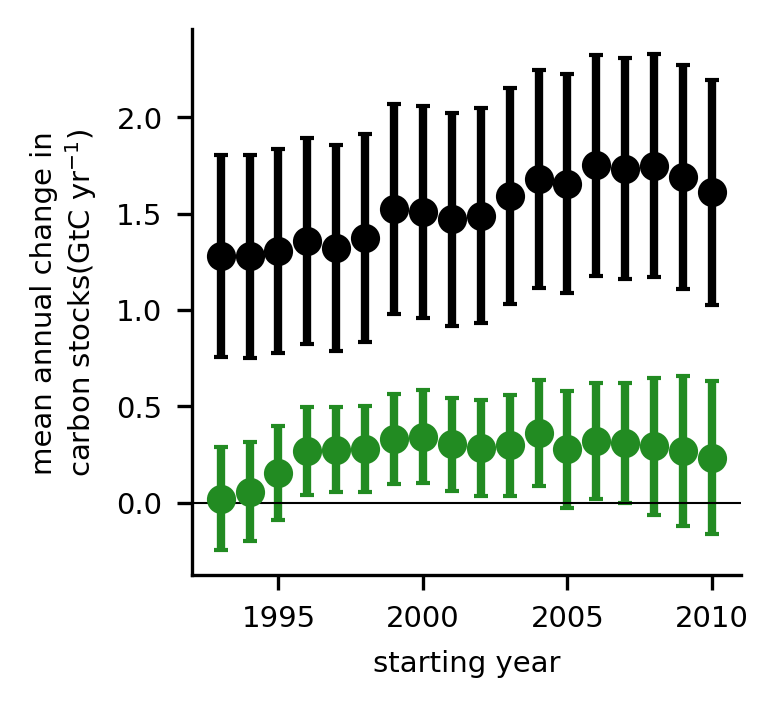

In [43]:
# set the fonts and figure
font = {'size'   : 7}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=[6/2.54,6/2.54],dpi=300)

# plot the errorbars
ax.errorbar(biomass_different_starts.index,biomass_different_starts['mean'],yerr = biomass_different_starts['std'],lw=2,ls='none',marker='o',capsize=1.7,color='forestgreen')
ax.errorbar(delta_C_different_starts.index,delta_C_different_starts['mean'],yerr = delta_C_different_starts['std'],lw=2,ls='none',marker='o',capsize=1.7,color='k')

# set the labels and axes limits
ax.set(xlabel='starting year',xlim=[1992,2011],ylabel='mean annual change in\ncarbon stocks(GtC yr$^{-1}$)')

# drop top and right spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# draw a horizontal line at zero
ax.axhline(0,c='k',lw=0.5,ls='-')

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s16_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s16_{d}.svg',dpi=300)

## Figure S17

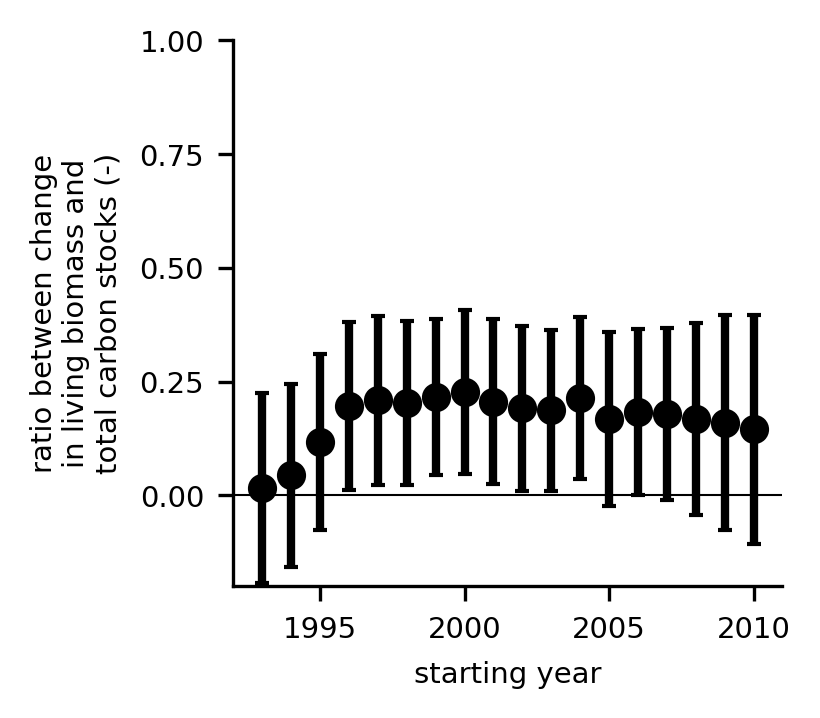

In [44]:
# calculate the coefficient of variation for delta_B and delta_C for different starts
CVs = pd.concat([biomass_different_starts['std']/biomass_different_starts['mean'],delta_C_different_starts['std']/delta_C_different_starts['mean']],axis=1,keys=['delta_B','delta_C'])

# calculate the ratio betweem delta_B and delta_C for different starts
ratios = biomass_different_starts['mean']/delta_C_different_starts['mean']

# calculate the standard deviation of the ratio by propagating the error of the CVs to the CV of the ratio and multiplying by the mean ratio
ratio_std = np.sqrt((CVs**2).sum(axis=1))*ratios

# set the fonts and figure
font = {'size'   : 7}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=[6/2.54,6/2.54],dpi=300)

# plot the errorbar
ax.errorbar(ratios.index,ratios,yerr = ratio_std,lw=2,ls='none',marker='o',capsize=1.7,color='k')

# set the labels and axes limits
ax.set(xlabel='starting year',xlim=[1992,2011],ylim=[-0.2,1],yticks=np.arange(0,1.25,0.25),ylabel='ratio between change\nin living biomass and\ntotal carbon stocks (-)')

# draw a horizontal line at zero
ax.axhline(0,c='k',lw=0.5,ls='-')

# drop top and right spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s17_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s17_{d}.svg',dpi=300)

## Figure S18

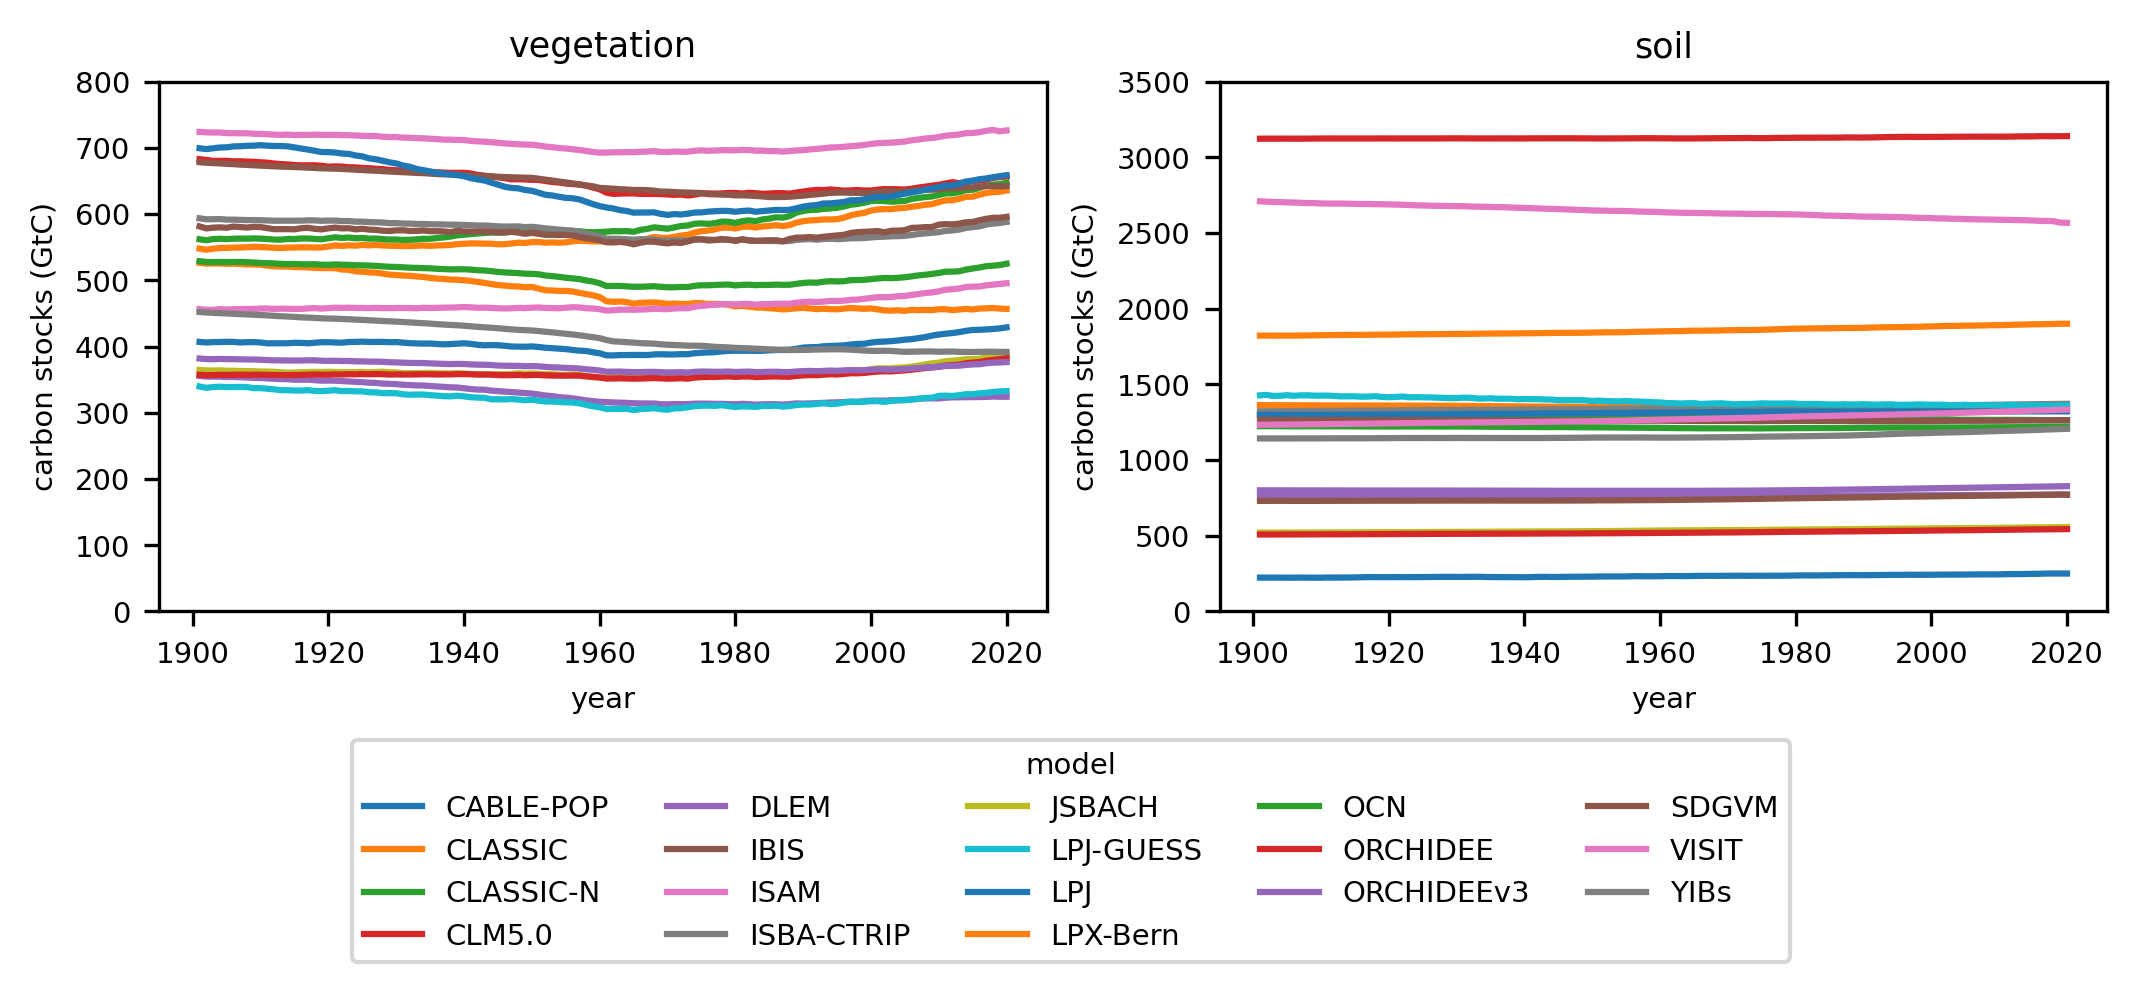

In [45]:
# define model names
models = ['CABLE-POP', 'CLASSIC', 'CLASSIC-N', 'CLM5.0', 'DLEM', 'IBIS', 'ISAM', 'ISBA-CTRIP', 'JSBACH', 'JULES-ES-1.1', 'LPJ-GUESS', 'LPJ', 'LPX-Bern', 'OCN', 'ORCHIDEE', 'ORCHIDEEv3', 'SDGVM', 'VISIT', 'YIBs']

fig, axs = plt.subplots(1,2,dpi=300,constrained_layout=True,figsize=[17.8/2.54,6/2.54])
# for each pool plot the data
for ax, pool,label,lims in zip(axs,['cVeg','cSoil'],['vegetation','soil'],[(0,800),(0,3500)]):
    
    # load RData file
    df = pyreadr.read_r(f'../data/DGVMs/{pool}_S3.RData')[f'{pool}_S3']
    
    # set columns as model names
    df.columns = models
    
    # set index as years
    df.index = np.arange(1901,2021)
    
    # remove missing values
    df.dropna(axis=1,inplace=True)
    
    # plot data
    df.plot(ax=ax,legend=False)

    # set panel title
    ax.set_title(label)

    # set axes labels and limits
    ax.set(xlabel='year',ylabel='carbon stocks (GtC)',ylim=lims)

# make horizontal legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.85, 0.), ncol=5,title='model')

# save figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s18_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s18_{d}.svg',dpi=300)

## Figure S19

In [46]:
# load forest area from FRA
FRA_data = pd.read_excel('../data/supplementary_analysis/forest_area/fra_2020.xlsx',sheet_name='1a_Forest',skiprows=4,index_col=0,usecols='A,M:Q')
FRA_data = FRA_data[FRA_data.index.notna()]

# # change year 1990 to 1992 to compare with ESA CCI data
FRA_data.columns = FRA_data.columns.astype(float).astype(int)
FRA_data = FRA_data.rename(columns = {1990:1992})

# convert from units of 1000 ha to m^2
FRA_data = FRA_data*1e7

In [47]:
# load forest area from ESA CCI for the same years as in FRA
comp_years = [1992,2000,2010,2015,2020]
files = glob('../results/00_preprocessing/ESA_CCI_landcover_processed_*.nc')
ESA_CCI_forest_data  = xr.open_mfdataset([f for f in files if int(f.split('_')[-1].split('.')[0]) in comp_years])['ESA_CCI_landcover_processed'].sel(landcover='forest')
ESA_CCI_forest_data.rio.write_crs(4326,inplace=True);

# calculate forest area for each country
ESA_CCI_forest_country = raster_vector_zonal_stats(countries_data.reset_index(),ESA_CCI_forest_data,'sum').unstack()

# set the columns to be the year value
ESA_CCI_forest_country.columns = ESA_CCI_forest_country.columns.year

# set the index to be the ISO3 code
ESA_CCI_forest_country['ISO3'] = countries_data['ISO_A3_EH']
ESA_CCI_forest_country.set_index('ISO3',inplace=True)

1992 0.9588607276453487 0.9173865826653202
2000 0.961287435796663 0.918351739873317
2010 0.9624228078039021 0.9175265089793422
2015 0.9626905542393751 0.9174074931058891
2020 0.9646513887672212 0.9188235054655904


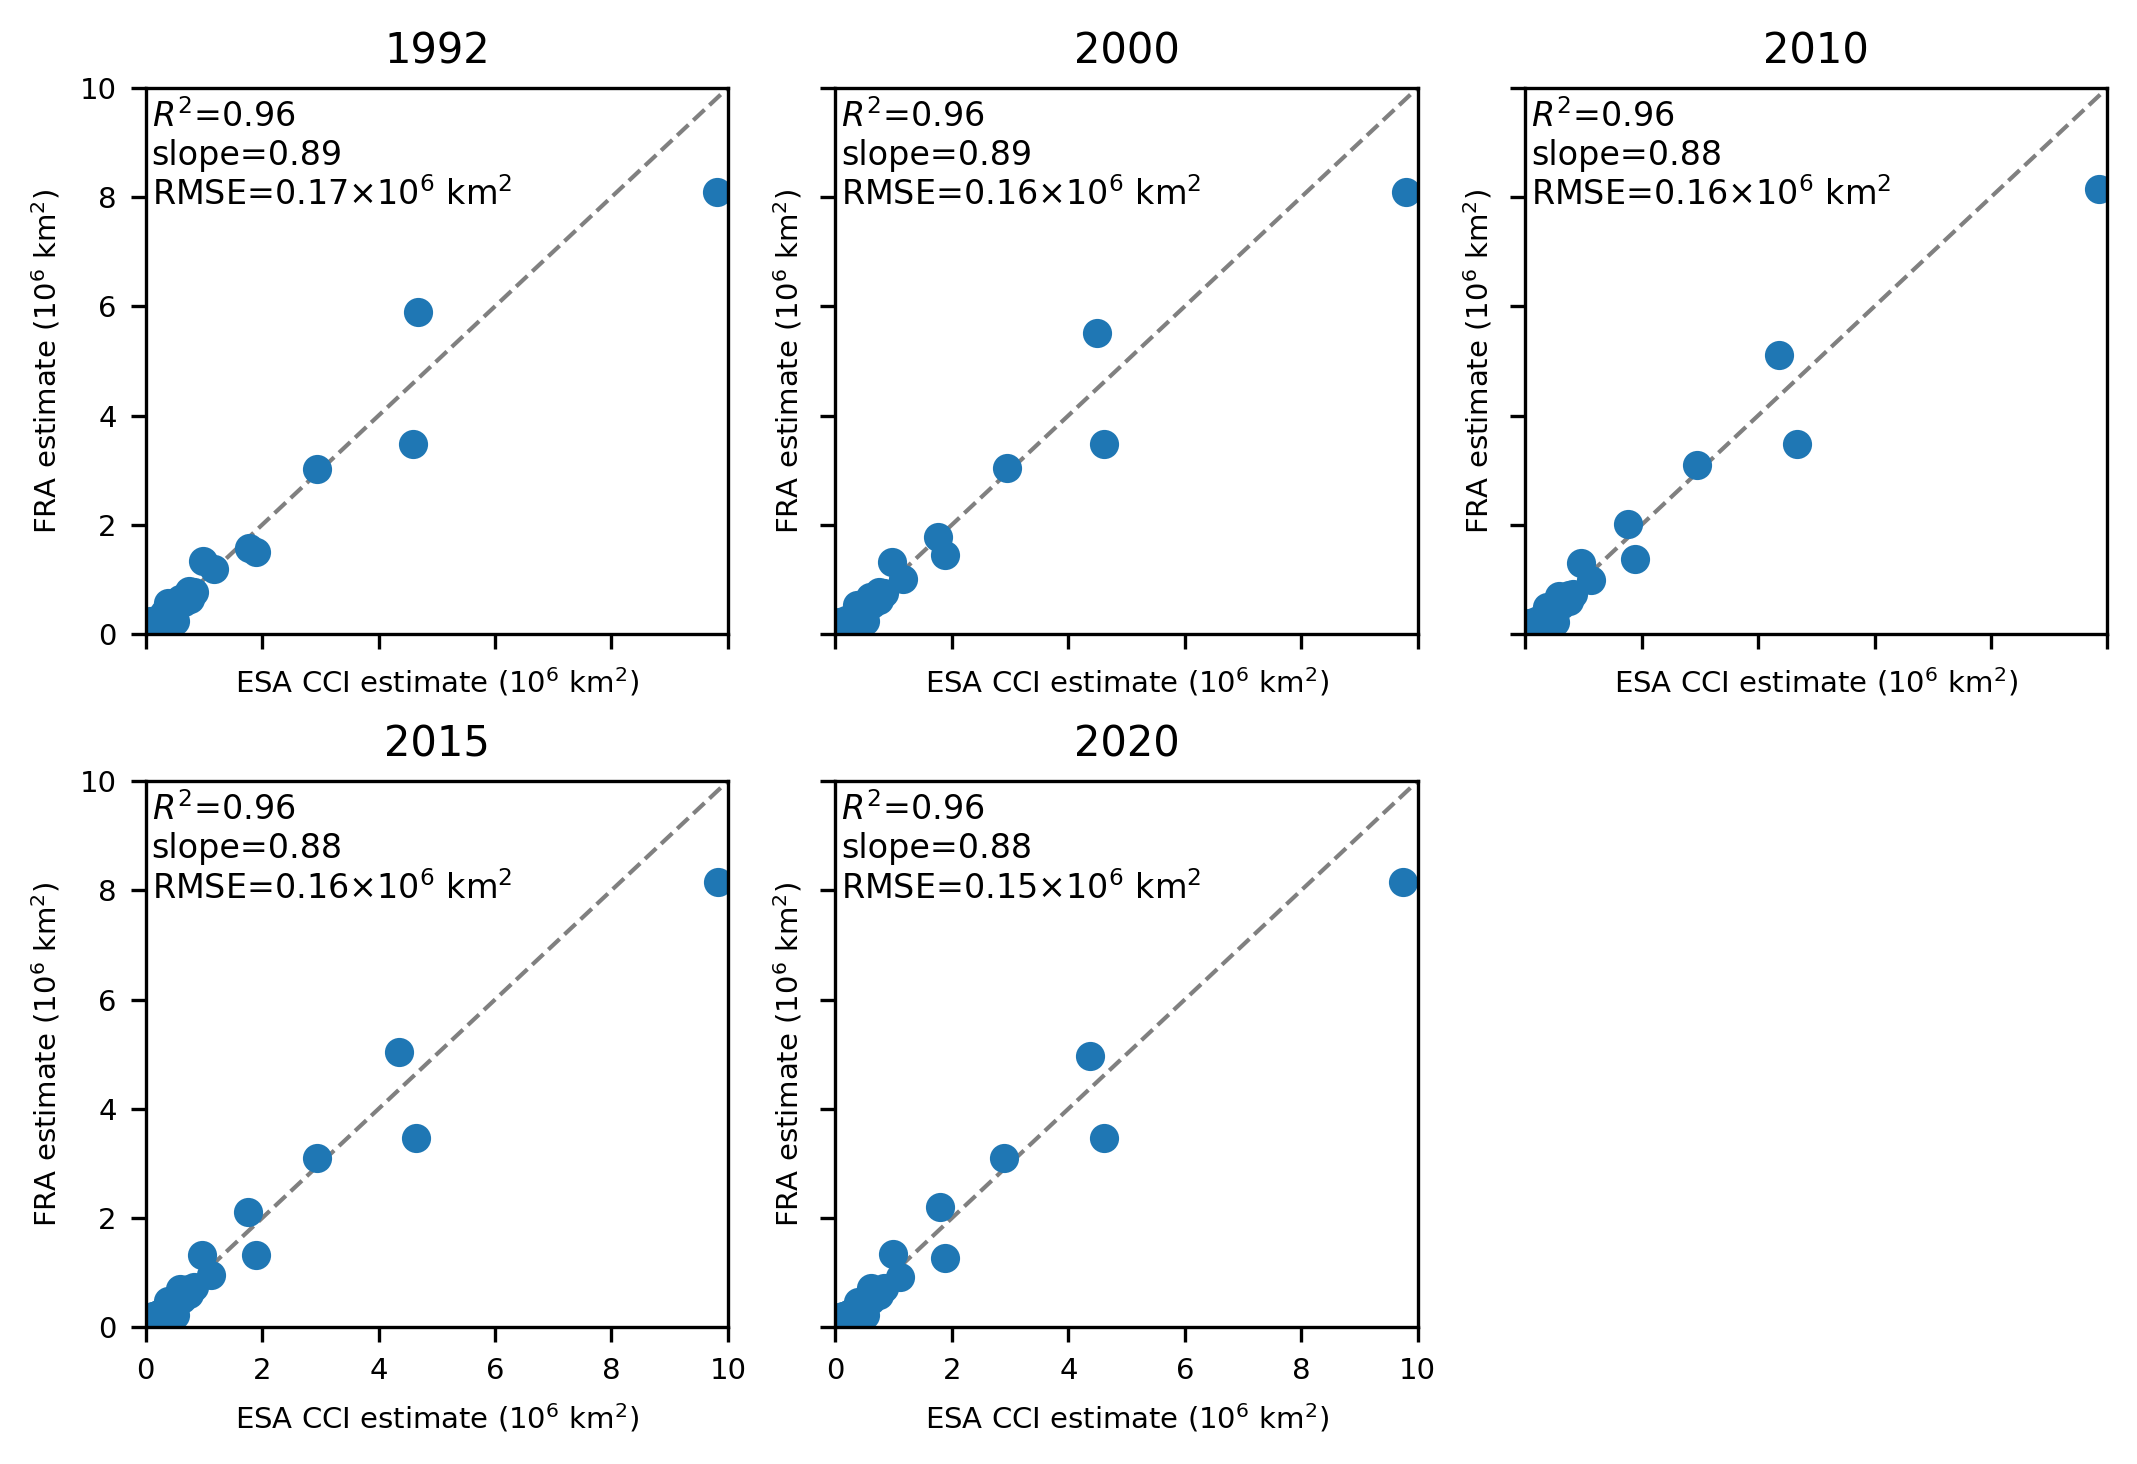

In [48]:
# set up figure
fig,axs = plt.subplots(2,np.ceil(ESA_CCI_forest_country.shape[1]/2).astype(int),dpi=300,constrained_layout=True,sharex=True,sharey=True,figsize=[17.8/2.54,12.1/2.54])

# for each year
for i,ax in zip(ESA_CCI_forest_country.columns,axs.flatten()):
    
    # set the pairs of the CCI and FRA countries
    pairs = pd.concat([ESA_CCI_forest_country[i]/1e12,FRA_data[i]/1e12],axis=1,keys=['CCI','FRA']).dropna()
    
    # calculate the R^2 between the countries
    R2 = r2_score(pairs['CCI'],pairs['FRA'])

    # calculate a linear regression between the countries
    reg = LinearRegression(positive=True,fit_intercept=False).fit(pairs['CCI'].values.T[:,np.newaxis], pairs['FRA'].values.T)

    # calculate the RMSE between the countries
    RMSE = np.sqrt(mean_squared_error(pairs['CCI'],pairs['FRA']))
    
    # print the results
    print(i,R2,scipy.stats.spearmanr(pairs['CCI'],pairs['FRA']).correlation**2)
    
    # plot the data
    ax.scatter(pairs['CCI'],pairs['FRA'])

    # set the axes labels and limits
    ax.set(xlabel='ESA CCI estimate ($10^6$ km$^2$)',ylabel='FRA estimate ($10^6$ km$^2$)',xlim=[0,10],ylim=[0,10],yticks=[0,2,4,6,8,10],xticks=[0,2,4,6,8,10])
    
    # set the title
    ax.set_title(f'{i}',fontsize=10)
    
    # add the regression results to the plot
    ax.text(0.1,9.8,f'$R^2$={round(R2,2)}\nslope={reg.coef_.round(2)[0]}\nRMSE={round(RMSE,2)}$\\times 10^6$ km$^2$',fontsize=8,va='top',ha='left')
    
    # plot a 1:1 line
    ax.plot([0,10],[0,10],c='grey',lw=1,ls='--',zorder=0)

# delete the last subplot
fig.delaxes(axs[1][2])

# save the figure
d=pd.to_datetime(date.today()).strftime("%y%m%d")
plt.savefig(f'../figures/fig_s19_{d}.png',dpi=300)
plt.savefig(f'../figures/fig_s19_{d}.svg',dpi=300)

## Table S2

In [49]:
# generate the table
table_S2 = generate_table1(obs_periods_1995,DGVMs_periods_1995,1995)

# save the table
d=pd.to_datetime(date.today()).strftime("%y%m%d")
table_S2.to_csv(f'../figures/table_s2_{d}.csv')
table_S2

period                            1996-2000  2001-2010  2011-2019  1996-2019
pool    source                                                              
delta_C observation-based         0.9 ± 0.5  1.3 ± 0.5  1.7 ± 0.6  1.4 ± 0.5
        global vegetation models  1.4 ± 0.8  1.2 ± 0.4  1.6 ± 0.6  1.4 ± 0.5
delta_B observation-based         0.1 ± 0.6  0.2 ± 0.3  0.4 ± 0.4  0.3 ± 0.2
        global vegetation models  0.8 ± 0.8  0.8 ± 0.5    1 ± 0.6  0.9 ± 0.5

In [50]:
obs_periods_1995.loc[pd.IndexSlice[:,'delta_B','Global',]]/1e15

stat  period   
mean  1996-2000    0.131499
      2001-2010    0.211451
      2011-2019    0.404626
      1996-2019    0.267235
std   1996-2000    0.559568
      2001-2010    0.291068
      2011-2019    0.399923
      1996-2019    0.223927
Name: 0, dtype: float64

## Numbers mentioned in the text

### The total carbon accumulated between 1992-2019

In [51]:
changes = (obs_periods.loc[pd.IndexSlice[:,['delta_B','delta_C'],'Global']].unstack()['1993-2019']*(2019-1992)/1e15).round(0)

print(f"The total change in total carbon stocks from 1992 to 2019 is: {changes.loc[('mean','delta_C')].values[0]:.0f}±{changes.loc[('std','delta_C')].values[0]:.0f}")
print(f"The total change in living biomass from 1992 to 2019 is: {changes.loc[('mean','delta_B')].values[0]:.0f}±{changes.loc[('std','delta_B')].values[0]:.0f}")

The total change in total carbon stocks from 1992 to 2019 is: 35±14
The total change in living biomass from 1992 to 2019 is: 1±7


### The ratio between biomass and total carbon stocks

In [52]:
# calculate the ratios and their standard deviation
DGVM_ratios,ratios,ratio_std = get_ratios(single_DGVM_data,obs_periods)
print(f"the average ratio between changes in carbon in living biomass and changes total carbon in DGVMs is: {DGVM_ratios[DGVM_ratios['period']=='1993-2019']['ratio'].mean().round(1)*100:.0f}%")

# calculate the ratios and their standard deviation
DGVM_ratios,ratios,ratio_std = get_ratios(single_DGVM_data_1995,obs_periods_1995)
print(f"the average ratio between changes in carbon in living biomass and changes total carbon in observations between 1995-2019 is: {ratios.loc['1996-2019'].round(1)*100:.0f}%±{ratio_std.loc['1996-2019'].round(1)*100:.0f}")


the average ratio between changes in carbon in living biomass and changes total carbon in DGVMs is: 70%
the average ratio between changes in carbon in living biomass and changes total carbon in observations between 1995-2019 is: 20%±20


/tmp/ipykernel_41945/4026072074.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  ratios = global_obs.loc[('mean','delta_B')]/global_obs.loc[('mean','delta_C')]
/tmp/ipykernel_41945/4026072074.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  ratios = global_obs.loc[('mean','delta_B')]/global_obs.loc[('mean','delta_C')]


### The uncorrelated and correlated uncertainties

In [53]:
# calculate the uncorrelated uncertainty
std_uncor = obs_periods.loc[pd.IndexSlice['std','delta_B','Global','1993-2019']]/1e15

# calculate the correlated uncertainty
std_cor = obs_periods_cor.loc[pd.IndexSlice['std','delta_B','Global','1993-2019']]/1e15

# calculate the uncertainty for the annual cumulative change
std_annual = obs_annual_cum_std['delta_B'].iloc[-1]/(2019-1992)
print(f'annual {std_annual:.2f} GtC yr-1\nuncorrelated {std_uncor:.2f} GtC yr-1\ncorrelated {std_cor:.2f} GtC yr-1')


annual 0.24 GtC yr-1
uncorrelated 0.26 GtC yr-1
correlated 0.41 GtC yr-1


### Total carbon gains in North America, Europe, Russia, and East Asia

In [54]:
num = fig3_data.loc[pd.IndexSlice['mean',['North\nAmerica','Europe','Russia','East Asia']],:].sum().loc['delta_C']
print(f'The total carbon gains in North America, Europe, Russia, and East Asia is ≈{num:.1f} GtC yr-1')

The total carbon gains in North America, Europe, Russia, and East Asia is ≈1.6 GtC yr-1


### Contribution of the difference between regions to the total difference between DGVMs and observations

In [55]:
# calculate difference between DGVMs and observations in Africa and South America
SA_AF_diff = figs1314_data_DGVMs.loc['mean'].loc[['South America','Africa']]['delta_B'].sum()-figs1314_data_obs.loc['mean'].loc[['South America','Africa']]['delta_B'].sum()

# calculate the difference in the global estimates for biomass in DGVMs and observations
global_diff = (DGVMs_periods.loc[('mean','delta_B','Global','1993-2019')]-obs_periods.loc[('mean','delta_B','Global','1993-2019')])/1e15
print(f"differences in South America and Africa explain ≈{(SA_AF_diff/global_diff).round(2)*100:.0f}% of the global differences between DGVMs and observations in changes in living biomass stocks")

differences in South America and Africa explain ≈60% of the global differences between DGVMs and observations in changes in living biomass stocks


### Ratio between our bottom up estimate for nonliving carbon pools and the residual estimate

In [56]:
residual_OC_estimate = obs_periods.loc[(['mean','std'],'delta_OC','Global','1993-2019')]/1e15

BU = nonliving_BU_data.loc['total estimate']

ratio_CV = np.sqrt((BU.loc['std']/BU.loc['mean'])**2 + (residual_OC_estimate.loc['std']/residual_OC_estimate.loc['mean'])**2).values[0]
ratio = (BU.loc['mean']/residual_OC_estimate.loc['mean']).values[0]
print(f"our bottom-up estimate of the chagnes in nonliving carbon pools can explain ≈{ratio.round(1)*100:.0f}±{(ratio*ratio_CV).round(1)*100:.0f}% of the top-down residual estimate for changes in nonliving carbon pools")

our bottom-up estimate of the chagnes in nonliving carbon pools can explain ≈20±20% of the top-down residual estimate for changes in nonliving carbon pools


### Total contribution of soil ersion, in inland waters and wetlands 

In [57]:
total_C_est = nonliving_BU_data.loc[['soil erosion','reservoirs','inland waters','wetlands']]['mean'].sum()
print(f"our bottom-up estimate of the changes in nonliving carbon pools from soil erosion, burial in inland waters and wetlands is ≈{total_C_est:.1f} GtC yr-1")

our bottom-up estimate of the changes in nonliving carbon pools from soil erosion, burial in inland waters and wetlands is ≈0.5 GtC yr-1


### Estimates for change in 2001-2019

In [58]:
est = obs_periods.loc[(['mean','std'],'delta_B','Global',['2001-2010','2011-2019'])]/1e15

print(f"the mean rate of change for 2001-2019, assuming uncorrelated error between time periods is: {est.loc['mean'].mean():.1f}±{((est.loc['mean']/2)**2).sum()**0.5:.1f} GtC yr-1")

the mean rate of change for 2001-2019, assuming uncorrelated error between time periods is: 0.3±0.2 GtC yr-1


### Estimates for change in nonliving carbon from top-down and bottom-up approaches

In [59]:
residual_OC_estimate = obs_periods.loc[(['mean','std'],'delta_OC','Global','1993-2019')]/1e15

BU = nonliving_BU_data.loc['total estimate']

print(f"our bottom-up estimate of the chagnes in nonliving carbon pools is  can explain ≈{BU.loc['mean']:.1f}±{BU.loc['std']:.1f} GtC yr-1, and our top-down residual estimate for changes in nonliving carbon pools is ≈{residual_OC_estimate.loc['mean'].values[0]:.1f}±{residual_OC_estimate.loc['std'].values[0]:.1f} GtC yr-1")

our bottom-up estimate of the chagnes in nonliving carbon pools is  can explain ≈0.3±0.3 GtC yr-1, and our top-down residual estimate for changes in nonliving carbon pools is ≈1.3±0.6 GtC yr-1


### Magnitude of bottom-up estimates of nonliving carbon excluding wetland and lake sinks

We remove wetland but add back pristine peatlands, and the part of the sink in lakes that increased since 1900, according to Fig.1 in [Anderson et al. (2020)](https://www.science.org/doi/10.1126/sciadv.aaw2145)

In [6]:
pristine_peatland_estimate = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/wetlands/pristine_peatlands.xlsx',index_col=0)
recent_lake_sink = 0.072
ss_estimate = nonliving_BU_data.drop(index=['total estimate','wetlands','inland waters']).sum().loc['mean'] + pristine_peatland_estimate['value'].mean() + recent_lake_sink

print(f'the estimate for the sink of nonliving carbon assuming wetlands and lakes are in steady-state is ≈{ss_estimate:.2g} GtC yr-1')

the estimate for the sink of nonliving carbon assuming wetlands and lakes are in steady-state is ≈0.13 GtC yr-1
